In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchinfo import summary
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
import torch.utils.data as data
from torchvision import transforms
import torchvision
import torchvision.utils as utils


#カレントディレクトリがipynbの場所になってる
#
import sys,os
sys.path.append(os.pardir)

import py_func.Deep_learning_torch_func as DL
import py_func.models_func as my_model
import py_func.dat_rb_func as drb
import py_func.my_numpy_class as mnc
import py_func.my_torch_class as mtc
import py_func.models_func as my_model
import py_func.Deep_learning_torch_func as DL
import py_func.dat_rb_func as drb


import torchvision.datasets as dset
from torchvision.datasets import ImageFolder


import py_func.gan.gan_model as ganmd
import py_func.gan.gan_func as ganf
import py_func.gan.gan_class as ganc

from torchinfo import summary

from torch.optim import lr_scheduler

import numpy as np

from torch.utils.tensorboard import SummaryWriter


import importlib

import pandas as pd

from sklearn.model_selection import train_test_split
import cv2

import os.path as osp

from tqdm import tqdm

import shutil

### CPU用に保存しなおす

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

In [4]:
generator = ganmd.GeneratorRRDB(3, fltrs=64, lendns = 5, \
            num_res_blck=23, num_upsmpl=2, upscale_factor=2).to(device)

In [5]:
model_path = '../GAN/ESRGAN/cat/model/generator_00029000.pth'
generator.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [7]:
model_path = "../snsapp/torchmodel/esr_cat_generator_cpu.pth"
torch.save(generator.to('cpu').state_dict(), model_path)

In [8]:
generator_cpu = ganmd.GeneratorRRDB(3, fltrs=64, lendns = 5, \
            num_res_blck=23, num_upsmpl=2, upscale_factor=2)

In [9]:
model_path = "../snsapp/torchmodel/esr_cat_generator_cpu.pth"
generator_cpu.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [2]:
ROOT = '../GAN/'

In [3]:
# データセットのディレクトリ

dataset_dir = "../oxford_pet/esrgan_cat/"
# データセットの学習データディレクトリ
train_dir = osp.join(dataset_dir, 'train')
# データセットのテストデータディレクトリ
test_dir = osp.join(dataset_dir, 'test')
# デモ用のデータディレクトリ
demo_dir = osp.join(dataset_dir, 'demo')

In [4]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
####################-----------------------ESRGAN-----------------------------

In [5]:
esr_dir = osp.join(ROOT, "ESRGAN")
output_dir = osp.join(esr_dir, "outimage")

image_train_save_dir = osp.join(output_dir, 'train')
image_test_save_dir = osp.join(output_dir, 'test')

weight_save_dir = osp.join(esr_dir, "model")

param_save_path = osp.join(esr_dir, 'param.json')

In [13]:
importlib.reload(ganc)
importlib.reload(ganmd)

<module 'py_func.gan.gan_model' from '..\\py_func\\gan\\gan_model.py'>

In [6]:
class Opts():
    def __init__(self):
        self.n_epoch = 50
        self.residual_blocks = 23
        self.lr = 0.0002
        self.b1 = 0.9
        self.b2 = 0.999
        self.batch_size = 16
        self.n_cpu = 2
        self.warmup_batches = 500
        self.lambda_adv = 5e-3
        self.lambda_pixel = 1e-2
        self.pretrained = False
        self.dataset_name = 'cat'
        self.sample_interval = 100
        self.checkpoint_interval = 1000
        self.hr_height = 128
        self.hr_width = 128
        self.channels = 3
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def to_dict(self):
        parameters = {
            'n_epoch': self.n_epoch,
            'hr_height': self.hr_height,
            'residual_blocks': self.residual_blocks,
            'lr': self.lr,
            'b1': self.b1,
            'b2': self.b2,
            'batch_size': self.batch_size,
            'n_cpu': self.n_cpu,
            'warmup_batches': self.warmup_batches,
            'lambda_adv': self.lambda_adv,
            'lambda_pixel': self.lambda_pixel,
            'pretrained': self.pretrained,
            'dataset_name': self.dataset_name,
            'sample_interval': self.sample_interval,
            'checkpoint_interval': self.checkpoint_interval,
            'hr_height': self.hr_height,
            'hr_width': self.hr_width,
            'channels': self.channels,
            'device': str(self.device),
        }
        return parameters
opt = Opts()
ganc.save_json(opt.to_dict(), param_save_path, 'w')

In [7]:
hr_shape = (opt.hr_height, opt.hr_width)

In [16]:
train_dataloader = DataLoader(
    ganc.ImageDataset(train_dir, hr_shape=hr_shape, mean=mean, std=std),
    batch_size=opt.batch_size,
    shuffle=True,
    num_workers=opt.n_cpu,
)

test_dataloader = DataLoader(
    ganc.TestImageDataset(test_dir, mean, std),
    batch_size=1,
    shuffle=False,
    num_workers=opt.n_cpu,
)

In [14]:
log_dir = osp.join(esr_dir, "logs")
esrgan = ganc.ESRGAN(opt, log_dir)

In [11]:
esrgan.generator

GeneratorRRDB(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_blocks): Sequential(
    (0): ResidualInResidualDenseBlock(
      (dnsblck): Sequential(
        (0): DenseResidualBlock(
          (convs): Sequential(
            (0): Conv_LeakyReLU(
              (CNN): Sequential(
                (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): LeakyReLU(negative_slope=0.2)
              )
            )
            (1): Conv_LeakyReLU(
              (CNN): Sequential(
                (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): LeakyReLU(negative_slope=0.2)
              )
            )
            (2): Conv_LeakyReLU(
              (CNN): Sequential(
                (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): LeakyReLU(negative_slope=0.2)
              )
            )
            (3): Conv_LeakyReLU(
            

In [12]:
summary(model = esrgan.generator, input_size = (1, 3, 32, 32), depth = 4)

Layer (type:depth-idx)                                       Output Shape              Param #
GeneratorRRDB                                                --                        --
├─Conv2d: 1-1                                                [1, 64, 32, 32]           1,792
├─Sequential: 1-2                                            [1, 64, 32, 32]           --
│    └─ResidualInResidualDenseBlock: 2-1                     [1, 64, 32, 32]           --
│    │    └─Sequential: 3-1                                  [1, 64, 32, 32]           --
│    │    │    └─DenseResidualBlock: 4-1                     [1, 64, 32, 32]           553,280
│    │    │    └─DenseResidualBlock: 4-2                     [1, 64, 32, 32]           553,280
│    │    │    └─DenseResidualBlock: 4-3                     [1, 64, 32, 32]           553,280
│    └─ResidualInResidualDenseBlock: 2-2                     [1, 64, 32, 32]           --
│    │    └─Sequential: 3-2                                  [1, 64, 32, 32] 

In [13]:
summary(model = esrgan.feature_extractor, input_size = (1, 3, 128, 128), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
FeatureExtractor                         --                        --
├─Sequential: 1-1                        [1, 512, 8, 8]            --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─ReLU: 2-2                         [1, 64, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 64, 128, 128]         36,928
│    └─ReLU: 2-4                         [1, 64, 128, 128]         --
│    └─MaxPool2d: 2-5                    [1, 64, 64, 64]           --
│    └─Conv2d: 2-6                       [1, 128, 64, 64]          73,856
│    └─ReLU: 2-7                         [1, 128, 64, 64]          --
│    └─Conv2d: 2-8                       [1, 128, 64, 64]          147,584
│    └─ReLU: 2-9                         [1, 128, 64, 64]          --
│    └─MaxPool2d: 2-10                   [1, 128, 32, 32]          --
│    └─Conv2d: 2-11                      [1, 256, 32, 32]          29

In [14]:
summary(model = esrgan.discriminator, input_size = (1, 3, 128, 128), depth = 4)

Layer (type:depth-idx)                             Output Shape              Param #
Discriminator                                      --                        --
├─Sequential: 1-1                                  [1, 1, 8, 8]              --
│    └─DiscriminatorBlock: 2-1                     [1, 64, 64, 64]           --
│    │    └─Sequential: 3-1                        [1, 64, 64, 64]           --
│    │    │    └─Conv_LeakyReLU: 4-1               [1, 64, 128, 128]         1,792
│    │    │    └─Conv_Bn_LeakyReLU: 4-2            [1, 64, 64, 64]           37,056
│    └─DiscriminatorBlock: 2-2                     [1, 128, 32, 32]          --
│    │    └─Sequential: 3-2                        [1, 128, 32, 32]          --
│    │    │    └─Conv_Bn_LeakyReLU: 4-3            [1, 128, 64, 64]          74,112
│    │    │    └─Conv_Bn_LeakyReLU: 4-4            [1, 128, 32, 32]          147,840
│    └─DiscriminatorBlock: 2-3                     [1, 256, 16, 16]          --
│    │    └─Sequent

In [17]:
for epoch in range(1, opt.n_epoch + 1):
    for batch_num, imgs in enumerate(train_dataloader):
        batches_done = (epoch - 1) * len(train_dataloader) + batch_num
        # 事前学習
        if batches_done <= opt.warmup_batches:
            esrgan.pre_train(imgs, batches_done, batch_num, epoch)
        # 本学習
        else:
            esrgan.train(imgs, batches_done, batch_num, epoch)
        # 高解像度の生成画像の保存
        if batches_done % opt.sample_interval == 0:
            for i, imgs in enumerate(test_dataloader):
                esrgan.save_image(imgs, batches_done, image_test_save_dir, i, mean, std)
        # 学習した重みの保存
        if batches_done % opt.checkpoint_interval == 0:
            esrgan.save_weight(batches_done, weight_save_dir)

{'epoch': 1, 'batch_num': 0, 'loss_pixel': 1.131848692893982}
{'epoch': 2, 'batch_num': 0, 'loss_D': 0.003346671350300312, 'loss_G': 2.1051228046417236, 'loss_content': 2.069589614868164, 'loss_GAN': 6.416836738586426, 'loss_pixel': 0.34488725662231445}5}3}
{'epoch': 3, 'batch_num': 0, 'loss_D': 0.03240542858839035, 'loss_G': 1.776159405708313, 'loss_content': 1.7524666786193848, 'loss_GAN': 4.270913124084473, 'loss_pixel': 0.23382076621055603}0917}3}
{'epoch': 4, 'batch_num': 0, 'loss_D': 0.00028560799546539783, 'loss_G': 1.7068723440170288, 'loss_content': 1.6571414470672607, 'loss_GAN': 9.428492546081543, 'loss_pixel': 0.25883376598358154}7}}
{'epoch': 5, 'batch_num': 0, 'loss_D': 0.0012908196076750755, 'loss_G': 1.6910054683685303, 'loss_content': 1.6466928720474243, 'loss_GAN': 8.449941635131836, 'loss_pixel': 0.2062859833240509}}}}}}
{'epoch': 6, 'batch_num': 0, 'loss_D': 0.0001364832860417664, 'loss_G': 1.6070241928100586, 'loss_content': 1.5539405345916748, 'loss_GAN': 10.16784

In [43]:
ngsldns = [0.2,0.2,0.2,0.2,0.2]
generrdb = ganmd.GeneratorRRDB(16, 64, 5, ngsldns, 
    0.2, 3, 0.2, num_res_blck=16, num_upsmpl=2, upscale_factor=2)

In [44]:
generrdb

GeneratorRRDB(
  (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (res_blocks): Sequential(
    (0): ResidualInResidualDenseBlock(
      (dnsblck): Sequential(
        (0): DenseResidualBlock(
          (convs): Sequential(
            (0): Conv_LeakyReLU(
              (CNN): Sequential(
                (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): LeakyReLU(negative_slope=0.2)
              )
            )
            (1): Conv_LeakyReLU(
              (CNN): Sequential(
                (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): LeakyReLU(negative_slope=0.2)
              )
            )
            (2): Conv_LeakyReLU(
              (CNN): Sequential(
                (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (1): LeakyReLU(negative_slope=0.2)
              )
            )
            (3): Conv_LeakyReLU(
           

In [45]:
summary(model = generrdb, input_size = (1, 16, 128, 128), depth = 4)

Layer (type:depth-idx)                                       Output Shape              Param #
GeneratorRRDB                                                --                        --
├─Conv2d: 1-1                                                [1, 64, 128, 128]         9,280
├─Sequential: 1-2                                            [1, 64, 128, 128]         --
│    └─ResidualInResidualDenseBlock: 2-1                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-1                                  [1, 64, 128, 128]         --
│    │    │    └─DenseResidualBlock: 4-1                     [1, 64, 128, 128]         553,280
│    │    │    └─DenseResidualBlock: 4-2                     [1, 64, 128, 128]         553,280
│    │    │    └─DenseResidualBlock: 4-3                     [1, 64, 128, 128]         553,280
│    └─ResidualInResidualDenseBlock: 2-2                     [1, 64, 128, 128]         --
│    │    └─Sequential: 3-2                                  [1, 64, 128, 128

In [41]:
one = torch.arange(12).reshape(4,3)
two = torch.arange(12).reshape(4,3)
torch.add(one,two)

tensor([[ 0,  2,  4],
        [ 6,  8, 10],
        [12, 14, 16],
        [18, 20, 22]])

In [36]:
ngsllist = [0.2,0.2,0.2,0.2,0.2]
rirdb = ganmd.ResidualInResidualDenseBlock(5, 64, ngsllist, 0.2, 3, res_scale=0.2)

In [37]:
rirdb

ResidualInResidualDenseBlock(
  (dnsblck): Sequential(
    (0): DenseResidualBlock(
      (convs): Sequential(
        (0): Conv_LeakyReLU(
          (CNN): Sequential(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.2)
          )
        )
        (1): Conv_LeakyReLU(
          (CNN): Sequential(
            (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.2)
          )
        )
        (2): Conv_LeakyReLU(
          (CNN): Sequential(
            (0): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.2)
          )
        )
        (3): Conv_LeakyReLU(
          (CNN): Sequential(
            (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): LeakyReLU(negative_slope=0.2)
          )
        )
        (4): Conv2d(320, 64, kernel_size=(3, 3

In [38]:
c = torch.randn(1,64,128,128)

In [39]:
d = rirdb(c)

In [40]:
d.shape

torch.Size([1, 64, 128, 128])

In [25]:
#kslist = [3,3,3]
filters = 16
#strdlist = [1,1,1]
#padlist = [1,1,1]
ngsllist = [0.02,0.02,0.02]
drb = ganmd.DenseResidualBlock(3, filters, ngsllist, res_scale=0.2)

In [26]:
a = torch.randn(1,16,128,128)

In [27]:
out = drb(a)

In [28]:
out.shape

torch.Size([1, 16, 128, 128])

In [42]:
importlib.reload(ganmd)

<module 'py_func.gan.gan_model' from '..\\py_func\\gan\\gan_model.py'>

In [13]:
drb

DenseResidualBlock(
  (convs): Sequential(
    (0): Conv_LeakyReLU(
      (CNN): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.02)
      )
    )
    (1): Conv_LeakyReLU(
      (CNN): Sequential(
        (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.02)
      )
    )
    (2): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
)

In [14]:
drb.convs

Sequential(
  (0): Conv_LeakyReLU(
    (CNN): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.02)
    )
  )
  (1): Conv_LeakyReLU(
    (CNN): Sequential(
      (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.02)
    )
  )
  (2): Conv2d(48, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [15]:
drb.convs[0]

Conv_LeakyReLU(
  (CNN): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.02)
  )
)

In [20]:
a = torch.randn(1, 16, 128, 128)

In [21]:
out = drb.convs[0](a)

In [23]:
b = torch.cat([a, out], 1)

In [22]:
out.shape

torch.Size([1, 16, 128, 128])

In [24]:
b.shape

torch.Size([1, 32, 128, 128])

In [25]:
out = drb.convs[1](b)
out.shape

torch.Size([1, 16, 128, 128])

In [26]:
out.mul(0.2)

tensor([[[[-4.8917e-04,  1.0385e-01,  7.5978e-02,  ...,  3.6204e-02,
           -4.8565e-05,  2.8196e-02],
          [-2.1762e-04, -1.5519e-03, -1.2080e-03,  ..., -2.9178e-04,
           -4.0075e-03, -1.8356e-03],
          [ 1.3902e-01, -4.8488e-04,  4.8647e-02,  ...,  5.2171e-02,
           -2.1149e-03, -6.0668e-04],
          ...,
          [-8.6300e-04,  1.1001e-01, -4.2121e-03,  ...,  2.0659e-02,
           -2.7913e-03,  4.9957e-02],
          [-6.9852e-04,  8.2630e-02,  1.9734e-01,  ..., -4.8683e-04,
            6.0945e-02,  8.3568e-02],
          [ 9.9735e-02, -9.0172e-04, -6.5464e-04,  ...,  1.4070e-01,
           -3.1826e-04, -1.7770e-03]],

         [[ 7.9853e-02, -1.5032e-03, -1.3114e-03,  ..., -7.7092e-04,
           -2.0605e-03, -1.0355e-03],
          [-6.3778e-04, -1.1259e-04, -1.9910e-03,  ..., -6.4318e-04,
            2.3121e-02, -1.9735e-04],
          [-2.4834e-03,  1.0589e-01, -5.1296e-04,  ..., -1.6325e-03,
            3.2049e-02, -1.2821e-04],
          ...,
     

In [27]:
out.shape

torch.Size([1, 16, 128, 128])

In [28]:
out + a

tensor([[[[-1.4638e-01, -5.5692e-01,  3.6663e-02,  ...,  1.3133e+00,
           -3.9884e-01, -7.3262e-02],
          [ 1.7760e+00, -6.6613e-01,  5.5685e-01,  ...,  8.9750e-01,
            1.7686e-01,  4.1712e-01],
          [ 4.1896e-01,  1.9709e+00,  3.6297e-01,  ..., -1.3591e+00,
           -1.1552e+00,  7.3254e-02],
          ...,
          [-6.5511e-01, -8.9492e-01,  1.0378e+00,  ..., -3.5375e-01,
            9.1797e-01, -8.7273e-01],
          [ 2.3487e+00,  1.5945e+00,  1.3690e+00,  ..., -1.4461e-02,
            9.8296e-01,  1.0788e-01],
          [-3.4339e-01,  9.3164e-01,  6.3006e-02,  ..., -7.9130e-01,
            2.4073e-01, -1.5018e+00]],

         [[ 8.8968e-01,  8.7089e-01, -6.0160e-01,  ...,  1.2032e-01,
            3.2416e-01,  9.4442e-01],
          [ 7.7940e-02,  4.2059e-03,  2.3793e+00,  ..., -4.4871e-01,
            1.3610e+00, -1.4658e-01],
          [-1.8550e+00,  7.5838e-01, -1.1845e+00,  ..., -1.1238e+00,
            1.0057e+00, -3.2163e-01],
          ...,
     

In [29]:
(out + a).shape

torch.Size([1, 16, 128, 128])

In [30]:
#ESRGAN用のデータセット準備
root = "../oxford_pet/"

esr_dir = osp.join(root, 'esrgan_cat')

# データセットの学習データを保存するディレクトリ
train_dir = osp.join(esr_dir, 'train')

# データセットのテストデータを保存するディレクトリ
test_dir = osp.join(esr_dir, 'test')

# デモ用のデータを保存するディレクトリ
demo_dir = osp.join(esr_dir, 'demo')

In [31]:
cols = ['file_name', 'class_id', 'species', 'breed_id']
list_path = '../oxford_pet/img/annotations/list.txt'

labels = []
with open(list_path, 'r') as f:
    #.splitlinesで改行コードで区切る
    lines = f.read().splitlines()
    #print(len(lines))
    for line in lines:
        #print(line)
        if line.startswith('#'):
            continue
        labels.append(line.split(' '))
f.close()
labels_df = pd.DataFrame(labels, columns=cols)
labels_df = labels_df[['file_name', 'species']]


cat_label_df = labels_df[labels_df.species=='1']
cat_label_df = cat_label_df.reset_index(drop=True)

In [33]:
seed = 19930124
np.random.seed(seed)
train_df, test_df = train_test_split(cat_label_df, test_size=5, random_state=seed)
train_df, demo_df = train_test_split(train_df, test_size=1, random_state=seed)

In [34]:
random_crop_times = 4
crop_size = (128, 128)

In [37]:
image_dir = osp.join(root, 'cats')
image_dir = osp.join(image_dir, 'cat')

# 学習に用いる画像
for item in tqdm(train_df.file_name, total=len(train_df)):
    image_name = '{}.jpg'.format(item)
    image_path = osp.join(image_dir, image_name)
    image = cv2.imread(image_path)
    h, w, _ = image.shape
    # 画像のサイズがクロップする画像のサイズより小さいときは処理対象外とする
    if (h < crop_size[0]) | (w < crop_size[1]):
        print('{} size is invalid. h: {},  w: {}'.format(image_name, h, w))
        continue
    for num in range(random_crop_times):
        cropped_image = ganf.random_crop(image, crop_size=crop_size)
        image_save_name = '{}_{:03}.jpg'.format(item, num)
        cropped_image_save_path = osp.join(train_dir, image_save_name)
        os.makedirs(osp.dirname(cropped_image_save_path), exist_ok=True)
        cv2.imwrite(cropped_image_save_path, cropped_image)

 44%|█████████████████████████████████▉                                           | 1041/2365 [00:07<00:08, 149.18it/s]

Egyptian_Mau_122.jpg size is invalid. h: 112,  w: 150


 63%|████████████████████████████████████████████████▌                            | 1491/2365 [00:10<00:06, 138.37it/s]

Bombay_171.jpg size is invalid. h: 108,  w: 144


 77%|███████████████████████████████████████████████████████████▏                 | 1816/2365 [00:12<00:03, 142.29it/s]

Abyssinian_63.jpg size is invalid. h: 116,  w: 150


 84%|████████████████████████████████████████████████████████████████▉            | 1995/2365 [00:14<00:02, 139.71it/s]

Bombay_103.jpg size is invalid. h: 143,  w: 114


 89%|████████████████████████████████████████████████████████████████████▊        | 2114/2365 [00:15<00:01, 143.46it/s]

Egyptian_Mau_44.jpg size is invalid. h: 125,  w: 250


 92%|██████████████████████████████████████████████████████████████████████▊      | 2174/2365 [00:15<00:01, 136.59it/s]

Bombay_70.jpg size is invalid. h: 103,  w: 137


100%|█████████████████████████████████████████████████████████████████████████████| 2365/2365 [00:17<00:00, 138.74it/s]


In [40]:
# 学習の進度確認の画像
for item in test_df.file_name:
    image_name = '{}.jpg'.format(item)
    image_path = osp.join(image_dir, image_name)
    
    image_save_path = osp.join(test_dir, image_name)
    os.makedirs(osp.dirname(image_save_path), exist_ok=True)
    shutil.copy(image_path, image_save_path)

In [41]:
# 学習後に超解像を試す画像
for item in demo_df.file_name:
    image_name = '{}.jpg'.format(item)
    image_path = osp.join(image_dir, image_name)
    
    image_save_path = osp.join(demo_dir, image_name)
    os.makedirs(osp.dirname(image_save_path), exist_ok=True)
    shutil.copy(image_path, image_save_path)

In [42]:
#データ標準化に必要な平均と標準偏差
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [5]:
list_path = '../oxford_pet/img/annotations/list.txt'

In [6]:
#LSGAN
#OXFORD-PET
cols = ['file_name', 'class_id', 'species', 'breed_id']

labels = []
with open(list_path, 'r') as f:
    #.splitlinesで改行コードで区切る
    lines = f.read().splitlines()
    #print(len(lines))
    for line in lines:
        #print(line)
        if line.startswith('#'):
            continue
        labels.append(line.split(' '))
f.close()
labels_df = pd.DataFrame(labels, columns=cols)

In [7]:
labels

[['Abyssinian_100', '1', '1', '1'],
 ['Abyssinian_101', '1', '1', '1'],
 ['Abyssinian_102', '1', '1', '1'],
 ['Abyssinian_103', '1', '1', '1'],
 ['Abyssinian_104', '1', '1', '1'],
 ['Abyssinian_105', '1', '1', '1'],
 ['Abyssinian_106', '1', '1', '1'],
 ['Abyssinian_107', '1', '1', '1'],
 ['Abyssinian_108', '1', '1', '1'],
 ['Abyssinian_109', '1', '1', '1'],
 ['Abyssinian_10', '1', '1', '1'],
 ['Abyssinian_110', '1', '1', '1'],
 ['Abyssinian_111', '1', '1', '1'],
 ['Abyssinian_112', '1', '1', '1'],
 ['Abyssinian_113', '1', '1', '1'],
 ['Abyssinian_114', '1', '1', '1'],
 ['Abyssinian_115', '1', '1', '1'],
 ['Abyssinian_116', '1', '1', '1'],
 ['Abyssinian_117', '1', '1', '1'],
 ['Abyssinian_118', '1', '1', '1'],
 ['Abyssinian_119', '1', '1', '1'],
 ['Abyssinian_11', '1', '1', '1'],
 ['Abyssinian_120', '1', '1', '1'],
 ['Abyssinian_121', '1', '1', '1'],
 ['Abyssinian_122', '1', '1', '1'],
 ['Abyssinian_123', '1', '1', '1'],
 ['Abyssinian_124', '1', '1', '1'],
 ['Abyssinian_125', '1', '1', 

In [8]:
labels_df

,file_name,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
7344,yorkshire_terrier_96,37,2,25
7345,yorkshire_terrier_97,37,2,25
7346,yorkshire_terrier_98,37,2,25
7347,yorkshire_terrier_99,37,2,25


In [9]:
cat_label_df = labels_df[labels_df.species=='1']
cat_label_df = cat_label_df.reset_index(drop=True)

In [10]:
cat_label_df

,file_name,class_id,species,breed_id
0,Abyssinian_100,1,1,1
1,Abyssinian_101,1,1,1
2,Abyssinian_102,1,1,1
3,Abyssinian_103,1,1,1
4,Abyssinian_104,1,1,1
...,...,...,...,...
2366,Sphynx_95,34,1,12
2367,Sphynx_96,34,1,12
2368,Sphynx_98,34,1,12
2369,Sphynx_99,34,1,12


In [11]:
import shutil
import os.path as osp

In [12]:
image_dir = '../oxford_pet/img/images/'
train_dir = '../oxford_pet/cats/cat/'

train_df = cat_label_df
# 訓練データの読み込みディクショナリに保存
for item in train_df.file_name:
    image_name = '{}.jpg'.format(item)
    image_path = osp.join(image_dir, image_name)
    
    image_save_path = osp.join(train_dir, image_name)
    os.makedirs(osp.dirname(image_save_path), exist_ok=True)
    shutil.copy(image_path, image_save_path)

In [6]:
train_dir = '../oxford_pet/cats/'

dataset = dset.ImageFolder(train_dir,
    transform=transforms.Compose([
    #サイズ225でセンタークロップ
    transforms.CenterCrop(225),
    #ランダムに回転
    transforms.RandomRotation(degrees = 10, expand = True),
    #サイズ128でランダムクロップ    
    transforms.RandomCrop(128),
    #左右反転                              
    transforms.RandomHorizontalFlip(),
    #Tensor化
    transforms.ToTensor(),
    #-1～1に値域の変更
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))        
]))

In [7]:
len(dataset)

2371

In [8]:
dataset[0][0].shape

torch.Size([3, 128, 128])

In [9]:
batch_size =  64
workers = 2
# 訓練データをセットしたデータローダーを作成する
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=int(workers))

# 学習に使用するデバイスを得る。可能ならGPUを使用する
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
chlist = [100, 512, 256, 128, 64, 32, 3]
klist = [4, 4, 4, 4, 4, 4]
strdlist = [1, 2, 2, 2, 2, 2]
padlist = [0, 1, 1, 1, 1, 1]
opadlist = [0, 0, 0, 0, 0, 0]

gene = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)
summary(model = gene, input_size = (1, 100, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 3, 128, 128]          --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 512, 4, 4]            --
│    │    └─Sequential: 3-1                   [1, 512, 4, 4]            --
│    │    │    └─ConvTranspose2d: 4-1         [1, 512, 4, 4]            819,712
│    │    │    └─BatchNorm2d: 4-2             [1, 512, 4, 4]            1,024
│    │    │    └─ReLU: 4-3                    [1, 512, 4, 4]            --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 256, 8, 8]            --
│    │    └─Sequential: 3-2                   [1, 256, 8, 8]            --
│    │    │    └─ConvTranspose2d: 4-4         [1, 256, 8, 8]            2,097,408
│    │    │    └─BatchNorm2d: 4-5             [1, 256, 8, 8]            512
│    │    │    └─ReLU: 4-6                    [1, 256, 8, 8]            --
│   

In [11]:
chlist = [3, 32, 64, 128, 256, 512, 1]
klist = [4, 4, 4, 4, 4, 4]
strdlist = [2, 2, 2, 2, 2, 1]
padlist = [1, 1, 1, 1, 1, 0]
ngsllist = [0.2, 0.2, 0.2, 0.2, 0.2, 0]

disc = ganmd.Dscrmntr_notsigmoid(chlist, klist, strdlist, padlist, ngsllist)
summary(model = disc, input_size = (1, 3, 128, 128), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Dscrmntr_notsigmoid                      --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 32, 64, 64]           --
│    │    └─Sequential: 3-1              [1, 32, 64, 64]           --
│    │    │    └─Conv2d: 4-1             [1, 32, 64, 64]           1,568
│    │    │    └─LeakyReLU: 4-2          [1, 32, 64, 64]           --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 64, 32, 32]           --
│    │    └─Sequential: 3-2              [1, 64, 32, 32]           --
│    │    │    └─Conv2d: 4-3             [1, 64, 32, 32]           32,832
│    │    │    └─BatchNorm2d: 4-4        [1, 64, 32, 32]           128
│    │    │    └─LeakyReLU: 4-5          [1, 64, 32, 32]           --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 128, 16, 16]          --
│    │    └─Sequential: 3-3              [1, 128, 16, 16]          --
│    │ 

In [12]:
criterion = nn.MSELoss()    # 損失関数は平均二乗誤差
nz = 100
beta1 = 0.5

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device) 
lr = 0.0002
# オプティマイザ−のセットアップ
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gene.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [13]:
epochs = 2000
outf = '../GAN/LSGAN/oxford_pet_cat_rot/nz100'
dispinterval = 30
testgen_interval = 100


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dataloader, device, nz, disc, gene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval, 
                                                                     testgen_interval, fixed_noise, outf)

[1/2000][1/38] Loss_D: 1.581 Loss_G: 5.294 D(x): -0.113 D(G(z)): -0.309/3.294
[1/2000][31/38] Loss_D: 1.341 Loss_G: 10.483 D(x): 1.063 D(G(z)): 1.080/-2.232
-----------エポック1--------------
epochtime:0.2212分
[2/2000][1/38] Loss_D: 0.449 Loss_G: 1.650 D(x): 0.624 D(G(z)): -0.071/-0.263
[2/2000][31/38] Loss_D: 0.065 Loss_G: 1.822 D(x): 1.023 D(G(z)): 0.152/-0.345
-----------エポック2--------------
epochtime:0.2186分
[3/2000][1/38] Loss_D: 0.419 Loss_G: 0.213 D(x): 1.243 D(G(z)): 0.553/0.551
[3/2000][31/38] Loss_D: 0.252 Loss_G: 7.844 D(x): 0.857 D(G(z)): 0.434/-1.799
-----------エポック3--------------
epochtime:0.2167分
[4/2000][1/38] Loss_D: 0.135 Loss_G: 1.834 D(x): 0.922 D(G(z)): 0.070/-0.352
[4/2000][31/38] Loss_D: 0.022 Loss_G: 2.188 D(x): 0.995 D(G(z)): 0.034/-0.479
-----------エポック4--------------
epochtime:0.2148分
[5/2000][1/38] Loss_D: 0.078 Loss_G: 1.235 D(x): 1.169 D(G(z)): 0.163/-0.110
[5/2000][31/38] Loss_D: 0.079 Loss_G: 1.698 D(x): 0.834 D(G(z)): 0.172/-0.300
-----------エポック5-----------

[41/2000][1/38] Loss_D: 0.259 Loss_G: 1.110 D(x): 0.878 D(G(z)): 0.436/-0.044
[41/2000][31/38] Loss_D: 0.234 Loss_G: 1.169 D(x): 1.020 D(G(z)): 0.401/-0.072
-----------エポック41--------------
epochtime:0.2151分
[42/2000][1/38] Loss_D: 1.405 Loss_G: 2.212 D(x): 1.507 D(G(z)): 0.887/-0.432
[42/2000][31/38] Loss_D: 0.301 Loss_G: 0.924 D(x): 0.868 D(G(z)): 0.473/0.050
-----------エポック42--------------
epochtime:0.2151分
[43/2000][1/38] Loss_D: 0.217 Loss_G: 1.039 D(x): 1.020 D(G(z)): 0.262/0.010
[43/2000][31/38] Loss_D: 0.260 Loss_G: 1.264 D(x): 0.592 D(G(z)): 0.209/-0.114
-----------エポック43--------------
epochtime:0.2156分
[44/2000][1/38] Loss_D: 1.568 Loss_G: 3.834 D(x): 1.553 D(G(z)): 1.061/-0.932
[44/2000][31/38] Loss_D: 0.519 Loss_G: 0.463 D(x): 0.362 D(G(z)): 0.228/0.334
-----------エポック44--------------
epochtime:0.2151分
[45/2000][1/38] Loss_D: 0.393 Loss_G: 1.769 D(x): 0.934 D(G(z)): 0.576/-0.323
[45/2000][31/38] Loss_D: 0.218 Loss_G: 0.590 D(x): 0.606 D(G(z)): 0.133/0.238
-----------エポック45--

-----------エポック80--------------
epochtime:0.2162分
[81/2000][1/38] Loss_D: 0.859 Loss_G: 1.197 D(x): 1.174 D(G(z)): 0.862/-0.076
[81/2000][31/38] Loss_D: 1.217 Loss_G: 0.054 D(x): -0.004 D(G(z)): -0.374/1.102
-----------エポック81--------------
epochtime:0.2159分
[82/2000][1/38] Loss_D: 1.360 Loss_G: 0.864 D(x): 1.244 D(G(z)): 0.968/0.102
[82/2000][31/38] Loss_D: 0.316 Loss_G: 0.538 D(x): 0.489 D(G(z)): 0.095/0.278
-----------エポック82--------------
epochtime:0.2154分
[83/2000][1/38] Loss_D: 1.337 Loss_G: 1.817 D(x): 1.222 D(G(z)): 1.017/-0.326
[83/2000][31/38] Loss_D: 0.382 Loss_G: 0.508 D(x): 0.495 D(G(z)): 0.258/0.305
-----------エポック83--------------
epochtime:0.2162分
[84/2000][1/38] Loss_D: 0.828 Loss_G: 0.169 D(x): 0.199 D(G(z)): -0.241/0.703
[84/2000][31/38] Loss_D: 0.260 Loss_G: 0.818 D(x): 0.622 D(G(z)): 0.265/0.107
-----------エポック84--------------
epochtime:0.2157分
[85/2000][1/38] Loss_D: 2.465 Loss_G: 3.392 D(x): 1.728 D(G(z)): 1.346/-0.820
[85/2000][31/38] Loss_D: 0.140 Loss_G: 0.856 D(

[120/2000][31/38] Loss_D: 0.229 Loss_G: 0.575 D(x): 0.680 D(G(z)): 0.213/0.259
-----------エポック120--------------
epochtime:0.2159分
[121/2000][1/38] Loss_D: 0.469 Loss_G: 0.437 D(x): 0.375 D(G(z)): 0.079/0.364
[121/2000][31/38] Loss_D: 0.375 Loss_G: 0.886 D(x): 0.913 D(G(z)): 0.564/0.066
-----------エポック121--------------
epochtime:0.2151分
[122/2000][1/38] Loss_D: 0.711 Loss_G: 1.601 D(x): 0.994 D(G(z)): 0.797/-0.234
[122/2000][31/38] Loss_D: 0.163 Loss_G: 1.405 D(x): 0.996 D(G(z)): 0.316/-0.168
-----------エポック122--------------
epochtime:0.2156分
[123/2000][1/38] Loss_D: 0.407 Loss_G: 2.034 D(x): 1.070 D(G(z)): 0.558/-0.406
[123/2000][31/38] Loss_D: 0.519 Loss_G: 0.336 D(x): 0.386 D(G(z)): 0.277/0.435
-----------エポック123--------------
epochtime:0.2151分
[124/2000][1/38] Loss_D: 1.727 Loss_G: 2.696 D(x): 1.453 D(G(z)): 1.162/-0.625
[124/2000][31/38] Loss_D: 0.304 Loss_G: 1.550 D(x): 1.039 D(G(z)): 0.504/-0.237
-----------エポック124--------------
epochtime:0.2162分
[125/2000][1/38] Loss_D: 0.281 Lo

-----------エポック159--------------
epochtime:0.2162分
[160/2000][1/38] Loss_D: 2.388 Loss_G: 1.458 D(x): 1.941 D(G(z)): 1.149/-0.169
[160/2000][31/38] Loss_D: 0.189 Loss_G: 1.361 D(x): 0.963 D(G(z)): 0.359/-0.150
-----------エポック160--------------
epochtime:0.2151分
[161/2000][1/38] Loss_D: 0.436 Loss_G: 1.503 D(x): 1.125 D(G(z)): 0.529/-0.207
[161/2000][31/38] Loss_D: 0.281 Loss_G: 0.696 D(x): 0.716 D(G(z)): 0.356/0.193
-----------エポック161--------------
epochtime:0.2154分
[162/2000][1/38] Loss_D: 2.268 Loss_G: 2.025 D(x): 1.741 D(G(z)): 1.236/-0.407
[162/2000][31/38] Loss_D: 0.210 Loss_G: 0.747 D(x): 0.669 D(G(z)): 0.135/0.152
-----------エポック162--------------
epochtime:0.2162分
[163/2000][1/38] Loss_D: 1.725 Loss_G: 2.329 D(x): 1.485 D(G(z)): 1.122/-0.503
[163/2000][31/38] Loss_D: 0.218 Loss_G: 0.800 D(x): 0.680 D(G(z)): 0.261/0.115
-----------エポック163--------------
epochtime:0.2154分
[164/2000][1/38] Loss_D: 0.502 Loss_G: 1.301 D(x): 0.949 D(G(z)): 0.576/-0.111
[164/2000][31/38] Loss_D: 0.233 L

[199/2000][1/38] Loss_D: 3.771 Loss_G: 1.754 D(x): 2.193 D(G(z)): 1.476/-0.270
[199/2000][31/38] Loss_D: 0.182 Loss_G: 0.589 D(x): 0.636 D(G(z)): 0.073/0.243
-----------エポック199--------------
epochtime:0.2167分
[200/2000][1/38] Loss_D: 0.186 Loss_G: 1.294 D(x): 0.842 D(G(z)): 0.162/-0.117
[200/2000][31/38] Loss_D: 0.120 Loss_G: 0.622 D(x): 0.754 D(G(z)): 0.134/0.222
-----------エポック200--------------
epochtime:0.2198分
[201/2000][1/38] Loss_D: 0.410 Loss_G: 1.220 D(x): 1.185 D(G(z)): 0.523/-0.084
[201/2000][31/38] Loss_D: 0.217 Loss_G: 0.831 D(x): 0.922 D(G(z)): 0.411/0.100
-----------エポック201--------------
epochtime:0.2162分
[202/2000][1/38] Loss_D: 0.262 Loss_G: 1.450 D(x): 1.106 D(G(z)): 0.402/-0.196
[202/2000][31/38] Loss_D: 0.085 Loss_G: 0.875 D(x): 0.862 D(G(z)): -0.038/0.073
-----------エポック202--------------
epochtime:0.2154分
[203/2000][1/38] Loss_D: 2.343 Loss_G: 2.547 D(x): 1.687 D(G(z)): 1.320/-0.580
[203/2000][31/38] Loss_D: 0.170 Loss_G: 0.864 D(x): 0.749 D(G(z)): 0.255/0.081
-----

[238/2000][31/38] Loss_D: 0.178 Loss_G: 0.476 D(x): 0.630 D(G(z)): 0.045/0.320
-----------エポック238--------------
epochtime:0.2156分
[239/2000][1/38] Loss_D: 0.924 Loss_G: 2.570 D(x): 1.379 D(G(z)): 0.812/-0.596
[239/2000][31/38] Loss_D: 0.105 Loss_G: 1.345 D(x): 0.958 D(G(z)): 0.206/-0.156
-----------エポック239--------------
epochtime:0.2151分
[240/2000][1/38] Loss_D: 0.168 Loss_G: 0.846 D(x): 0.805 D(G(z)): -0.026/0.095
[240/2000][31/38] Loss_D: 0.149 Loss_G: 1.553 D(x): 1.084 D(G(z)): 0.318/-0.241
-----------エポック240--------------
epochtime:0.2151分
[241/2000][1/38] Loss_D: 0.338 Loss_G: 1.324 D(x): 1.050 D(G(z)): 0.507/-0.141
[241/2000][31/38] Loss_D: 0.158 Loss_G: 0.881 D(x): 0.683 D(G(z)): -0.159/0.070
-----------エポック241--------------
epochtime:0.2165分
[242/2000][1/38] Loss_D: 0.392 Loss_G: 1.825 D(x): 1.210 D(G(z)): 0.498/-0.338
[242/2000][31/38] Loss_D: 0.146 Loss_G: 1.410 D(x): 1.088 D(G(z)): 0.343/-0.183
-----------エポック242--------------
epochtime:0.2164分
[243/2000][1/38] Loss_D: 0.814

-----------エポック277--------------
epochtime:0.2149分
[278/2000][1/38] Loss_D: 0.752 Loss_G: 1.946 D(x): 1.343 D(G(z)): 0.705/-0.377
[278/2000][31/38] Loss_D: 0.326 Loss_G: 0.518 D(x): 0.597 D(G(z)): 0.367/0.288
-----------エポック278--------------
epochtime:0.2154分
[279/2000][1/38] Loss_D: 1.098 Loss_G: 2.312 D(x): 1.530 D(G(z)): 0.736/-0.504
[279/2000][31/38] Loss_D: 0.299 Loss_G: 0.977 D(x): 0.844 D(G(z)): 0.489/0.020
-----------エポック279--------------
epochtime:0.2156分
[280/2000][1/38] Loss_D: 2.381 Loss_G: 2.014 D(x): 1.792 D(G(z)): 1.273/-0.402
[280/2000][31/38] Loss_D: 0.065 Loss_G: 1.213 D(x): 0.994 D(G(z)): 0.177/-0.095
-----------エポック280--------------
epochtime:0.2154分
[281/2000][1/38] Loss_D: 0.292 Loss_G: 0.583 D(x): 0.669 D(G(z)): 0.281/0.258
[281/2000][31/38] Loss_D: 0.108 Loss_G: 1.106 D(x): 0.963 D(G(z)): 0.235/-0.044
-----------エポック281--------------
epochtime:0.2151分
[282/2000][1/38] Loss_D: 1.521 Loss_G: 1.591 D(x): 1.646 D(G(z)): 0.993/-0.233
[282/2000][31/38] Loss_D: 0.090 L

[317/2000][1/38] Loss_D: 0.188 Loss_G: 0.797 D(x): 0.786 D(G(z)): -0.141/0.132
[317/2000][31/38] Loss_D: 0.111 Loss_G: 1.154 D(x): 0.797 D(G(z)): 0.194/-0.068
-----------エポック317--------------
epochtime:0.2149分
[318/2000][1/38] Loss_D: 0.281 Loss_G: 0.395 D(x): 0.547 D(G(z)): -0.123/0.390
[318/2000][31/38] Loss_D: 0.101 Loss_G: 0.915 D(x): 0.828 D(G(z)): 0.187/0.049
-----------エポック318--------------
epochtime:0.2149分
[319/2000][1/38] Loss_D: 0.663 Loss_G: 1.806 D(x): 1.358 D(G(z)): 0.685/-0.326
[319/2000][31/38] Loss_D: 0.108 Loss_G: 0.737 D(x): 0.887 D(G(z)): 0.225/0.150
-----------エポック319--------------
epochtime:0.2164分
[320/2000][1/38] Loss_D: 0.149 Loss_G: 1.382 D(x): 1.104 D(G(z)): 0.301/-0.169
[320/2000][31/38] Loss_D: 0.060 Loss_G: 1.026 D(x): 0.833 D(G(z)): -0.034/-0.008
-----------エポック320--------------
epochtime:0.2151分
[321/2000][1/38] Loss_D: 1.618 Loss_G: 1.397 D(x): 1.629 D(G(z)): 1.068/-0.169
[321/2000][31/38] Loss_D: 0.322 Loss_G: 0.542 D(x): 0.477 D(G(z)): 0.133/0.273
---

[356/2000][31/38] Loss_D: 0.149 Loss_G: 1.033 D(x): 1.062 D(G(z)): 0.337/-0.012
-----------エポック356--------------
epochtime:0.2151分
[357/2000][1/38] Loss_D: 0.565 Loss_G: 1.252 D(x): 1.175 D(G(z)): 0.558/-0.104
[357/2000][31/38] Loss_D: 0.093 Loss_G: 1.453 D(x): 1.195 D(G(z)): -0.057/-0.200
-----------エポック357--------------
epochtime:0.2154分
[358/2000][1/38] Loss_D: 1.445 Loss_G: 2.247 D(x): 1.773 D(G(z)): 0.849/-0.481
[358/2000][31/38] Loss_D: 0.130 Loss_G: 0.832 D(x): 0.766 D(G(z)): 0.202/0.094
-----------エポック358--------------
epochtime:0.2169分
[359/2000][1/38] Loss_D: 0.210 Loss_G: 1.342 D(x): 1.134 D(G(z)): 0.334/-0.152
[359/2000][31/38] Loss_D: 0.049 Loss_G: 1.167 D(x): 0.992 D(G(z)): 0.137/-0.077
-----------エポック359--------------
epochtime:0.2149分
[360/2000][1/38] Loss_D: 0.096 Loss_G: 0.980 D(x): 0.894 D(G(z)): 0.199/0.017
[360/2000][31/38] Loss_D: 0.429 Loss_G: 0.478 D(x): 0.438 D(G(z)): -0.290/0.318
-----------エポック360--------------
epochtime:0.2149分
[361/2000][1/38] Loss_D: 0.845

-----------エポック395--------------
epochtime:0.2167分
[396/2000][1/38] Loss_D: 0.213 Loss_G: 1.796 D(x): 1.245 D(G(z)): 0.317/-0.328
[396/2000][31/38] Loss_D: 0.166 Loss_G: 1.519 D(x): 1.010 D(G(z)): 0.339/-0.228
-----------エポック396--------------
epochtime:0.2149分
[397/2000][1/38] Loss_D: 0.204 Loss_G: 1.064 D(x): 1.070 D(G(z)): 0.277/-0.022
[397/2000][31/38] Loss_D: 0.087 Loss_G: 0.679 D(x): 0.781 D(G(z)): 0.044/0.185
-----------エポック397--------------
epochtime:0.2156分
[398/2000][1/38] Loss_D: 0.291 Loss_G: 0.389 D(x): 0.676 D(G(z)): -0.346/0.401
[398/2000][31/38] Loss_D: 0.335 Loss_G: 0.547 D(x): 0.543 D(G(z)): -0.316/0.269
-----------エポック398--------------
epochtime:0.2151分
[399/2000][1/38] Loss_D: 0.140 Loss_G: 0.604 D(x): 0.776 D(G(z)): 0.075/0.239
[399/2000][31/38] Loss_D: 0.091 Loss_G: 1.078 D(x): 0.968 D(G(z)): 0.233/-0.034
-----------エポック399--------------
epochtime:0.2156分
[400/2000][1/38] Loss_D: 1.194 Loss_G: 1.971 D(x): 1.452 D(G(z)): 0.805/-0.390
[400/2000][31/38] Loss_D: 0.051 

[435/2000][1/38] Loss_D: 1.384 Loss_G: 2.317 D(x): 1.541 D(G(z)): 0.956/-0.516
[435/2000][31/38] Loss_D: 0.087 Loss_G: 0.860 D(x): 0.876 D(G(z)): 0.156/0.081
-----------エポック435--------------
epochtime:0.2209分
[436/2000][1/38] Loss_D: 0.314 Loss_G: 0.522 D(x): 0.650 D(G(z)): -0.184/0.291
[436/2000][31/38] Loss_D: 0.301 Loss_G: 0.616 D(x): 0.533 D(G(z)): -0.231/0.222
-----------エポック436--------------
epochtime:0.2227分
[437/2000][1/38] Loss_D: 0.653 Loss_G: 1.468 D(x): 1.313 D(G(z)): 0.620/-0.198
[437/2000][31/38] Loss_D: 0.116 Loss_G: 0.663 D(x): 0.716 D(G(z)): 0.079/0.193
-----------エポック437--------------
epochtime:0.2237分
[438/2000][1/38] Loss_D: 0.335 Loss_G: 0.955 D(x): 0.991 D(G(z)): 0.258/0.044
[438/2000][31/38] Loss_D: 0.200 Loss_G: 1.021 D(x): 0.910 D(G(z)): 0.408/-0.005
-----------エポック438--------------
epochtime:0.2235分
[439/2000][1/38] Loss_D: 0.696 Loss_G: 1.491 D(x): 1.383 D(G(z)): 0.654/-0.210
[439/2000][31/38] Loss_D: 0.112 Loss_G: 1.020 D(x): 0.760 D(G(z)): 0.166/-0.005
----

[474/2000][31/38] Loss_D: 0.034 Loss_G: 1.195 D(x): 0.922 D(G(z)): -0.027/-0.090
-----------エポック474--------------
epochtime:0.2237分
[475/2000][1/38] Loss_D: 0.296 Loss_G: 1.232 D(x): 1.170 D(G(z)): 0.310/-0.089
[475/2000][31/38] Loss_D: 0.048 Loss_G: 1.340 D(x): 1.036 D(G(z)): 0.128/-0.154
-----------エポック475--------------
epochtime:0.2227分
[476/2000][1/38] Loss_D: 0.788 Loss_G: 2.419 D(x): 1.193 D(G(z)): 0.776/-0.534
[476/2000][31/38] Loss_D: 0.064 Loss_G: 1.122 D(x): 0.929 D(G(z)): 0.153/-0.054
-----------エポック476--------------
epochtime:0.2219分
[477/2000][1/38] Loss_D: 0.194 Loss_G: 0.470 D(x): 0.701 D(G(z)): -0.027/0.342
[477/2000][31/38] Loss_D: 0.091 Loss_G: 1.240 D(x): 0.906 D(G(z)): 0.250/-0.110
-----------エポック477--------------
epochtime:0.2222分
[478/2000][1/38] Loss_D: 0.328 Loss_G: 2.084 D(x): 1.313 D(G(z)): 0.419/-0.438
[478/2000][31/38] Loss_D: 0.049 Loss_G: 1.137 D(x): 1.022 D(G(z)): 0.124/-0.062
-----------エポック478--------------
epochtime:0.2216分
[479/2000][1/38] Loss_D: 0.2

-----------エポック513--------------
epochtime:0.2219分
[514/2000][1/38] Loss_D: 0.100 Loss_G: 1.113 D(x): 1.139 D(G(z)): 0.234/-0.050
[514/2000][31/38] Loss_D: 0.040 Loss_G: 0.840 D(x): 0.977 D(G(z)): -0.074/0.087
-----------エポック514--------------
epochtime:0.2232分
[515/2000][1/38] Loss_D: 0.102 Loss_G: 1.407 D(x): 1.193 D(G(z)): 0.190/-0.180
[515/2000][31/38] Loss_D: 0.033 Loss_G: 1.320 D(x): 0.998 D(G(z)): 0.091/-0.145
-----------エポック515--------------
epochtime:0.2217分
[516/2000][1/38] Loss_D: 0.266 Loss_G: 2.253 D(x): 1.357 D(G(z)): 0.308/-0.494
[516/2000][31/38] Loss_D: 0.077 Loss_G: 0.777 D(x): 0.779 D(G(z)): 0.027/0.124
-----------エポック516--------------
epochtime:0.2215分
[517/2000][1/38] Loss_D: 0.545 Loss_G: 1.268 D(x): 1.114 D(G(z)): 0.577/-0.114
[517/2000][31/38] Loss_D: 0.109 Loss_G: 0.966 D(x): 0.733 D(G(z)): 0.084/0.023
-----------エポック517--------------
epochtime:0.2222分
[518/2000][1/38] Loss_D: 0.172 Loss_G: 1.377 D(x): 1.214 D(G(z)): 0.258/-0.162
[518/2000][31/38] Loss_D: 0.036 

[553/2000][1/38] Loss_D: 0.437 Loss_G: 1.626 D(x): 1.124 D(G(z)): 0.601/-0.268
[553/2000][31/38] Loss_D: 0.082 Loss_G: 0.618 D(x): 0.799 D(G(z)): -0.116/0.220
-----------エポック553--------------
epochtime:0.2214分
[554/2000][1/38] Loss_D: 0.399 Loss_G: 1.421 D(x): 1.067 D(G(z)): 0.565/-0.178
[554/2000][31/38] Loss_D: 0.052 Loss_G: 0.884 D(x): 0.955 D(G(z)): 0.055/0.065
-----------エポック554--------------
epochtime:0.2227分
[555/2000][1/38] Loss_D: 0.481 Loss_G: 0.411 D(x): 0.434 D(G(z)): -0.330/0.372
[555/2000][31/38] Loss_D: 0.035 Loss_G: 0.892 D(x): 0.955 D(G(z)): 0.119/0.059
-----------エポック555--------------
epochtime:0.2224分
[556/2000][1/38] Loss_D: 0.327 Loss_G: 1.328 D(x): 1.109 D(G(z)): 0.485/-0.147
[556/2000][31/38] Loss_D: 0.109 Loss_G: 0.908 D(x): 0.725 D(G(z)): 0.135/0.051
-----------エポック556--------------
epochtime:0.2216分
[557/2000][1/38] Loss_D: 0.307 Loss_G: 0.971 D(x): 0.937 D(G(z)): 0.452/0.029
[557/2000][31/38] Loss_D: 0.045 Loss_G: 1.504 D(x): 1.051 D(G(z)): 0.056/-0.222
-----

[592/2000][31/38] Loss_D: 0.086 Loss_G: 1.372 D(x): 1.015 D(G(z)): -0.214/-0.167
-----------エポック592--------------
epochtime:0.2224分
[593/2000][1/38] Loss_D: 0.160 Loss_G: 1.392 D(x): 1.208 D(G(z)): 0.287/-0.173
[593/2000][31/38] Loss_D: 0.214 Loss_G: 0.663 D(x): 0.648 D(G(z)): -0.254/0.193
-----------エポック593--------------
epochtime:0.2222分
[594/2000][1/38] Loss_D: 0.476 Loss_G: 1.426 D(x): 1.351 D(G(z)): 0.514/-0.186
[594/2000][31/38] Loss_D: 0.061 Loss_G: 0.903 D(x): 0.886 D(G(z)): 0.160/0.053
-----------エポック594--------------
epochtime:0.2216分
[595/2000][1/38] Loss_D: 0.188 Loss_G: 1.293 D(x): 1.206 D(G(z)): 0.347/-0.133
[595/2000][31/38] Loss_D: 0.081 Loss_G: 0.982 D(x): 0.864 D(G(z)): 0.206/0.013
-----------エポック595--------------
epochtime:0.2219分
[596/2000][1/38] Loss_D: 0.481 Loss_G: 1.256 D(x): 1.223 D(G(z)): 0.563/-0.114
[596/2000][31/38] Loss_D: 0.069 Loss_G: 1.077 D(x): 0.920 D(G(z)): 0.198/-0.035
-----------エポック596--------------
epochtime:0.2214分
[597/2000][1/38] Loss_D: 0.083

-----------エポック631--------------
epochtime:0.2219分
[632/2000][1/38] Loss_D: 0.130 Loss_G: 0.800 D(x): 0.805 D(G(z)): 0.206/0.116
[632/2000][31/38] Loss_D: 0.031 Loss_G: 1.333 D(x): 1.027 D(G(z)): 0.076/-0.149
-----------エポック632--------------
epochtime:0.2214分
[633/2000][1/38] Loss_D: 0.304 Loss_G: 1.545 D(x): 1.142 D(G(z)): 0.482/-0.234
[633/2000][31/38] Loss_D: 0.039 Loss_G: 0.924 D(x): 0.952 D(G(z)): 0.120/0.042
-----------エポック633--------------
epochtime:0.2232分
[634/2000][1/38] Loss_D: 0.031 Loss_G: 0.965 D(x): 0.990 D(G(z)): -0.039/0.025
[634/2000][31/38] Loss_D: 0.070 Loss_G: 0.941 D(x): 0.787 D(G(z)): -0.024/0.034
-----------エポック634--------------
epochtime:0.2240分
[635/2000][1/38] Loss_D: 0.520 Loss_G: 0.496 D(x): 0.402 D(G(z)): -0.291/0.328
[635/2000][31/38] Loss_D: 0.046 Loss_G: 0.948 D(x): 0.849 D(G(z)): -0.005/0.031
-----------エポック635--------------
epochtime:0.2219分
[636/2000][1/38] Loss_D: 0.423 Loss_G: 1.131 D(x): 1.157 D(G(z)): 0.526/-0.054
[636/2000][31/38] Loss_D: 0.046 

[671/2000][1/38] Loss_D: 0.077 Loss_G: 1.051 D(x): 0.882 D(G(z)): 0.188/-0.020
[671/2000][31/38] Loss_D: 0.198 Loss_G: 0.462 D(x): 0.589 D(G(z)): -0.062/0.325
-----------エポック671--------------
epochtime:0.2237分
[672/2000][1/38] Loss_D: 0.075 Loss_G: 1.435 D(x): 1.101 D(G(z)): 0.174/-0.191
[672/2000][31/38] Loss_D: 0.125 Loss_G: 1.010 D(x): 0.811 D(G(z)): 0.258/-0.002
-----------エポック672--------------
epochtime:0.2229分
[673/2000][1/38] Loss_D: 0.072 Loss_G: 1.160 D(x): 1.129 D(G(z)): 0.095/-0.070
[673/2000][31/38] Loss_D: 0.083 Loss_G: 0.696 D(x): 0.773 D(G(z)): -0.009/0.172
-----------エポック673--------------
epochtime:0.2219分
[674/2000][1/38] Loss_D: 0.685 Loss_G: 0.425 D(x): 0.573 D(G(z)): -0.635/0.364
[674/2000][31/38] Loss_D: 0.055 Loss_G: 0.688 D(x): 0.855 D(G(z)): 0.096/0.175
-----------エポック674--------------
epochtime:0.2214分
[675/2000][1/38] Loss_D: 1.022 Loss_G: 1.400 D(x): 1.517 D(G(z)): 0.778/-0.169
[675/2000][31/38] Loss_D: 0.113 Loss_G: 0.883 D(x): 0.787 D(G(z)): 0.204/0.065
---

[710/2000][31/38] Loss_D: 0.059 Loss_G: 0.689 D(x): 0.887 D(G(z)): 0.137/0.176
-----------エポック710--------------
epochtime:0.2221分
[711/2000][1/38] Loss_D: 0.335 Loss_G: 1.042 D(x): 0.996 D(G(z)): 0.495/-0.002
[711/2000][31/38] Loss_D: 0.198 Loss_G: 1.107 D(x): 0.616 D(G(z)): 0.009/-0.047
-----------エポック711--------------
epochtime:0.2224分
[712/2000][1/38] Loss_D: 0.723 Loss_G: 1.192 D(x): 1.368 D(G(z)): 0.716/-0.071
[712/2000][31/38] Loss_D: 0.222 Loss_G: 0.539 D(x): 0.592 D(G(z)): 0.157/0.274
-----------エポック712--------------
epochtime:0.2219分
[713/2000][1/38] Loss_D: 0.094 Loss_G: 0.823 D(x): 0.877 D(G(z)): -0.145/0.102
[713/2000][31/38] Loss_D: 0.097 Loss_G: 1.309 D(x): 1.137 D(G(z)): 0.209/-0.138
-----------エポック713--------------
epochtime:0.2219分
[714/2000][1/38] Loss_D: 0.056 Loss_G: 1.081 D(x): 1.001 D(G(z)): 0.138/-0.032
[714/2000][31/38] Loss_D: 0.188 Loss_G: 0.926 D(x): 0.847 D(G(z)): 0.373/0.043
-----------エポック714--------------
epochtime:0.2237分
[715/2000][1/38] Loss_D: 0.390 L

-----------エポック749--------------
epochtime:0.2216分
[750/2000][1/38] Loss_D: 0.254 Loss_G: 1.014 D(x): 0.947 D(G(z)): 0.403/-0.001
[750/2000][31/38] Loss_D: 0.111 Loss_G: 0.789 D(x): 0.707 D(G(z)): -0.056/0.116
-----------エポック750--------------
epochtime:0.2222分
[751/2000][1/38] Loss_D: 0.147 Loss_G: 1.040 D(x): 1.111 D(G(z)): 0.205/-0.010
[751/2000][31/38] Loss_D: 0.057 Loss_G: 0.871 D(x): 0.989 D(G(z)): 0.192/0.070
-----------エポック751--------------
epochtime:0.2228分
[752/2000][1/38] Loss_D: 0.114 Loss_G: 1.245 D(x): 1.217 D(G(z)): 0.125/-0.109
[752/2000][31/38] Loss_D: 0.087 Loss_G: 0.643 D(x): 0.764 D(G(z)): 0.025/0.204
-----------エポック752--------------
epochtime:0.2234分
[753/2000][1/38] Loss_D: 0.452 Loss_G: 1.454 D(x): 1.330 D(G(z)): 0.521/-0.193
[753/2000][31/38] Loss_D: 0.088 Loss_G: 1.430 D(x): 1.061 D(G(z)): 0.259/-0.192
-----------エポック753--------------
epochtime:0.2224分
[754/2000][1/38] Loss_D: 0.509 Loss_G: 1.512 D(x): 1.351 D(G(z)): 0.580/-0.219
[754/2000][31/38] Loss_D: 0.088 

[789/2000][1/38] Loss_D: 0.104 Loss_G: 1.065 D(x): 0.992 D(G(z)): 0.231/-0.025
[789/2000][31/38] Loss_D: 0.115 Loss_G: 1.069 D(x): 0.918 D(G(z)): 0.298/-0.030
-----------エポック789--------------
epochtime:0.2235分
[790/2000][1/38] Loss_D: 0.679 Loss_G: 1.447 D(x): 1.421 D(G(z)): 0.663/-0.194
[790/2000][31/38] Loss_D: 0.050 Loss_G: 0.772 D(x): 0.856 D(G(z)): -0.028/0.127
-----------エポック790--------------
epochtime:0.2224分
[791/2000][1/38] Loss_D: 1.067 Loss_G: 2.009 D(x): 1.646 D(G(z)): 0.772/-0.401
[791/2000][31/38] Loss_D: 0.059 Loss_G: 1.195 D(x): 0.898 D(G(z)): 0.039/-0.085
-----------エポック791--------------
epochtime:0.2222分
[792/2000][1/38] Loss_D: 0.076 Loss_G: 1.048 D(x): 0.832 D(G(z)): -0.024/-0.018
[792/2000][31/38] Loss_D: 0.137 Loss_G: 0.774 D(x): 0.691 D(G(z)): 0.135/0.126
-----------エポック792--------------
epochtime:0.2211分
[793/2000][1/38] Loss_D: 0.185 Loss_G: 0.938 D(x): 1.075 D(G(z)): 0.369/0.039
[793/2000][31/38] Loss_D: 0.063 Loss_G: 0.915 D(x): 0.819 D(G(z)): -0.031/0.048
--

[828/2000][31/38] Loss_D: 0.053 Loss_G: 0.911 D(x): 0.898 D(G(z)): 0.129/0.049
-----------エポック828--------------
epochtime:0.2227分
[829/2000][1/38] Loss_D: 0.083 Loss_G: 0.760 D(x): 0.767 D(G(z)): -0.033/0.137
[829/2000][31/38] Loss_D: 0.182 Loss_G: 1.282 D(x): 1.155 D(G(z)): 0.364/-0.126
-----------エポック829--------------
epochtime:0.2209分
[830/2000][1/38] Loss_D: 0.049 Loss_G: 0.969 D(x): 1.014 D(G(z)): 0.045/0.023
[830/2000][31/38] Loss_D: 0.089 Loss_G: 0.810 D(x): 0.909 D(G(z)): 0.246/0.103
-----------エポック830--------------
epochtime:0.2222分
[831/2000][1/38] Loss_D: 0.175 Loss_G: 0.887 D(x): 1.112 D(G(z)): 0.325/0.071
[831/2000][31/38] Loss_D: 0.318 Loss_G: 0.583 D(x): 0.537 D(G(z)): -0.268/0.246
-----------エポック831--------------
epochtime:0.2237分
[832/2000][1/38] Loss_D: 0.240 Loss_G: 0.636 D(x): 0.580 D(G(z)): 0.024/0.209
[832/2000][31/38] Loss_D: 0.116 Loss_G: 0.918 D(x): 0.883 D(G(z)): 0.284/0.046
-----------エポック832--------------
epochtime:0.2213分
[833/2000][1/38] Loss_D: 0.101 Loss

-----------エポック867--------------
epochtime:0.2219分
[868/2000][1/38] Loss_D: 0.790 Loss_G: 1.582 D(x): 1.595 D(G(z)): 0.621/-0.249
[868/2000][31/38] Loss_D: 0.041 Loss_G: 1.202 D(x): 0.963 D(G(z)): -0.089/-0.091
-----------エポック868--------------
epochtime:0.2232分
[869/2000][1/38] Loss_D: 0.124 Loss_G: 0.587 D(x): 0.935 D(G(z)): 0.276/0.248
[869/2000][31/38] Loss_D: 0.050 Loss_G: 0.816 D(x): 0.832 D(G(z)): -0.023/0.101
-----------エポック869--------------
epochtime:0.2222分
[870/2000][1/38] Loss_D: 0.188 Loss_G: 0.604 D(x): 0.729 D(G(z)): 0.187/0.237
[870/2000][31/38] Loss_D: 0.045 Loss_G: 0.955 D(x): 0.975 D(G(z)): 0.134/0.028
-----------エポック870--------------
epochtime:0.2216分
[871/2000][1/38] Loss_D: 0.448 Loss_G: 1.505 D(x): 1.359 D(G(z)): 0.450/-0.211
[871/2000][31/38] Loss_D: 0.051 Loss_G: 1.081 D(x): 0.895 D(G(z)): -0.027/-0.035
-----------エポック871--------------
epochtime:0.2227分
[872/2000][1/38] Loss_D: 0.150 Loss_G: 0.476 D(x): 0.672 D(G(z)): -0.098/0.316
[872/2000][31/38] Loss_D: 0.159

[907/2000][1/38] Loss_D: 0.074 Loss_G: 0.707 D(x): 0.843 D(G(z)): 0.008/0.166
[907/2000][31/38] Loss_D: 0.209 Loss_G: 0.993 D(x): 1.073 D(G(z)): 0.420/0.008
-----------エポック907--------------
epochtime:0.2214分
[908/2000][1/38] Loss_D: 0.112 Loss_G: 0.772 D(x): 0.837 D(G(z)): -0.223/0.128
[908/2000][31/38] Loss_D: 0.044 Loss_G: 1.209 D(x): 1.053 D(G(z)): 0.145/-0.096
-----------エポック908--------------
epochtime:0.2216分
[909/2000][1/38] Loss_D: 0.270 Loss_G: 0.886 D(x): 1.151 D(G(z)): 0.436/0.069
[909/2000][31/38] Loss_D: 0.072 Loss_G: 0.870 D(x): 0.771 D(G(z)): 0.035/0.072
-----------エポック909--------------
epochtime:0.2201分
[910/2000][1/38] Loss_D: 0.030 Loss_G: 0.979 D(x): 0.987 D(G(z)): 0.025/0.017
[910/2000][31/38] Loss_D: 0.039 Loss_G: 1.169 D(x): 1.111 D(G(z)): -0.078/-0.078
-----------エポック910--------------
epochtime:0.2227分
[911/2000][1/38] Loss_D: 0.088 Loss_G: 0.517 D(x): 0.861 D(G(z)): -0.183/0.289
[911/2000][31/38] Loss_D: 0.131 Loss_G: 0.688 D(x): 0.761 D(G(z)): -0.201/0.174
-----

[946/2000][31/38] Loss_D: 0.037 Loss_G: 0.999 D(x): 0.982 D(G(z)): 0.115/0.005
-----------エポック946--------------
epochtime:0.2224分
[947/2000][1/38] Loss_D: 0.069 Loss_G: 0.997 D(x): 0.998 D(G(z)): 0.195/0.008
[947/2000][31/38] Loss_D: 0.069 Loss_G: 0.689 D(x): 0.786 D(G(z)): 0.041/0.174
-----------エポック947--------------
epochtime:0.2219分
[948/2000][1/38] Loss_D: 0.448 Loss_G: 1.699 D(x): 1.336 D(G(z)): 0.518/-0.293
[948/2000][31/38] Loss_D: 0.047 Loss_G: 1.243 D(x): 1.087 D(G(z)): -0.089/-0.111
-----------エポック948--------------
epochtime:0.2240分
[949/2000][1/38] Loss_D: 0.422 Loss_G: 2.067 D(x): 1.431 D(G(z)): 0.459/-0.433
[949/2000][31/38] Loss_D: 0.202 Loss_G: 1.208 D(x): 1.240 D(G(z)): 0.339/-0.095
-----------エポック949--------------
epochtime:0.2219分
[950/2000][1/38] Loss_D: 0.225 Loss_G: 0.763 D(x): 0.871 D(G(z)): -0.392/0.143
[950/2000][31/38] Loss_D: 0.028 Loss_G: 0.961 D(x): 0.903 D(G(z)): 0.035/0.023
-----------エポック950--------------
epochtime:0.2216分
[951/2000][1/38] Loss_D: 0.128 L

-----------エポック985--------------
epochtime:0.2224分
[986/2000][1/38] Loss_D: 0.154 Loss_G: 1.253 D(x): 1.137 D(G(z)): 0.326/-0.114
[986/2000][31/38] Loss_D: 0.058 Loss_G: 0.764 D(x): 0.841 D(G(z)): 0.112/0.130
-----------エポック986--------------
epochtime:0.2229分
[987/2000][1/38] Loss_D: 0.118 Loss_G: 0.638 D(x): 0.891 D(G(z)): -0.100/0.225
[987/2000][31/38] Loss_D: 0.079 Loss_G: 0.817 D(x): 0.825 D(G(z)): 0.118/0.100
-----------エポック987--------------
epochtime:0.2216分
[988/2000][1/38] Loss_D: 1.345 Loss_G: 1.878 D(x): 1.567 D(G(z)): 0.986/-0.358
[988/2000][31/38] Loss_D: 0.035 Loss_G: 1.117 D(x): 1.046 D(G(z)): 0.098/-0.054
-----------エポック988--------------
epochtime:0.2229分
[989/2000][1/38] Loss_D: 0.167 Loss_G: 1.189 D(x): 0.980 D(G(z)): 0.341/-0.082
[989/2000][31/38] Loss_D: 0.060 Loss_G: 0.953 D(x): 1.017 D(G(z)): 0.137/0.029
-----------エポック989--------------
epochtime:0.2209分
[990/2000][1/38] Loss_D: 0.107 Loss_G: 1.384 D(x): 1.251 D(G(z)): 0.028/-0.164
[990/2000][31/38] Loss_D: 0.200 L

-----------エポック1024--------------
epochtime:0.2222分
[1025/2000][1/38] Loss_D: 0.162 Loss_G: 1.147 D(x): 1.155 D(G(z)): 0.280/-0.061
[1025/2000][31/38] Loss_D: 0.041 Loss_G: 0.756 D(x): 0.861 D(G(z)): -0.014/0.135
-----------エポック1025--------------
epochtime:0.2224分
[1026/2000][1/38] Loss_D: 0.130 Loss_G: 0.770 D(x): 0.726 D(G(z)): -0.009/0.133
[1026/2000][31/38] Loss_D: 0.240 Loss_G: 1.424 D(x): 1.359 D(G(z)): 0.303/-0.190
-----------エポック1026--------------
epochtime:0.2216分
[1027/2000][1/38] Loss_D: 0.116 Loss_G: 1.148 D(x): 1.051 D(G(z)): 0.256/-0.063
[1027/2000][31/38] Loss_D: 0.082 Loss_G: 1.037 D(x): 0.835 D(G(z)): 0.188/-0.014
-----------エポック1027--------------
epochtime:0.2222分
[1028/2000][1/38] Loss_D: 0.137 Loss_G: 0.873 D(x): 1.048 D(G(z)): 0.308/0.073
[1028/2000][31/38] Loss_D: 0.048 Loss_G: 1.274 D(x): 0.922 D(G(z)): 0.163/-0.126
-----------エポック1028--------------
epochtime:0.2242分
[1029/2000][1/38] Loss_D: 0.189 Loss_G: 1.800 D(x): 1.241 D(G(z)): 0.210/-0.331
[1029/2000][31/38

[1063/2000][31/38] Loss_D: 0.083 Loss_G: 0.611 D(x): 0.754 D(G(z)): 0.044/0.223
-----------エポック1063--------------
epochtime:0.2229分
[1064/2000][1/38] Loss_D: 0.148 Loss_G: 1.246 D(x): 1.117 D(G(z)): 0.315/-0.107
[1064/2000][31/38] Loss_D: 0.159 Loss_G: 1.222 D(x): 1.142 D(G(z)): 0.347/-0.103
-----------エポック1064--------------
epochtime:0.2222分
[1065/2000][1/38] Loss_D: 0.138 Loss_G: 0.846 D(x): 0.982 D(G(z)): -0.326/0.085
[1065/2000][31/38] Loss_D: 0.029 Loss_G: 1.195 D(x): 1.087 D(G(z)): 0.053/-0.090
-----------エポック1065--------------
epochtime:0.2240分
[1066/2000][1/38] Loss_D: 0.040 Loss_G: 0.977 D(x): 0.922 D(G(z)): -0.001/0.017
[1066/2000][31/38] Loss_D: 0.026 Loss_G: 1.289 D(x): 0.937 D(G(z)): 0.023/-0.132
-----------エポック1066--------------
epochtime:0.2222分
[1067/2000][1/38] Loss_D: 0.059 Loss_G: 1.127 D(x): 1.106 D(G(z)): 0.013/-0.057
[1067/2000][31/38] Loss_D: 0.131 Loss_G: 0.815 D(x): 0.738 D(G(z)): 0.187/0.102
-----------エポック1067--------------
epochtime:0.2228分
[1068/2000][1/38]

[1102/2000][1/38] Loss_D: 0.130 Loss_G: 0.802 D(x): 0.787 D(G(z)): -0.069/0.119
[1102/2000][31/38] Loss_D: 0.056 Loss_G: 0.885 D(x): 0.838 D(G(z)): -0.063/0.064
-----------エポック1102--------------
epochtime:0.2237分
[1103/2000][1/38] Loss_D: 0.157 Loss_G: 0.379 D(x): 0.733 D(G(z)): -0.202/0.397
[1103/2000][31/38] Loss_D: 0.031 Loss_G: 0.966 D(x): 0.891 D(G(z)): -0.019/0.021
-----------エポック1103--------------
epochtime:0.2222分
[1104/2000][1/38] Loss_D: 0.262 Loss_G: 0.633 D(x): 0.648 D(G(z)): -0.318/0.217
[1104/2000][31/38] Loss_D: 0.060 Loss_G: 1.290 D(x): 1.105 D(G(z)): 0.184/-0.134
-----------エポック1104--------------
epochtime:0.2224分
[1105/2000][1/38] Loss_D: 0.064 Loss_G: 0.934 D(x): 0.943 D(G(z)): 0.156/0.045
[1105/2000][31/38] Loss_D: 0.099 Loss_G: 0.739 D(x): 1.071 D(G(z)): 0.273/0.145
-----------エポック1105--------------
epochtime:0.2219分
[1106/2000][1/38] Loss_D: 0.518 Loss_G: 1.557 D(x): 1.394 D(G(z)): 0.544/-0.240
[1106/2000][31/38] Loss_D: 0.038 Loss_G: 1.207 D(x): 1.020 D(G(z)): 0.

-----------エポック1140--------------
epochtime:0.2237分
[1141/2000][1/38] Loss_D: 0.052 Loss_G: 0.984 D(x): 1.021 D(G(z)): 0.130/0.014
[1141/2000][31/38] Loss_D: 0.089 Loss_G: 0.697 D(x): 0.743 D(G(z)): -0.013/0.171
-----------エポック1141--------------
epochtime:0.2214分
[1142/2000][1/38] Loss_D: 0.056 Loss_G: 0.923 D(x): 0.933 D(G(z)): -0.140/0.045
[1142/2000][31/38] Loss_D: 0.110 Loss_G: 1.218 D(x): 1.114 D(G(z)): 0.274/-0.101
-----------エポック1142--------------
epochtime:0.2219分
[1143/2000][1/38] Loss_D: 0.124 Loss_G: 1.156 D(x): 1.023 D(G(z)): 0.303/-0.068
[1143/2000][31/38] Loss_D: 0.032 Loss_G: 1.224 D(x): 0.950 D(G(z)): 0.037/-0.102
-----------エポック1143--------------
epochtime:0.2232分
[1144/2000][1/38] Loss_D: 0.416 Loss_G: 0.260 D(x): 0.528 D(G(z)): -0.382/0.504
[1144/2000][31/38] Loss_D: 0.155 Loss_G: 0.847 D(x): 0.953 D(G(z)): 0.355/0.085
-----------エポック1144--------------
epochtime:0.2235分
[1145/2000][1/38] Loss_D: 0.410 Loss_G: 1.048 D(x): 1.190 D(G(z)): 0.558/-0.008
[1145/2000][31/38]

[1179/2000][31/38] Loss_D: 0.121 Loss_G: 0.998 D(x): 1.033 D(G(z)): 0.319/0.005
-----------エポック1179--------------
epochtime:0.2216分
[1180/2000][1/38] Loss_D: 0.665 Loss_G: 0.253 D(x): 0.371 D(G(z)): -0.446/0.530
[1180/2000][31/38] Loss_D: 0.035 Loss_G: 0.950 D(x): 1.051 D(G(z)): 0.079/0.029
-----------エポック1180--------------
epochtime:0.2222分
[1181/2000][1/38] Loss_D: 0.084 Loss_G: 1.291 D(x): 1.073 D(G(z)): 0.196/-0.130
[1181/2000][31/38] Loss_D: 0.033 Loss_G: 1.210 D(x): 1.000 D(G(z)): -0.037/-0.095
-----------エポック1181--------------
epochtime:0.2222分
[1182/2000][1/38] Loss_D: 0.154 Loss_G: 1.033 D(x): 0.999 D(G(z)): 0.332/-0.008
[1182/2000][31/38] Loss_D: 0.089 Loss_G: 1.276 D(x): 1.181 D(G(z)): 0.190/-0.127
-----------エポック1182--------------
epochtime:0.2238分
[1183/2000][1/38] Loss_D: 0.033 Loss_G: 0.862 D(x): 0.932 D(G(z)): -0.069/0.075
[1183/2000][31/38] Loss_D: 0.088 Loss_G: 1.028 D(x): 0.851 D(G(z)): -0.151/-0.009
-----------エポック1183--------------
epochtime:0.2232分
[1184/2000][1/3

[1218/2000][1/38] Loss_D: 0.367 Loss_G: 2.110 D(x): 1.159 D(G(z)): 0.516/-0.446
[1218/2000][31/38] Loss_D: 0.067 Loss_G: 0.957 D(x): 0.793 D(G(z)): 0.033/0.025
-----------エポック1218--------------
epochtime:0.2222分
[1219/2000][1/38] Loss_D: 0.065 Loss_G: 0.724 D(x): 0.841 D(G(z)): 0.050/0.157
[1219/2000][31/38] Loss_D: 0.025 Loss_G: 1.205 D(x): 0.962 D(G(z)): 0.050/-0.094
-----------エポック1219--------------
epochtime:0.2232分
[1220/2000][1/38] Loss_D: 0.479 Loss_G: 0.479 D(x): 0.522 D(G(z)): -0.422/0.329
[1220/2000][31/38] Loss_D: 0.042 Loss_G: 0.893 D(x): 0.948 D(G(z)): 0.143/0.059
-----------エポック1220--------------
epochtime:0.2217分
[1221/2000][1/38] Loss_D: 0.152 Loss_G: 0.755 D(x): 0.829 D(G(z)): -0.300/0.138
[1221/2000][31/38] Loss_D: 0.071 Loss_G: 1.033 D(x): 0.943 D(G(z)): 0.215/-0.014
-----------エポック1221--------------
epochtime:0.2219分
[1222/2000][1/38] Loss_D: 0.607 Loss_G: 1.828 D(x): 1.199 D(G(z)): 0.719/-0.345
[1222/2000][31/38] Loss_D: 0.108 Loss_G: 0.974 D(x): 1.187 D(G(z)): 0.2

-----------エポック1256--------------
epochtime:0.2227分
[1257/2000][1/38] Loss_D: 0.266 Loss_G: 1.148 D(x): 1.214 D(G(z)): 0.426/-0.063
[1257/2000][31/38] Loss_D: 0.118 Loss_G: 1.145 D(x): 1.017 D(G(z)): 0.313/-0.067
-----------エポック1257--------------
epochtime:0.2224分
[1258/2000][1/38] Loss_D: 0.176 Loss_G: 0.625 D(x): 0.639 D(G(z)): -0.117/0.218
[1258/2000][31/38] Loss_D: 0.023 Loss_G: 1.072 D(x): 1.022 D(G(z)): 0.075/-0.034
-----------エポック1258--------------
epochtime:0.2232分
[1259/2000][1/38] Loss_D: 0.427 Loss_G: 1.897 D(x): 1.354 D(G(z)): 0.517/-0.371
[1259/2000][31/38] Loss_D: 0.208 Loss_G: 1.585 D(x): 1.119 D(G(z)): 0.409/-0.256
-----------エポック1259--------------
epochtime:0.2219分
[1260/2000][1/38] Loss_D: 0.170 Loss_G: 0.490 D(x): 0.648 D(G(z)): -0.054/0.312
[1260/2000][31/38] Loss_D: 0.069 Loss_G: 1.058 D(x): 1.055 D(G(z)): 0.208/-0.025
-----------エポック1260--------------
epochtime:0.2211分
[1261/2000][1/38] Loss_D: 0.044 Loss_G: 1.155 D(x): 0.990 D(G(z)): 0.091/-0.070
[1261/2000][31/3

[1295/2000][31/38] Loss_D: 0.047 Loss_G: 0.688 D(x): 0.890 D(G(z)): 0.125/0.175
-----------エポック1295--------------
epochtime:0.2219分
[1296/2000][1/38] Loss_D: 0.471 Loss_G: 1.499 D(x): 1.416 D(G(z)): 0.508/-0.217
[1296/2000][31/38] Loss_D: 0.020 Loss_G: 1.055 D(x): 0.972 D(G(z)): -0.045/-0.023
-----------エポック1296--------------
epochtime:0.2216分
[1297/2000][1/38] Loss_D: 0.080 Loss_G: 0.853 D(x): 0.974 D(G(z)): 0.179/0.089
[1297/2000][31/38] Loss_D: 0.024 Loss_G: 1.184 D(x): 1.052 D(G(z)): -0.046/-0.085
-----------エポック1297--------------
epochtime:0.2214分
[1298/2000][1/38] Loss_D: 0.067 Loss_G: 1.033 D(x): 0.872 D(G(z)): 0.023/-0.007
[1298/2000][31/38] Loss_D: 0.083 Loss_G: 1.241 D(x): 1.147 D(G(z)): 0.202/-0.111
-----------エポック1298--------------
epochtime:0.2224分
[1299/2000][1/38] Loss_D: 0.183 Loss_G: 1.403 D(x): 1.094 D(G(z)): 0.384/-0.180
[1299/2000][31/38] Loss_D: 0.036 Loss_G: 1.023 D(x): 1.028 D(G(z)): 0.051/-0.006
-----------エポック1299--------------
epochtime:0.2237分
[1300/2000][1/3

[1334/2000][1/38] Loss_D: 0.089 Loss_G: 1.024 D(x): 0.967 D(G(z)): 0.244/-0.007
[1334/2000][31/38] Loss_D: 0.029 Loss_G: 0.917 D(x): 0.953 D(G(z)): 0.092/0.046
-----------エポック1334--------------
epochtime:0.2219分
[1335/2000][1/38] Loss_D: 0.133 Loss_G: 1.323 D(x): 1.207 D(G(z)): 0.238/-0.147
[1335/2000][31/38] Loss_D: 0.052 Loss_G: 1.347 D(x): 1.151 D(G(z)): 0.098/-0.158
-----------エポック1335--------------
epochtime:0.2224分
[1336/2000][1/38] Loss_D: 0.090 Loss_G: 0.886 D(x): 0.774 D(G(z)): -0.106/0.067
[1336/2000][31/38] Loss_D: 0.092 Loss_G: 0.678 D(x): 0.734 D(G(z)): 0.004/0.181
-----------エポック1336--------------
epochtime:0.2242分
[1337/2000][1/38] Loss_D: 0.267 Loss_G: 1.392 D(x): 1.166 D(G(z)): 0.449/-0.175
[1337/2000][31/38] Loss_D: 0.153 Loss_G: 1.075 D(x): 1.061 D(G(z)): 0.355/-0.033
-----------エポック1337--------------
epochtime:0.2227分
[1338/2000][1/38] Loss_D: 0.290 Loss_G: 0.629 D(x): 0.709 D(G(z)): -0.411/0.221
[1338/2000][31/38] Loss_D: 0.073 Loss_G: 1.278 D(x): 1.180 D(G(z)): 0.

-----------エポック1372--------------
epochtime:0.2211分
[1373/2000][1/38] Loss_D: 0.167 Loss_G: 1.065 D(x): 1.143 D(G(z)): 0.343/-0.026
[1373/2000][31/38] Loss_D: 0.057 Loss_G: 0.899 D(x): 0.943 D(G(z)): 0.183/0.056
-----------エポック1373--------------
epochtime:0.2232分
[1374/2000][1/38] Loss_D: 0.229 Loss_G: 1.132 D(x): 1.038 D(G(z)): 0.392/-0.054
[1374/2000][31/38] Loss_D: 0.074 Loss_G: 0.868 D(x): 0.767 D(G(z)): 0.042/0.071
-----------エポック1374--------------
epochtime:0.2229分
[1375/2000][1/38] Loss_D: 0.676 Loss_G: 1.564 D(x): 1.333 D(G(z)): 0.726/-0.244
[1375/2000][31/38] Loss_D: 0.096 Loss_G: 0.671 D(x): 0.731 D(G(z)): 0.009/0.184
-----------エポック1375--------------
epochtime:0.2227分
[1376/2000][1/38] Loss_D: 0.291 Loss_G: 0.352 D(x): 0.665 D(G(z)): -0.390/0.418
[1376/2000][31/38] Loss_D: 0.053 Loss_G: 1.059 D(x): 1.043 D(G(z)): 0.155/-0.026
-----------エポック1376--------------
epochtime:0.2227分
[1377/2000][1/38] Loss_D: 0.340 Loss_G: 0.356 D(x): 0.587 D(G(z)): -0.362/0.421
[1377/2000][31/38] 

[1411/2000][31/38] Loss_D: 0.068 Loss_G: 1.037 D(x): 0.862 D(G(z)): 0.169/-0.015
-----------エポック1411--------------
epochtime:0.2235分
[1412/2000][1/38] Loss_D: 0.051 Loss_G: 0.715 D(x): 0.844 D(G(z)): 0.013/0.161
[1412/2000][31/38] Loss_D: 0.081 Loss_G: 0.890 D(x): 0.778 D(G(z)): -0.114/0.060
-----------エポック1412--------------
epochtime:0.2216分
[1413/2000][1/38] Loss_D: 0.054 Loss_G: 1.249 D(x): 1.119 D(G(z)): 0.064/-0.112
[1413/2000][31/38] Loss_D: 0.042 Loss_G: 1.151 D(x): 0.856 D(G(z)): -0.060/-0.070
-----------エポック1413--------------
epochtime:0.2227分
[1414/2000][1/38] Loss_D: 1.456 Loss_G: 1.890 D(x): 1.573 D(G(z)): 1.042/-0.365
[1414/2000][31/38] Loss_D: 0.056 Loss_G: 0.919 D(x): 1.020 D(G(z)): 0.187/0.045
-----------エポック1414--------------
epochtime:0.2216分
[1415/2000][1/38] Loss_D: 0.064 Loss_G: 0.848 D(x): 0.867 D(G(z)): -0.016/0.086
[1415/2000][31/38] Loss_D: 0.106 Loss_G: 0.859 D(x): 0.728 D(G(z)): -0.103/0.077
-----------エポック1415--------------
epochtime:0.2240分
[1416/2000][1/38

[1450/2000][1/38] Loss_D: 0.135 Loss_G: 0.792 D(x): 0.789 D(G(z)): -0.235/0.119
[1450/2000][31/38] Loss_D: 0.042 Loss_G: 1.201 D(x): 0.995 D(G(z)): 0.162/-0.094
-----------エポック1450--------------
epochtime:0.2219分
[1451/2000][1/38] Loss_D: 0.732 Loss_G: 1.496 D(x): 1.506 D(G(z)): 0.663/-0.218
[1451/2000][31/38] Loss_D: 0.034 Loss_G: 0.929 D(x): 0.947 D(G(z)): 0.106/0.039
-----------エポック1451--------------
epochtime:0.2216分
[1452/2000][1/38] Loss_D: 0.026 Loss_G: 1.109 D(x): 1.009 D(G(z)): -0.050/-0.050
[1452/2000][31/38] Loss_D: 0.087 Loss_G: 0.829 D(x): 0.969 D(G(z)): 0.242/0.095
-----------エポック1452--------------
epochtime:0.2210分
[1453/2000][1/38] Loss_D: 0.302 Loss_G: 0.800 D(x): 0.752 D(G(z)): -0.465/0.111
[1453/2000][31/38] Loss_D: 0.038 Loss_G: 1.334 D(x): 1.119 D(G(z)): 0.053/-0.151
-----------エポック1453--------------
epochtime:0.2229分
[1454/2000][1/38] Loss_D: 0.035 Loss_G: 0.882 D(x): 0.989 D(G(z)): -0.128/0.065
[1454/2000][31/38] Loss_D: 0.042 Loss_G: 0.933 D(x): 0.976 D(G(z)): 0

-----------エポック1488--------------
epochtime:0.2224分
[1489/2000][1/38] Loss_D: 0.262 Loss_G: 1.583 D(x): 1.308 D(G(z)): 0.341/-0.253
[1489/2000][31/38] Loss_D: 0.104 Loss_G: 0.621 D(x): 0.724 D(G(z)): -0.080/0.216
-----------エポック1489--------------
epochtime:0.2211分
[1490/2000][1/38] Loss_D: 0.096 Loss_G: 0.724 D(x): 0.792 D(G(z)): 0.168/0.153
[1490/2000][31/38] Loss_D: 0.023 Loss_G: 1.026 D(x): 0.951 D(G(z)): -0.049/-0.011
-----------エポック1490--------------
epochtime:0.2222分
[1491/2000][1/38] Loss_D: 0.651 Loss_G: 0.521 D(x): 0.523 D(G(z)): -0.628/0.290
[1491/2000][31/38] Loss_D: 0.045 Loss_G: 0.884 D(x): 0.849 D(G(z)): -0.021/0.063
-----------エポック1491--------------
epochtime:0.2224分
[1492/2000][1/38] Loss_D: 0.550 Loss_G: 1.543 D(x): 1.378 D(G(z)): 0.604/-0.237
[1492/2000][31/38] Loss_D: 0.026 Loss_G: 1.012 D(x): 1.016 D(G(z)): -0.074/-0.003
-----------エポック1492--------------
epochtime:0.2232分
[1493/2000][1/38] Loss_D: 0.342 Loss_G: 1.486 D(x): 1.420 D(G(z)): 0.367/-0.212
[1493/2000][31/

[1527/2000][31/38] Loss_D: 0.115 Loss_G: 1.310 D(x): 1.223 D(G(z)): 0.211/-0.141
-----------エポック1527--------------
epochtime:0.2229分
[1528/2000][1/38] Loss_D: 0.150 Loss_G: 0.679 D(x): 0.716 D(G(z)): -0.172/0.189
[1528/2000][31/38] Loss_D: 0.045 Loss_G: 0.975 D(x): 1.063 D(G(z)): 0.141/0.016
-----------エポック1528--------------
epochtime:0.2224分
[1529/2000][1/38] Loss_D: 0.365 Loss_G: 0.810 D(x): 0.777 D(G(z)): -0.455/0.118
[1529/2000][31/38] Loss_D: 0.059 Loss_G: 0.913 D(x): 0.936 D(G(z)): 0.175/0.048
-----------エポック1529--------------
epochtime:0.2211分
[1530/2000][1/38] Loss_D: 0.037 Loss_G: 1.076 D(x): 1.017 D(G(z)): -0.068/-0.033
[1530/2000][31/38] Loss_D: 0.091 Loss_G: 0.756 D(x): 0.865 D(G(z)): 0.244/0.133
-----------エポック1530--------------
epochtime:0.2222分
[1531/2000][1/38] Loss_D: 0.102 Loss_G: 0.755 D(x): 0.743 D(G(z)): -0.122/0.135
[1531/2000][31/38] Loss_D: 0.017 Loss_G: 1.270 D(x): 0.996 D(G(z)): -0.003/-0.124
-----------エポック1531--------------
epochtime:0.2209分
[1532/2000][1/38

[1566/2000][1/38] Loss_D: 0.141 Loss_G: 0.675 D(x): 0.742 D(G(z)): -0.205/0.187
[1566/2000][31/38] Loss_D: 0.029 Loss_G: 0.940 D(x): 0.958 D(G(z)): 0.080/0.033
-----------エポック1566--------------
epochtime:0.2221分
[1567/2000][1/38] Loss_D: 0.118 Loss_G: 1.069 D(x): 1.054 D(G(z)): 0.288/-0.028
[1567/2000][31/38] Loss_D: 0.025 Loss_G: 0.768 D(x): 0.915 D(G(z)): -0.021/0.127
-----------エポック1567--------------
epochtime:0.2219分
[1568/2000][1/38] Loss_D: 0.060 Loss_G: 1.133 D(x): 1.050 D(G(z)): 0.197/-0.061
[1568/2000][31/38] Loss_D: 0.047 Loss_G: 0.928 D(x): 0.820 D(G(z)): 0.008/0.040
-----------エポック1568--------------
epochtime:0.2222分
[1569/2000][1/38] Loss_D: 0.422 Loss_G: 1.519 D(x): 1.354 D(G(z)): 0.521/-0.227
[1569/2000][31/38] Loss_D: 0.083 Loss_G: 0.911 D(x): 0.789 D(G(z)): 0.145/0.049
-----------エポック1569--------------
epochtime:0.2222分
[1570/2000][1/38] Loss_D: 0.268 Loss_G: 1.187 D(x): 1.273 D(G(z)): 0.397/-0.081
[1570/2000][31/38] Loss_D: 0.037 Loss_G: 0.816 D(x): 0.936 D(G(z)): 0.0

-----------エポック1604--------------
epochtime:0.2216分
[1605/2000][1/38] Loss_D: 0.708 Loss_G: 1.259 D(x): 1.352 D(G(z)): 0.742/-0.112
[1605/2000][31/38] Loss_D: 0.053 Loss_G: 0.849 D(x): 0.827 D(G(z)): -0.009/0.082
-----------エポック1605--------------
epochtime:0.2211分
[1606/2000][1/38] Loss_D: 0.121 Loss_G: 0.651 D(x): 0.696 D(G(z)): -0.048/0.199
[1606/2000][31/38] Loss_D: 0.039 Loss_G: 1.181 D(x): 1.009 D(G(z)): 0.129/-0.082
-----------エポック1606--------------
epochtime:0.2214分
[1607/2000][1/38] Loss_D: 0.204 Loss_G: 0.638 D(x): 0.612 D(G(z)): -0.055/0.216
[1607/2000][31/38] Loss_D: 0.035 Loss_G: 1.314 D(x): 1.081 D(G(z)): 0.105/-0.144
-----------エポック1607--------------
epochtime:0.2227分
[1608/2000][1/38] Loss_D: 0.041 Loss_G: 0.933 D(x): 1.039 D(G(z)): 0.090/0.043
[1608/2000][31/38] Loss_D: 0.035 Loss_G: 1.176 D(x): 1.093 D(G(z)): 0.116/-0.083
-----------エポック1608--------------
epochtime:0.2219分
[1609/2000][1/38] Loss_D: 0.034 Loss_G: 0.691 D(x): 0.885 D(G(z)): -0.012/0.173
[1609/2000][31/38

[1643/2000][31/38] Loss_D: 0.068 Loss_G: 0.943 D(x): 1.006 D(G(z)): 0.196/0.033
-----------エポック1643--------------
epochtime:0.2216分
[1644/2000][1/38] Loss_D: 0.112 Loss_G: 0.549 D(x): 0.862 D(G(z)): 0.234/0.270
[1644/2000][31/38] Loss_D: 0.042 Loss_G: 1.280 D(x): 1.075 D(G(z)): 0.102/-0.127
-----------エポック1644--------------
epochtime:0.2216分
[1645/2000][1/38] Loss_D: 0.159 Loss_G: 0.983 D(x): 1.128 D(G(z)): 0.344/0.015
[1645/2000][31/38] Loss_D: 0.025 Loss_G: 0.770 D(x): 0.955 D(G(z)): 0.056/0.126
-----------エポック1645--------------
epochtime:0.2229分
[1646/2000][1/38] Loss_D: 0.127 Loss_G: 1.198 D(x): 1.143 D(G(z)): 0.282/-0.089
[1646/2000][31/38] Loss_D: 0.132 Loss_G: 0.478 D(x): 0.681 D(G(z)): 0.057/0.314
-----------エポック1646--------------
epochtime:0.2219分
[1647/2000][1/38] Loss_D: 0.055 Loss_G: 0.937 D(x): 0.961 D(G(z)): 0.139/0.038
[1647/2000][31/38] Loss_D: 0.050 Loss_G: 1.457 D(x): 1.127 D(G(z)): 0.108/-0.204
-----------エポック1647--------------
epochtime:0.2214分
[1648/2000][1/38] Los

[1682/2000][1/38] Loss_D: 0.243 Loss_G: 0.693 D(x): 0.637 D(G(z)): -0.260/0.175
[1682/2000][31/38] Loss_D: 0.061 Loss_G: 0.863 D(x): 0.834 D(G(z)): 0.076/0.076
-----------エポック1682--------------
epochtime:0.2235分
[1683/2000][1/38] Loss_D: 0.061 Loss_G: 0.957 D(x): 0.919 D(G(z)): 0.174/0.027
[1683/2000][31/38] Loss_D: 0.033 Loss_G: 0.984 D(x): 0.892 D(G(z)): -0.017/0.011
-----------エポック1683--------------
epochtime:0.2222分
[1684/2000][1/38] Loss_D: 0.032 Loss_G: 1.083 D(x): 1.007 D(G(z)): -0.085/-0.035
[1684/2000][31/38] Loss_D: 0.049 Loss_G: 1.160 D(x): 1.047 D(G(z)): 0.167/-0.074
-----------エポック1684--------------
epochtime:0.2214分
[1685/2000][1/38] Loss_D: 0.109 Loss_G: 1.205 D(x): 1.176 D(G(z)): 0.225/-0.093
[1685/2000][31/38] Loss_D: 0.079 Loss_G: 0.784 D(x): 0.766 D(G(z)): 0.075/0.118
-----------エポック1685--------------
epochtime:0.2219分
[1686/2000][1/38] Loss_D: 0.115 Loss_G: 1.098 D(x): 1.135 D(G(z)): 0.262/-0.042
[1686/2000][31/38] Loss_D: 0.022 Loss_G: 1.304 D(x): 1.053 D(G(z)): -0

-----------エポック1720--------------
epochtime:0.2214分
[1721/2000][1/38] Loss_D: 0.091 Loss_G: 1.173 D(x): 1.140 D(G(z)): 0.175/-0.079
[1721/2000][31/38] Loss_D: 0.034 Loss_G: 1.197 D(x): 0.950 D(G(z)): 0.105/-0.091
-----------エポック1721--------------
epochtime:0.2216分
[1722/2000][1/38] Loss_D: 0.067 Loss_G: 1.017 D(x): 1.041 D(G(z)): -0.193/-0.003
[1722/2000][31/38] Loss_D: 0.128 Loss_G: 0.838 D(x): 0.778 D(G(z)): -0.246/0.088
-----------エポック1722--------------
epochtime:0.2228分
[1723/2000][1/38] Loss_D: 0.208 Loss_G: 1.137 D(x): 1.085 D(G(z)): 0.411/-0.059
[1723/2000][31/38] Loss_D: 0.096 Loss_G: 1.112 D(x): 1.054 D(G(z)): 0.264/-0.051
-----------エポック1723--------------
epochtime:0.2226分
[1724/2000][1/38] Loss_D: 0.127 Loss_G: 0.654 D(x): 0.713 D(G(z)): -0.151/0.195
[1724/2000][31/38] Loss_D: 0.168 Loss_G: 0.825 D(x): 0.686 D(G(z)): -0.219/0.097
-----------エポック1724--------------
epochtime:0.2224分
[1725/2000][1/38] Loss_D: 0.047 Loss_G: 0.921 D(x): 1.000 D(G(z)): -0.155/0.045
[1725/2000][31/

[1759/2000][31/38] Loss_D: 0.044 Loss_G: 1.017 D(x): 0.993 D(G(z)): 0.154/-0.006
-----------エポック1759--------------
epochtime:0.2216分
[1760/2000][1/38] Loss_D: 0.552 Loss_G: 1.470 D(x): 1.262 D(G(z)): 0.671/-0.206
[1760/2000][31/38] Loss_D: 0.141 Loss_G: 1.281 D(x): 1.134 D(G(z)): 0.324/-0.129
-----------エポック1760--------------
epochtime:0.2216分
[1761/2000][1/38] Loss_D: 0.171 Loss_G: 1.349 D(x): 1.283 D(G(z)): 0.243/-0.157
[1761/2000][31/38] Loss_D: 0.094 Loss_G: 0.627 D(x): 0.723 D(G(z)): -0.013/0.211
-----------エポック1761--------------
epochtime:0.2227分
[1762/2000][1/38] Loss_D: 0.265 Loss_G: 1.157 D(x): 1.211 D(G(z)): 0.444/-0.069
[1762/2000][31/38] Loss_D: 0.301 Loss_G: 0.703 D(x): 0.549 D(G(z)): -0.281/0.166
-----------エポック1762--------------
epochtime:0.2227分
[1763/2000][1/38] Loss_D: 0.279 Loss_G: 0.647 D(x): 0.751 D(G(z)): -0.427/0.203
[1763/2000][31/38] Loss_D: 0.061 Loss_G: 0.890 D(x): 0.832 D(G(z)): -0.118/0.060
-----------エポック1763--------------
epochtime:0.2222分
[1764/2000][1/3

[1798/2000][1/38] Loss_D: 0.111 Loss_G: 0.764 D(x): 0.776 D(G(z)): -0.193/0.130
[1798/2000][31/38] Loss_D: 0.049 Loss_G: 0.901 D(x): 0.984 D(G(z)): 0.177/0.054
-----------エポック1798--------------
epochtime:0.2216分
[1799/2000][1/38] Loss_D: 0.028 Loss_G: 1.002 D(x): 0.998 D(G(z)): 0.011/0.003
[1799/2000][31/38] Loss_D: 0.087 Loss_G: 0.747 D(x): 0.764 D(G(z)): 0.098/0.141
-----------エポック1799--------------
epochtime:0.2237分
[1800/2000][1/38] Loss_D: 0.041 Loss_G: 0.938 D(x): 0.975 D(G(z)): 0.121/0.037
[1800/2000][31/38] Loss_D: 0.028 Loss_G: 0.997 D(x): 0.897 D(G(z)): -0.019/0.004
-----------エポック1800--------------
epochtime:0.2258分
[1801/2000][1/38] Loss_D: 0.086 Loss_G: 0.777 D(x): 0.819 D(G(z)): -0.058/0.123
[1801/2000][31/38] Loss_D: 0.021 Loss_G: 0.903 D(x): 0.960 D(G(z)): 0.056/0.053
-----------エポック1801--------------
epochtime:0.2216分
[1802/2000][1/38] Loss_D: 0.056 Loss_G: 1.266 D(x): 1.141 D(G(z)): 0.086/-0.122
[1802/2000][31/38] Loss_D: 0.130 Loss_G: 0.891 D(x): 0.700 D(G(z)): 0.125

-----------エポック1836--------------
epochtime:0.2219分
[1837/2000][1/38] Loss_D: 0.043 Loss_G: 0.925 D(x): 0.873 D(G(z)): -0.075/0.043
[1837/2000][31/38] Loss_D: 0.082 Loss_G: 0.712 D(x): 0.759 D(G(z)): -0.041/0.159
-----------エポック1837--------------
epochtime:0.2235分
[1838/2000][1/38] Loss_D: 0.088 Loss_G: 1.086 D(x): 1.165 D(G(z)): 0.195/-0.037
[1838/2000][31/38] Loss_D: 0.178 Loss_G: 0.622 D(x): 0.621 D(G(z)): 0.116/0.218
-----------エポック1838--------------
epochtime:0.2214分
[1839/2000][1/38] Loss_D: 0.107 Loss_G: 1.295 D(x): 1.168 D(G(z)): 0.223/-0.133
[1839/2000][31/38] Loss_D: 0.050 Loss_G: 0.851 D(x): 0.994 D(G(z)): 0.172/0.082
-----------エポック1839--------------
epochtime:0.2211分
[1840/2000][1/38] Loss_D: 0.220 Loss_G: 1.169 D(x): 1.238 D(G(z)): 0.338/-0.070
[1840/2000][31/38] Loss_D: 0.027 Loss_G: 0.919 D(x): 0.978 D(G(z)): -0.008/0.046
-----------エポック1840--------------
epochtime:0.2206分
[1841/2000][1/38] Loss_D: 0.394 Loss_G: 0.597 D(x): 0.530 D(G(z)): -0.347/0.241
[1841/2000][31/38]

[1875/2000][31/38] Loss_D: 0.063 Loss_G: 1.007 D(x): 0.947 D(G(z)): 0.208/-0.000
-----------エポック1875--------------
epochtime:0.2216分
[1876/2000][1/38] Loss_D: 0.474 Loss_G: 1.263 D(x): 1.225 D(G(z)): 0.576/-0.107
[1876/2000][31/38] Loss_D: 0.047 Loss_G: 1.088 D(x): 0.911 D(G(z)): 0.127/-0.040
-----------エポック1876--------------
epochtime:0.2227分
[1877/2000][1/38] Loss_D: 0.160 Loss_G: 1.327 D(x): 1.194 D(G(z)): 0.312/-0.148
[1877/2000][31/38] Loss_D: 0.073 Loss_G: 0.829 D(x): 0.956 D(G(z)): 0.230/0.093
-----------エポック1877--------------
epochtime:0.2216分
[1878/2000][1/38] Loss_D: 0.059 Loss_G: 1.086 D(x): 1.013 D(G(z)): -0.025/-0.033
[1878/2000][31/38] Loss_D: 0.077 Loss_G: 0.853 D(x): 0.790 D(G(z)): 0.129/0.079
-----------エポック1878--------------
epochtime:0.2219分
[1879/2000][1/38] Loss_D: 0.062 Loss_G: 0.677 D(x): 0.898 D(G(z)): -0.030/0.186
[1879/2000][31/38] Loss_D: 0.051 Loss_G: 0.979 D(x): 0.868 D(G(z)): 0.025/0.014
-----------エポック1879--------------
epochtime:0.2229分
[1880/2000][1/38]

[1914/2000][1/38] Loss_D: 0.125 Loss_G: 1.282 D(x): 1.159 D(G(z)): 0.265/-0.128
[1914/2000][31/38] Loss_D: 0.088 Loss_G: 1.135 D(x): 1.053 D(G(z)): 0.250/-0.061
-----------エポック1914--------------
epochtime:0.2232分
[1915/2000][1/38] Loss_D: 0.142 Loss_G: 1.639 D(x): 1.323 D(G(z)): 0.134/-0.275
[1915/2000][31/38] Loss_D: 0.096 Loss_G: 0.793 D(x): 0.732 D(G(z)): -0.013/0.114
-----------エポック1915--------------
epochtime:0.2229分
[1916/2000][1/38] Loss_D: 0.118 Loss_G: 1.072 D(x): 1.042 D(G(z)): 0.279/-0.027
[1916/2000][31/38] Loss_D: 0.044 Loss_G: 1.098 D(x): 1.125 D(G(z)): 0.058/-0.044
-----------エポック1916--------------
epochtime:0.2216分
[1917/2000][1/38] Loss_D: 0.082 Loss_G: 0.723 D(x): 0.831 D(G(z)): -0.133/0.157
[1917/2000][31/38] Loss_D: 0.025 Loss_G: 1.197 D(x): 1.004 D(G(z)): -0.034/-0.090
-----------エポック1917--------------
epochtime:0.2219分
[1918/2000][1/38] Loss_D: 0.093 Loss_G: 0.637 D(x): 0.774 D(G(z)): 0.121/0.209
[1918/2000][31/38] Loss_D: 0.029 Loss_G: 1.070 D(x): 0.917 D(G(z)): 

-----------エポック1952--------------
epochtime:0.2227分
[1953/2000][1/38] Loss_D: 0.535 Loss_G: 1.372 D(x): 1.280 D(G(z)): 0.651/-0.163
[1953/2000][31/38] Loss_D: 0.057 Loss_G: 0.838 D(x): 0.821 D(G(z)): 0.053/0.088
-----------エポック1953--------------
epochtime:0.2232分
[1954/2000][1/38] Loss_D: 0.058 Loss_G: 0.925 D(x): 0.925 D(G(z)): -0.035/0.052
[1954/2000][31/38] Loss_D: 0.020 Loss_G: 0.956 D(x): 0.977 D(G(z)): -0.042/0.025
-----------エポック1954--------------
epochtime:0.2235分
[1955/2000][1/38] Loss_D: 0.301 Loss_G: 1.416 D(x): 1.252 D(G(z)): 0.465/-0.185
[1955/2000][31/38] Loss_D: 0.037 Loss_G: 0.922 D(x): 0.879 D(G(z)): 0.017/0.043
-----------エポック1955--------------
epochtime:0.2211分
[1956/2000][1/38] Loss_D: 0.029 Loss_G: 0.927 D(x): 1.023 D(G(z)): -0.084/0.042
[1956/2000][31/38] Loss_D: 0.096 Loss_G: 1.028 D(x): 0.827 D(G(z)): 0.220/-0.011
-----------エポック1956--------------
epochtime:0.2219分
[1957/2000][1/38] Loss_D: 0.235 Loss_G: 1.312 D(x): 1.053 D(G(z)): 0.450/-0.140
[1957/2000][31/38]

[1991/2000][31/38] Loss_D: 0.023 Loss_G: 1.067 D(x): 0.950 D(G(z)): 0.031/-0.030
-----------エポック1991--------------
epochtime:0.2237分
[1992/2000][1/38] Loss_D: 0.059 Loss_G: 1.251 D(x): 1.106 D(G(z)): 0.170/-0.116
[1992/2000][31/38] Loss_D: 0.050 Loss_G: 0.727 D(x): 0.855 D(G(z)): 0.025/0.151
-----------エポック1992--------------
epochtime:0.2219分
[1993/2000][1/38] Loss_D: 0.154 Loss_G: 1.680 D(x): 1.293 D(G(z)): 0.215/-0.293
[1993/2000][31/38] Loss_D: 0.114 Loss_G: 1.171 D(x): 1.142 D(G(z)): 0.271/-0.080
-----------エポック1993--------------
epochtime:0.2216分
[1994/2000][1/38] Loss_D: 0.426 Loss_G: 0.553 D(x): 0.551 D(G(z)): -0.441/0.263
[1994/2000][31/38] Loss_D: 0.089 Loss_G: 0.928 D(x): 0.898 D(G(z)): 0.244/0.039
-----------エポック1994--------------
epochtime:0.2211分
[1995/2000][1/38] Loss_D: 0.087 Loss_G: 1.184 D(x): 1.085 D(G(z)): 0.151/-0.077
[1995/2000][31/38] Loss_D: 0.066 Loss_G: 1.338 D(x): 1.153 D(G(z)): 0.144/-0.153
-----------エポック1995--------------
epochtime:0.2219分
[1996/2000][1/38]

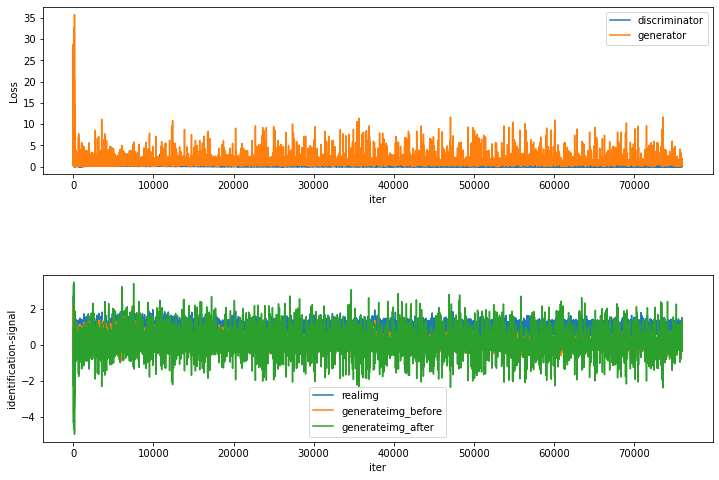

In [14]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [15]:
#nz=500
chlist = [500, 512, 256, 128, 64, 32, 3]
klist = [4, 4, 4, 4, 4, 4]
strdlist = [1, 2, 2, 2, 2, 2]
padlist = [0, 1, 1, 1, 1, 1]
opadlist = [0, 0, 0, 0, 0, 0]

gene = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)
summary(model = gene, input_size = (1, 500, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 3, 128, 128]          --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 512, 4, 4]            --
│    │    └─Sequential: 3-1                   [1, 512, 4, 4]            --
│    │    │    └─ConvTranspose2d: 4-1         [1, 512, 4, 4]            4,096,512
│    │    │    └─BatchNorm2d: 4-2             [1, 512, 4, 4]            1,024
│    │    │    └─ReLU: 4-3                    [1, 512, 4, 4]            --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 256, 8, 8]            --
│    │    └─Sequential: 3-2                   [1, 256, 8, 8]            --
│    │    │    └─ConvTranspose2d: 4-4         [1, 256, 8, 8]            2,097,408
│    │    │    └─BatchNorm2d: 4-5             [1, 256, 8, 8]            512
│    │    │    └─ReLU: 4-6                    [1, 256, 8, 8]            --
│ 

In [16]:
chlist = [3, 32, 64, 128, 256, 512, 1]
klist = [4, 4, 4, 4, 4, 4]
strdlist = [2, 2, 2, 2, 2, 1]
padlist = [1, 1, 1, 1, 1, 0]
ngsllist = [0.2, 0.2, 0.2, 0.2, 0.2, 0]

disc = ganmd.Dscrmntr_notsigmoid(chlist, klist, strdlist, padlist, ngsllist)
summary(model = disc, input_size = (1, 3, 128, 128), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Dscrmntr_notsigmoid                      --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 32, 64, 64]           --
│    │    └─Sequential: 3-1              [1, 32, 64, 64]           --
│    │    │    └─Conv2d: 4-1             [1, 32, 64, 64]           1,568
│    │    │    └─LeakyReLU: 4-2          [1, 32, 64, 64]           --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 64, 32, 32]           --
│    │    └─Sequential: 3-2              [1, 64, 32, 32]           --
│    │    │    └─Conv2d: 4-3             [1, 64, 32, 32]           32,832
│    │    │    └─BatchNorm2d: 4-4        [1, 64, 32, 32]           128
│    │    │    └─LeakyReLU: 4-5          [1, 64, 32, 32]           --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 128, 16, 16]          --
│    │    └─Sequential: 3-3              [1, 128, 16, 16]          --
│    │ 

In [17]:
criterion = nn.MSELoss()    # 損失関数は平均二乗誤差
nz = 500
beta1 = 0.5

# 生成器のエポックごとの画像生成に使用する確認用の固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device) 
lr = 0.0002
# オプティマイザ−のセットアップ
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gene.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [18]:
epochs = 2000
outf = '../GAN/LSGAN/oxford_pet_cat_rot/nz500'
dispinterval = 30
testgen_interval = 100


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dataloader, device, nz, disc, gene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval, 
                                                                     testgen_interval, fixed_noise, outf)

[1/2000][1/38] Loss_D: 1.635 Loss_G: 3.903 D(x): -0.200 D(G(z)): -0.116/2.973
[1/2000][31/38] Loss_D: 0.238 Loss_G: 1.961 D(x): 0.722 D(G(z)): -0.231/-0.387
-----------エポック1--------------
epochtime:0.2279分
[2/2000][1/38] Loss_D: 0.287 Loss_G: 1.475 D(x): 0.707 D(G(z)): -0.137/-0.198
[2/2000][31/38] Loss_D: 0.311 Loss_G: 10.997 D(x): 0.856 D(G(z)): 0.470/-2.314
-----------エポック2--------------
epochtime:0.2233分
[3/2000][1/38] Loss_D: 0.203 Loss_G: 0.988 D(x): 0.750 D(G(z)): -0.290/0.012
[3/2000][31/38] Loss_D: 0.046 Loss_G: 1.020 D(x): 1.014 D(G(z)): 0.178/-0.009
-----------エポック3--------------
epochtime:0.2237分
[4/2000][1/38] Loss_D: 0.104 Loss_G: 1.507 D(x): 1.109 D(G(z)): 0.209/-0.227
[4/2000][31/38] Loss_D: 0.128 Loss_G: 1.587 D(x): 0.872 D(G(z)): -0.297/-0.259
-----------エポック4--------------
epochtime:0.2237分
[5/2000][1/38] Loss_D: 0.149 Loss_G: 2.218 D(x): 1.065 D(G(z)): 0.304/-0.488
[5/2000][31/38] Loss_D: 2.443 Loss_G: 0.013 D(x): 0.689 D(G(z)): -1.505/0.894
-----------エポック5--------

-----------エポック40--------------
epochtime:0.2227分
[41/2000][1/38] Loss_D: 1.045 Loss_G: 0.511 D(x): 1.105 D(G(z)): 0.717/0.499
[41/2000][31/38] Loss_D: 0.054 Loss_G: 1.386 D(x): 0.916 D(G(z)): 0.037/-0.169
-----------エポック41--------------
epochtime:0.2240分
[42/2000][1/38] Loss_D: 0.316 Loss_G: 0.177 D(x): 0.669 D(G(z)): -0.369/0.669
[42/2000][31/38] Loss_D: 0.209 Loss_G: 0.902 D(x): 0.770 D(G(z)): -0.244/0.059
-----------エポック42--------------
epochtime:0.2232分
[43/2000][1/38] Loss_D: 0.472 Loss_G: 2.333 D(x): 1.309 D(G(z)): 0.485/-0.516
[43/2000][31/38] Loss_D: 0.034 Loss_G: 1.151 D(x): 1.070 D(G(z)): 0.124/-0.068
-----------エポック43--------------
epochtime:0.2242分
[44/2000][1/38] Loss_D: 1.507 Loss_G: 1.453 D(x): 1.610 D(G(z)): 1.030/-0.187
[44/2000][31/38] Loss_D: 0.055 Loss_G: 1.103 D(x): 0.912 D(G(z)): -0.093/-0.048
-----------エポック44--------------
epochtime:0.2248分
[45/2000][1/38] Loss_D: 0.324 Loss_G: 1.488 D(x): 1.244 D(G(z)): 0.475/-0.209
[45/2000][31/38] Loss_D: 0.046 Loss_G: 0.977

-----------エポック80--------------
epochtime:0.2237分
[81/2000][1/38] Loss_D: 0.503 Loss_G: 1.598 D(x): 0.982 D(G(z)): 0.646/-0.249
[81/2000][31/38] Loss_D: 0.577 Loss_G: 0.067 D(x): 0.305 D(G(z)): -0.187/0.794
-----------エポック81--------------
epochtime:0.2240分
[82/2000][1/38] Loss_D: 0.227 Loss_G: 1.120 D(x): 0.910 D(G(z)): 0.408/-0.048
[82/2000][31/38] Loss_D: 0.249 Loss_G: 0.688 D(x): 0.631 D(G(z)): 0.276/0.182
-----------エポック82--------------
epochtime:0.2227分
[83/2000][1/38] Loss_D: 1.043 Loss_G: 1.570 D(x): 1.272 D(G(z)): 0.960/-0.242
[83/2000][31/38] Loss_D: 0.077 Loss_G: 1.090 D(x): 0.870 D(G(z)): 0.148/-0.039
-----------エポック83--------------
epochtime:0.2222分
[84/2000][1/38] Loss_D: 4.731 Loss_G: 1.941 D(x): 1.988 D(G(z)): 1.902/-0.366
[84/2000][31/38] Loss_D: 0.148 Loss_G: 0.837 D(x): 0.724 D(G(z)): 0.195/0.092
-----------エポック84--------------
epochtime:0.2235分
[85/2000][1/38] Loss_D: 1.363 Loss_G: 1.094 D(x): 1.398 D(G(z)): 1.073/-0.033
[85/2000][31/38] Loss_D: 0.157 Loss_G: 0.966 D

[120/2000][31/38] Loss_D: 0.247 Loss_G: 0.545 D(x): 0.676 D(G(z)): 0.317/0.268
-----------エポック120--------------
epochtime:0.2240分
[121/2000][1/38] Loss_D: 2.730 Loss_G: 3.221 D(x): 2.006 D(G(z)): 1.258/-0.754
[121/2000][31/38] Loss_D: 0.294 Loss_G: 0.918 D(x): 0.951 D(G(z)): 0.501/0.049
-----------エポック121--------------
epochtime:0.2235分
[122/2000][1/38] Loss_D: 0.454 Loss_G: 1.320 D(x): 1.045 D(G(z)): 0.537/-0.138
[122/2000][31/38] Loss_D: 0.192 Loss_G: 1.181 D(x): 0.927 D(G(z)): 0.344/-0.079
-----------エポック122--------------
epochtime:0.2242分
[123/2000][1/38] Loss_D: 0.812 Loss_G: 1.682 D(x): 0.883 D(G(z)): 0.509/-0.247
[123/2000][31/38] Loss_D: 0.115 Loss_G: 1.081 D(x): 0.759 D(G(z)): -0.011/-0.029
-----------エポック123--------------
epochtime:0.2248分
[124/2000][1/38] Loss_D: 3.218 Loss_G: 1.392 D(x): 1.772 D(G(z)): 1.431/-0.071
[124/2000][31/38] Loss_D: 0.273 Loss_G: 0.441 D(x): 0.578 D(G(z)): 0.246/0.344
-----------エポック124--------------
epochtime:0.2237分
[125/2000][1/38] Loss_D: 0.761 

-----------エポック159--------------
epochtime:0.2240分
[160/2000][1/38] Loss_D: 2.863 Loss_G: 1.309 D(x): 1.868 D(G(z)): 1.397/-0.124
[160/2000][31/38] Loss_D: 0.194 Loss_G: 0.774 D(x): 0.665 D(G(z)): 0.170/0.127
-----------エポック160--------------
epochtime:0.2237分
[161/2000][1/38] Loss_D: 0.817 Loss_G: 0.889 D(x): 0.702 D(G(z)): 0.663/0.080
[161/2000][31/38] Loss_D: 0.217 Loss_G: 0.723 D(x): 0.743 D(G(z)): 0.311/0.155
-----------エポック161--------------
epochtime:0.2244分
[162/2000][1/38] Loss_D: 3.027 Loss_G: 2.072 D(x): 1.767 D(G(z)): 1.458/-0.420
[162/2000][31/38] Loss_D: 0.300 Loss_G: 0.576 D(x): 0.609 D(G(z)): 0.319/0.253
-----------エポック162--------------
epochtime:0.2240分
[163/2000][1/38] Loss_D: 1.437 Loss_G: 1.195 D(x): 1.527 D(G(z)): 1.021/-0.073
[163/2000][31/38] Loss_D: 0.219 Loss_G: 0.720 D(x): 0.680 D(G(z)): 0.222/0.158
-----------エポック163--------------
epochtime:0.2235分
[164/2000][1/38] Loss_D: 0.493 Loss_G: 1.318 D(x): 0.881 D(G(z)): 0.610/-0.135
[164/2000][31/38] Loss_D: 0.405 Los

[199/2000][1/38] Loss_D: 4.572 Loss_G: 3.342 D(x): 1.997 D(G(z)): 1.760/-0.672
[199/2000][31/38] Loss_D: 0.199 Loss_G: 0.952 D(x): 0.755 D(G(z)): 0.277/0.040
-----------エポック199--------------
epochtime:0.2245分
[200/2000][1/38] Loss_D: 0.783 Loss_G: 0.904 D(x): 1.086 D(G(z)): 0.754/0.081
[200/2000][31/38] Loss_D: 0.177 Loss_G: 0.909 D(x): 0.721 D(G(z)): 0.236/0.054
-----------エポック200--------------
epochtime:0.2271分
[201/2000][1/38] Loss_D: 0.368 Loss_G: 0.901 D(x): 1.163 D(G(z)): 0.514/0.064
[201/2000][31/38] Loss_D: 0.157 Loss_G: 0.921 D(x): 0.735 D(G(z)): 0.185/0.048
-----------エポック201--------------
epochtime:0.2229分
[202/2000][1/38] Loss_D: 0.630 Loss_G: 1.250 D(x): 1.140 D(G(z)): 0.703/-0.100
[202/2000][31/38] Loss_D: 0.153 Loss_G: 0.998 D(x): 0.729 D(G(z)): 0.128/0.012
-----------エポック202--------------
epochtime:0.2253分
[203/2000][1/38] Loss_D: 0.672 Loss_G: 0.655 D(x): 0.348 D(G(z)): 0.070/0.272
[203/2000][31/38] Loss_D: 0.350 Loss_G: 1.508 D(x): 0.967 D(G(z)): 0.547/-0.219
--------

[238/2000][31/38] Loss_D: 0.119 Loss_G: 1.131 D(x): 0.840 D(G(z)): 0.193/-0.051
-----------エポック238--------------
epochtime:0.2227分
[239/2000][1/38] Loss_D: 2.815 Loss_G: 1.452 D(x): 1.812 D(G(z)): 1.228/-0.128
[239/2000][31/38] Loss_D: 0.296 Loss_G: 1.387 D(x): 0.986 D(G(z)): 0.499/-0.169
-----------エポック239--------------
epochtime:0.2238分
[240/2000][1/38] Loss_D: 0.197 Loss_G: 0.656 D(x): 0.644 D(G(z)): 0.104/0.202
[240/2000][31/38] Loss_D: 0.183 Loss_G: 1.247 D(x): 0.998 D(G(z)): 0.397/-0.107
-----------エポック240--------------
epochtime:0.2231分
[241/2000][1/38] Loss_D: 0.242 Loss_G: 0.700 D(x): 0.663 D(G(z)): 0.098/0.186
[241/2000][31/38] Loss_D: 0.265 Loss_G: 1.199 D(x): 0.702 D(G(z)): 0.364/-0.085
-----------エポック241--------------
epochtime:0.2235分
[242/2000][1/38] Loss_D: 1.689 Loss_G: 2.622 D(x): 1.566 D(G(z)): 1.074/-0.575
[242/2000][31/38] Loss_D: 0.146 Loss_G: 0.831 D(x): 0.791 D(G(z)): 0.270/0.101
-----------エポック242--------------
epochtime:0.2232分
[243/2000][1/38] Loss_D: 0.786 L

-----------エポック277--------------
epochtime:0.2229分
[278/2000][1/38] Loss_D: 1.663 Loss_G: 0.553 D(x): 1.450 D(G(z)): 1.145/0.290
[278/2000][31/38] Loss_D: 0.104 Loss_G: 0.917 D(x): 0.728 D(G(z)): 0.052/0.049
-----------エポック278--------------
epochtime:0.2235分
[279/2000][1/38] Loss_D: 0.359 Loss_G: 0.464 D(x): 0.527 D(G(z)): -0.016/0.341
[279/2000][31/38] Loss_D: 0.110 Loss_G: 0.707 D(x): 0.745 D(G(z)): -0.092/0.167
-----------エポック279--------------
epochtime:0.2224分
[280/2000][1/38] Loss_D: 1.360 Loss_G: 2.005 D(x): 1.600 D(G(z)): 0.938/-0.403
[280/2000][31/38] Loss_D: 0.343 Loss_G: 1.096 D(x): 0.849 D(G(z)): 0.511/-0.041
-----------エポック280--------------
epochtime:0.2229分
[281/2000][1/38] Loss_D: 1.238 Loss_G: 1.749 D(x): 1.310 D(G(z)): 0.984/-0.296
[281/2000][31/38] Loss_D: 0.148 Loss_G: 0.757 D(x): 0.692 D(G(z)): 0.021/0.137
-----------エポック281--------------
epochtime:0.2245分
[282/2000][1/38] Loss_D: 0.349 Loss_G: 0.936 D(x): 1.046 D(G(z)): 0.363/0.053
[282/2000][31/38] Loss_D: 0.157 Lo

[317/2000][1/38] Loss_D: 0.251 Loss_G: 1.007 D(x): 0.794 D(G(z)): 0.306/0.021
[317/2000][31/38] Loss_D: 0.151 Loss_G: 0.878 D(x): 0.731 D(G(z)): 0.238/0.068
-----------エポック317--------------
epochtime:0.2224分
[318/2000][1/38] Loss_D: 1.656 Loss_G: 1.946 D(x): 1.631 D(G(z)): 0.992/-0.363
[318/2000][31/38] Loss_D: 0.146 Loss_G: 0.915 D(x): 0.685 D(G(z)): -0.054/0.050
-----------エポック318--------------
epochtime:0.2240分
[319/2000][1/38] Loss_D: 1.138 Loss_G: 1.025 D(x): 1.257 D(G(z)): 0.994/0.012
[319/2000][31/38] Loss_D: 0.113 Loss_G: 1.132 D(x): 0.785 D(G(z)): 0.200/-0.055
-----------エポック319--------------
epochtime:0.2232分
[320/2000][1/38] Loss_D: 1.288 Loss_G: 1.358 D(x): 1.366 D(G(z)): 1.047/-0.140
[320/2000][31/38] Loss_D: 0.068 Loss_G: 1.097 D(x): 0.819 D(G(z)): 0.050/-0.038
-----------エポック320--------------
epochtime:0.2248分
[321/2000][1/38] Loss_D: 0.198 Loss_G: 0.844 D(x): 1.152 D(G(z)): 0.301/0.097
[321/2000][31/38] Loss_D: 0.027 Loss_G: 1.163 D(x): 0.980 D(G(z)): 0.047/-0.072
-----

[356/2000][31/38] Loss_D: 0.076 Loss_G: 1.035 D(x): 0.962 D(G(z)): 0.209/-0.012
-----------エポック356--------------
epochtime:0.2222分
[357/2000][1/38] Loss_D: 2.117 Loss_G: 1.294 D(x): 1.616 D(G(z)): 1.188/-0.069
[357/2000][31/38] Loss_D: 0.318 Loss_G: 0.499 D(x): 0.506 D(G(z)): -0.165/0.302
-----------エポック357--------------
epochtime:0.2242分
[358/2000][1/38] Loss_D: 0.132 Loss_G: 0.861 D(x): 0.722 D(G(z)): -0.042/0.083
[358/2000][31/38] Loss_D: 0.252 Loss_G: 0.746 D(x): 0.992 D(G(z)): 0.472/0.143
-----------エポック358--------------
epochtime:0.2237分
[359/2000][1/38] Loss_D: 0.213 Loss_G: 0.891 D(x): 1.173 D(G(z)): 0.165/0.077
[359/2000][31/38] Loss_D: 0.216 Loss_G: 0.404 D(x): 0.617 D(G(z)): 0.213/0.373
-----------エポック359--------------
epochtime:0.2227分
[360/2000][1/38] Loss_D: 0.700 Loss_G: 1.175 D(x): 1.271 D(G(z)): 0.753/-0.076
[360/2000][31/38] Loss_D: 0.247 Loss_G: 0.511 D(x): 0.558 D(G(z)): 0.118/0.291
-----------エポック360--------------
epochtime:0.2248分
[361/2000][1/38] Loss_D: 0.267 Lo

-----------エポック395--------------
epochtime:0.2225分
[396/2000][1/38] Loss_D: 2.216 Loss_G: 0.606 D(x): 1.487 D(G(z)): 1.158/0.248
[396/2000][31/38] Loss_D: 0.070 Loss_G: 1.274 D(x): 1.145 D(G(z)): 0.081/-0.120
-----------エポック396--------------
epochtime:0.2245分
[397/2000][1/38] Loss_D: 0.263 Loss_G: 0.816 D(x): 0.581 D(G(z)): -0.022/0.116
[397/2000][31/38] Loss_D: 0.123 Loss_G: 0.780 D(x): 0.823 D(G(z)): 0.231/0.124
-----------エポック397--------------
epochtime:0.2245分
[398/2000][1/38] Loss_D: 0.542 Loss_G: 0.825 D(x): 0.463 D(G(z)): -0.404/0.112
[398/2000][31/38] Loss_D: 0.122 Loss_G: 0.776 D(x): 0.871 D(G(z)): 0.271/0.125
-----------エポック398--------------
epochtime:0.2235分
[399/2000][1/38] Loss_D: 0.319 Loss_G: 0.632 D(x): 0.581 D(G(z)): -0.213/0.223
[399/2000][31/38] Loss_D: 0.105 Loss_G: 0.787 D(x): 0.727 D(G(z)): -0.012/0.117
-----------エポック399--------------
epochtime:0.2235分
[400/2000][1/38] Loss_D: 0.998 Loss_G: 1.063 D(x): 1.583 D(G(z)): 0.711/-0.002
[400/2000][31/38] Loss_D: 0.067 L

[435/2000][1/38] Loss_D: 0.051 Loss_G: 1.213 D(x): 1.034 D(G(z)): 0.107/-0.094
[435/2000][31/38] Loss_D: 0.048 Loss_G: 1.113 D(x): 1.158 D(G(z)): 0.025/-0.051
-----------エポック435--------------
epochtime:0.2240分
[436/2000][1/38] Loss_D: 0.523 Loss_G: 0.429 D(x): 0.480 D(G(z)): -0.336/0.356
[436/2000][31/38] Loss_D: 0.142 Loss_G: 1.398 D(x): 1.073 D(G(z)): 0.334/-0.179
-----------エポック436--------------
epochtime:0.2232分
[437/2000][1/38] Loss_D: 0.449 Loss_G: 1.374 D(x): 1.353 D(G(z)): 0.536/-0.168
[437/2000][31/38] Loss_D: 0.061 Loss_G: 1.100 D(x): 0.825 D(G(z)): 0.058/-0.044
-----------エポック437--------------
epochtime:0.2237分
[438/2000][1/38] Loss_D: 1.938 Loss_G: 2.916 D(x): 1.819 D(G(z)): 1.076/-0.699
[438/2000][31/38] Loss_D: 0.183 Loss_G: 0.805 D(x): 0.949 D(G(z)): 0.372/0.108
-----------エポック438--------------
epochtime:0.2238分
[439/2000][1/38] Loss_D: 1.513 Loss_G: 1.044 D(x): 1.152 D(G(z)): 1.129/0.007
[439/2000][31/38] Loss_D: 0.076 Loss_G: 1.376 D(x): 0.878 D(G(z)): 0.151/-0.168
---

[474/2000][31/38] Loss_D: 0.136 Loss_G: 0.820 D(x): 0.725 D(G(z)): -0.146/0.100
-----------エポック474--------------
epochtime:0.2229分
[475/2000][1/38] Loss_D: 0.100 Loss_G: 1.243 D(x): 1.111 D(G(z)): 0.245/-0.106
[475/2000][31/38] Loss_D: 0.065 Loss_G: 1.089 D(x): 0.869 D(G(z)): 0.126/-0.038
-----------エポック475--------------
epochtime:0.2249分
[476/2000][1/38] Loss_D: 1.334 Loss_G: 1.001 D(x): 1.295 D(G(z)): 1.052/0.011
[476/2000][31/38] Loss_D: 0.086 Loss_G: 1.352 D(x): 1.160 D(G(z)): 0.167/-0.158
-----------エポック476--------------
epochtime:0.2248分
[477/2000][1/38] Loss_D: 0.123 Loss_G: 0.789 D(x): 0.951 D(G(z)): 0.217/0.130
[477/2000][31/38] Loss_D: 0.059 Loss_G: 1.076 D(x): 0.946 D(G(z)): 0.165/-0.033
-----------エポック477--------------
epochtime:0.2248分
[478/2000][1/38] Loss_D: 0.062 Loss_G: 1.050 D(x): 0.893 D(G(z)): 0.013/-0.010
[478/2000][31/38] Loss_D: 0.229 Loss_G: 1.333 D(x): 1.159 D(G(z)): 0.427/-0.150
-----------エポック478--------------
epochtime:0.2229分
[479/2000][1/38] Loss_D: 0.169 

-----------エポック513--------------
epochtime:0.2228分
[514/2000][1/38] Loss_D: 0.177 Loss_G: 0.425 D(x): 0.774 D(G(z)): 0.071/0.368
[514/2000][31/38] Loss_D: 0.152 Loss_G: 1.229 D(x): 0.922 D(G(z)): 0.332/-0.099
-----------エポック514--------------
epochtime:0.2242分
[515/2000][1/38] Loss_D: 0.958 Loss_G: 0.850 D(x): 0.378 D(G(z)): -0.677/0.086
[515/2000][31/38] Loss_D: 0.103 Loss_G: 0.788 D(x): 0.780 D(G(z)): 0.157/0.117
-----------エポック515--------------
epochtime:0.2236分
[516/2000][1/38] Loss_D: 0.903 Loss_G: 0.848 D(x): 1.297 D(G(z)): 0.877/0.097
[516/2000][31/38] Loss_D: 0.098 Loss_G: 0.908 D(x): 1.010 D(G(z)): 0.264/0.050
-----------エポック516--------------
epochtime:0.2234分
[517/2000][1/38] Loss_D: 0.120 Loss_G: 0.927 D(x): 0.908 D(G(z)): -0.014/0.054
[517/2000][31/38] Loss_D: 0.236 Loss_G: 1.320 D(x): 1.339 D(G(z)): 0.320/-0.146
-----------エポック517--------------
epochtime:0.2239分
[518/2000][1/38] Loss_D: 0.626 Loss_G: 1.620 D(x): 1.421 D(G(z)): 0.542/-0.265
[518/2000][31/38] Loss_D: 0.092 Lo

[553/2000][1/38] Loss_D: 0.604 Loss_G: 1.266 D(x): 1.270 D(G(z)): 0.676/-0.101
[553/2000][31/38] Loss_D: 0.054 Loss_G: 1.295 D(x): 1.156 D(G(z)): 0.109/-0.135
-----------エポック553--------------
epochtime:0.2244分
[554/2000][1/38] Loss_D: 0.219 Loss_G: 1.421 D(x): 1.100 D(G(z)): 0.410/-0.187
[554/2000][31/38] Loss_D: 0.039 Loss_G: 1.085 D(x): 0.873 D(G(z)): -0.012/-0.037
-----------エポック554--------------
epochtime:0.2230分
[555/2000][1/38] Loss_D: 0.100 Loss_G: 1.008 D(x): 1.026 D(G(z)): -0.003/0.006
[555/2000][31/38] Loss_D: 0.243 Loss_G: 0.900 D(x): 0.626 D(G(z)): -0.270/0.057
-----------エポック555--------------
epochtime:0.2238分
[556/2000][1/38] Loss_D: 0.193 Loss_G: 1.810 D(x): 1.310 D(G(z)): 0.203/-0.337
[556/2000][31/38] Loss_D: 0.127 Loss_G: 1.300 D(x): 1.006 D(G(z)): -0.322/-0.136
-----------エポック556--------------
epochtime:0.2247分
[557/2000][1/38] Loss_D: 0.233 Loss_G: 0.920 D(x): 1.153 D(G(z)): 0.225/0.064
[557/2000][31/38] Loss_D: 0.168 Loss_G: 1.169 D(x): 1.020 D(G(z)): 0.378/-0.077


[592/2000][31/38] Loss_D: 0.079 Loss_G: 1.023 D(x): 0.995 D(G(z)): 0.221/-0.008
-----------エポック592--------------
epochtime:0.2241分
[593/2000][1/38] Loss_D: 0.256 Loss_G: 0.855 D(x): 0.941 D(G(z)): 0.305/0.089
[593/2000][31/38] Loss_D: 0.031 Loss_G: 1.221 D(x): 1.028 D(G(z)): 0.072/-0.100
-----------エポック593--------------
epochtime:0.2239分
[594/2000][1/38] Loss_D: 0.051 Loss_G: 1.061 D(x): 0.996 D(G(z)): 0.071/-0.021
[594/2000][31/38] Loss_D: 0.104 Loss_G: 1.015 D(x): 1.084 D(G(z)): 0.283/-0.004
-----------エポック594--------------
epochtime:0.2236分
[595/2000][1/38] Loss_D: 0.361 Loss_G: 0.746 D(x): 0.728 D(G(z)): -0.136/0.158
[595/2000][31/38] Loss_D: 0.102 Loss_G: 0.725 D(x): 0.739 D(G(z)): 0.056/0.154
-----------エポック595--------------
epochtime:0.2250分
[596/2000][1/38] Loss_D: 0.821 Loss_G: 1.635 D(x): 1.487 D(G(z)): 0.737/-0.268
[596/2000][31/38] Loss_D: 0.112 Loss_G: 1.178 D(x): 1.282 D(G(z)): 0.120/-0.083
-----------エポック596--------------
epochtime:0.2236分
[597/2000][1/38] Loss_D: 1.295 

-----------エポック631--------------
epochtime:0.2233分
[632/2000][1/38] Loss_D: 0.212 Loss_G: 0.647 D(x): 0.811 D(G(z)): 0.208/0.232
[632/2000][31/38] Loss_D: 0.023 Loss_G: 1.072 D(x): 0.986 D(G(z)): 0.011/-0.030
-----------エポック632--------------
epochtime:0.2245分
[633/2000][1/38] Loss_D: 0.783 Loss_G: 1.184 D(x): 1.280 D(G(z)): 0.695/-0.057
[633/2000][31/38] Loss_D: 0.164 Loss_G: 0.778 D(x): 1.085 D(G(z)): 0.370/0.122
-----------エポック633--------------
epochtime:0.2241分
[634/2000][1/38] Loss_D: 0.846 Loss_G: 1.046 D(x): 1.216 D(G(z)): 0.528/0.044
[634/2000][31/38] Loss_D: 0.038 Loss_G: 1.547 D(x): 1.062 D(G(z)): 0.082/-0.239
-----------エポック634--------------
epochtime:0.2261分
[635/2000][1/38] Loss_D: 0.163 Loss_G: 0.861 D(x): 0.845 D(G(z)): 0.268/0.086
[635/2000][31/38] Loss_D: 0.098 Loss_G: 0.698 D(x): 0.740 D(G(z)): -0.112/0.170
-----------エポック635--------------
epochtime:0.2248分
[636/2000][1/38] Loss_D: 0.164 Loss_G: 1.373 D(x): 1.013 D(G(z)): 0.364/-0.165
[636/2000][31/38] Loss_D: 0.107 Lo

[671/2000][1/38] Loss_D: 0.174 Loss_G: 0.980 D(x): 1.106 D(G(z)): 0.322/0.020
[671/2000][31/38] Loss_D: 0.076 Loss_G: 1.054 D(x): 0.922 D(G(z)): 0.229/-0.023
-----------エポック671--------------
epochtime:0.2244分
[672/2000][1/38] Loss_D: 0.693 Loss_G: 1.350 D(x): 1.227 D(G(z)): 0.742/-0.141
[672/2000][31/38] Loss_D: 0.190 Loss_G: 0.710 D(x): 0.607 D(G(z)): -0.053/0.165
-----------エポック672--------------
epochtime:0.2261分
[673/2000][1/38] Loss_D: 0.586 Loss_G: 1.017 D(x): 1.181 D(G(z)): 0.651/0.040
[673/2000][31/38] Loss_D: 0.126 Loss_G: 1.533 D(x): 1.167 D(G(z)): 0.265/-0.234
-----------エポック673--------------
epochtime:0.2233分
[674/2000][1/38] Loss_D: 1.520 Loss_G: 1.356 D(x): 1.650 D(G(z)): 1.025/-0.138
[674/2000][31/38] Loss_D: 0.136 Loss_G: 1.322 D(x): 1.099 D(G(z)): 0.323/-0.146
-----------エポック674--------------
epochtime:0.2239分
[675/2000][1/38] Loss_D: 0.351 Loss_G: 1.190 D(x): 1.346 D(G(z)): 0.414/-0.084
[675/2000][31/38] Loss_D: 0.131 Loss_G: 0.776 D(x): 0.708 D(G(z)): 0.161/0.124
----

[710/2000][31/38] Loss_D: 0.090 Loss_G: 0.961 D(x): 0.945 D(G(z)): 0.268/0.022
-----------エポック710--------------
epochtime:0.2210分
[711/2000][1/38] Loss_D: 0.444 Loss_G: 1.047 D(x): 1.265 D(G(z)): 0.581/-0.015
[711/2000][31/38] Loss_D: 0.045 Loss_G: 1.016 D(x): 0.885 D(G(z)): 0.080/-0.003
-----------エポック711--------------
epochtime:0.2217分
[712/2000][1/38] Loss_D: 0.876 Loss_G: 1.292 D(x): 1.415 D(G(z)): 0.816/-0.128
[712/2000][31/38] Loss_D: 0.035 Loss_G: 1.205 D(x): 1.035 D(G(z)): 0.090/-0.094
-----------エポック712--------------
epochtime:0.2212分
[713/2000][1/38] Loss_D: 0.479 Loss_G: 0.465 D(x): 0.466 D(G(z)): -0.319/0.350
[713/2000][31/38] Loss_D: 0.023 Loss_G: 0.918 D(x): 0.968 D(G(z)): 0.077/0.045
-----------エポック713--------------
epochtime:0.2207分
[714/2000][1/38] Loss_D: 0.936 Loss_G: 0.852 D(x): 1.315 D(G(z)): 0.883/0.093
[714/2000][31/38] Loss_D: 0.046 Loss_G: 0.861 D(x): 0.912 D(G(z)): 0.128/0.079
-----------エポック714--------------
epochtime:0.2217分
[715/2000][1/38] Loss_D: 0.099 Lo

-----------エポック749--------------
epochtime:0.2212分
[750/2000][1/38] Loss_D: 0.611 Loss_G: 1.179 D(x): 1.480 D(G(z)): 0.535/-0.072
[750/2000][31/38] Loss_D: 0.061 Loss_G: 0.818 D(x): 0.798 D(G(z)): -0.036/0.099
-----------エポック750--------------
epochtime:0.2208分
[751/2000][1/38] Loss_D: 0.121 Loss_G: 0.751 D(x): 0.881 D(G(z)): 0.175/0.148
[751/2000][31/38] Loss_D: 0.086 Loss_G: 0.859 D(x): 0.996 D(G(z)): 0.251/0.078
-----------エポック751--------------
epochtime:0.2229分
[752/2000][1/38] Loss_D: 0.434 Loss_G: 0.974 D(x): 0.712 D(G(z)): -0.253/0.037
[752/2000][31/38] Loss_D: 0.021 Loss_G: 1.071 D(x): 1.066 D(G(z)): -0.020/-0.031
-----------エポック752--------------
epochtime:0.2296分
[753/2000][1/38] Loss_D: 0.284 Loss_G: 1.637 D(x): 1.200 D(G(z)): 0.468/-0.271
[753/2000][31/38] Loss_D: 0.121 Loss_G: 1.332 D(x): 1.145 D(G(z)): 0.292/-0.151
-----------エポック753--------------
epochtime:0.2246分
[754/2000][1/38] Loss_D: 0.141 Loss_G: 1.010 D(x): 0.918 D(G(z)): 0.259/0.008
[754/2000][31/38] Loss_D: 0.021 

[789/2000][1/38] Loss_D: 0.389 Loss_G: 1.465 D(x): 1.173 D(G(z)): 0.538/-0.203
[789/2000][31/38] Loss_D: 0.044 Loss_G: 0.803 D(x): 1.023 D(G(z)): 0.151/0.108
-----------エポック789--------------
epochtime:0.2211分
[790/2000][1/38] Loss_D: 0.150 Loss_G: 0.659 D(x): 0.738 D(G(z)): 0.232/0.194
[790/2000][31/38] Loss_D: 0.018 Loss_G: 0.851 D(x): 0.950 D(G(z)): 0.017/0.080
-----------エポック790--------------
epochtime:0.2213分
[791/2000][1/38] Loss_D: 0.511 Loss_G: 1.314 D(x): 1.239 D(G(z)): 0.617/-0.134
[791/2000][31/38] Loss_D: 0.021 Loss_G: 0.991 D(x): 0.983 D(G(z)): -0.043/0.009
-----------エポック791--------------
epochtime:0.2209分
[792/2000][1/38] Loss_D: 0.059 Loss_G: 1.025 D(x): 0.887 D(G(z)): -0.048/-0.007
[792/2000][31/38] Loss_D: 0.039 Loss_G: 0.764 D(x): 0.920 D(G(z)): 0.143/0.129
-----------エポック792--------------
epochtime:0.2201分
[793/2000][1/38] Loss_D: 0.079 Loss_G: 0.663 D(x): 0.808 D(G(z)): 0.057/0.195
[793/2000][31/38] Loss_D: 0.050 Loss_G: 1.002 D(x): 1.085 D(G(z)): 0.175/0.001
------

[828/2000][31/38] Loss_D: 0.157 Loss_G: 0.603 D(x): 0.676 D(G(z)): 0.172/0.227
-----------エポック828--------------
epochtime:0.2207分
[829/2000][1/38] Loss_D: 0.040 Loss_G: 0.885 D(x): 0.954 D(G(z)): -0.050/0.068
[829/2000][31/38] Loss_D: 0.114 Loss_G: 1.104 D(x): 0.894 D(G(z)): 0.293/-0.048
-----------エポック829--------------
epochtime:0.2213分
[830/2000][1/38] Loss_D: 0.346 Loss_G: 0.958 D(x): 1.037 D(G(z)): 0.559/0.029
[830/2000][31/38] Loss_D: 0.057 Loss_G: 0.872 D(x): 0.812 D(G(z)): -0.073/0.069
-----------エポック830--------------
epochtime:0.2212分
[831/2000][1/38] Loss_D: 0.301 Loss_G: 0.909 D(x): 0.663 D(G(z)): -0.402/0.060
[831/2000][31/38] Loss_D: 0.034 Loss_G: 0.785 D(x): 0.932 D(G(z)): -0.122/0.117
-----------エポック831--------------
epochtime:0.2210分
[832/2000][1/38] Loss_D: 0.102 Loss_G: 0.783 D(x): 0.723 D(G(z)): -0.065/0.121
[832/2000][31/38] Loss_D: 0.045 Loss_G: 0.955 D(x): 1.054 D(G(z)): 0.154/0.025
-----------エポック832--------------
epochtime:0.2208分
[833/2000][1/38] Loss_D: 0.168 L

-----------エポック867--------------
epochtime:0.2213分
[868/2000][1/38] Loss_D: 0.205 Loss_G: 0.925 D(x): 0.756 D(G(z)): -0.185/0.050
[868/2000][31/38] Loss_D: 0.036 Loss_G: 1.019 D(x): 0.966 D(G(z)): 0.095/-0.006
-----------エポック868--------------
epochtime:0.2215分
[869/2000][1/38] Loss_D: 0.090 Loss_G: 1.418 D(x): 1.122 D(G(z)): 0.060/-0.181
[869/2000][31/38] Loss_D: 0.070 Loss_G: 0.980 D(x): 0.875 D(G(z)): -0.180/0.017
-----------エポック869--------------
epochtime:0.2211分
[870/2000][1/38] Loss_D: 0.311 Loss_G: 0.997 D(x): 1.238 D(G(z)): 0.468/0.015
[870/2000][31/38] Loss_D: 0.039 Loss_G: 1.097 D(x): 0.873 D(G(z)): 0.019/-0.043
-----------エポック870--------------
epochtime:0.2201分
[871/2000][1/38] Loss_D: 0.181 Loss_G: 0.835 D(x): 0.670 D(G(z)): -0.180/0.095
[871/2000][31/38] Loss_D: 0.063 Loss_G: 0.949 D(x): 0.798 D(G(z)): -0.088/0.029
-----------エポック871--------------
epochtime:0.2208分
[872/2000][1/38] Loss_D: 0.254 Loss_G: 0.894 D(x): 1.014 D(G(z)): 0.468/0.059
[872/2000][31/38] Loss_D: 0.032 

[907/2000][1/38] Loss_D: 0.199 Loss_G: 0.900 D(x): 0.721 D(G(z)): -0.313/0.056
[907/2000][31/38] Loss_D: 0.062 Loss_G: 1.232 D(x): 1.142 D(G(z)): 0.124/-0.106
-----------エポック907--------------
epochtime:0.2204分
[908/2000][1/38] Loss_D: 0.091 Loss_G: 1.276 D(x): 1.176 D(G(z)): 0.167/-0.123
[908/2000][31/38] Loss_D: 0.152 Loss_G: 1.197 D(x): 1.272 D(G(z)): 0.241/-0.091
-----------エポック908--------------
epochtime:0.2203分
[909/2000][1/38] Loss_D: 0.117 Loss_G: 0.825 D(x): 0.752 D(G(z)): -0.167/0.099
[909/2000][31/38] Loss_D: 0.048 Loss_G: 1.139 D(x): 1.181 D(G(z)): 0.065/-0.065
-----------エポック909--------------
epochtime:0.2207分
[910/2000][1/38] Loss_D: 0.260 Loss_G: 1.087 D(x): 1.215 D(G(z)): 0.435/-0.035
[910/2000][31/38] Loss_D: 0.142 Loss_G: 0.632 D(x): 0.654 D(G(z)): -0.047/0.212
-----------エポック910--------------
epochtime:0.2205分
[911/2000][1/38] Loss_D: 0.163 Loss_G: 0.822 D(x): 0.757 D(G(z)): -0.272/0.102
[911/2000][31/38] Loss_D: 0.069 Loss_G: 0.898 D(x): 0.776 D(G(z)): 0.030/0.055
--

[946/2000][31/38] Loss_D: 0.143 Loss_G: 0.687 D(x): 0.659 D(G(z)): -0.115/0.174
-----------エポック946--------------
epochtime:0.2214分
[947/2000][1/38] Loss_D: 0.147 Loss_G: 0.997 D(x): 1.191 D(G(z)): 0.263/0.007
[947/2000][31/38] Loss_D: 0.065 Loss_G: 0.779 D(x): 0.785 D(G(z)): 0.072/0.120
-----------エポック947--------------
epochtime:0.2203分
[948/2000][1/38] Loss_D: 0.374 Loss_G: 0.931 D(x): 0.578 D(G(z)): -0.338/0.056
[948/2000][31/38] Loss_D: 0.077 Loss_G: 0.836 D(x): 0.758 D(G(z)): -0.020/0.088
-----------エポック948--------------
epochtime:0.2206分
[949/2000][1/38] Loss_D: 0.180 Loss_G: 0.739 D(x): 1.080 D(G(z)): 0.391/0.150
[949/2000][31/38] Loss_D: 0.021 Loss_G: 1.182 D(x): 1.006 D(G(z)): -0.064/-0.084
-----------エポック949--------------
epochtime:0.2206分
[950/2000][1/38] Loss_D: 0.086 Loss_G: 1.189 D(x): 1.169 D(G(z)): 0.147/-0.086
[950/2000][31/38] Loss_D: 0.090 Loss_G: 0.654 D(x): 0.732 D(G(z)): 0.057/0.196
-----------エポック950--------------
epochtime:0.2209分
[951/2000][1/38] Loss_D: 0.081 L

-----------エポック985--------------
epochtime:0.2207分
[986/2000][1/38] Loss_D: 0.060 Loss_G: 1.214 D(x): 1.031 D(G(z)): 0.052/-0.094
[986/2000][31/38] Loss_D: 0.150 Loss_G: 1.046 D(x): 1.131 D(G(z)): 0.346/-0.020
-----------エポック986--------------
epochtime:0.2211分
[987/2000][1/38] Loss_D: 0.033 Loss_G: 1.198 D(x): 1.030 D(G(z)): 0.120/-0.090
[987/2000][31/38] Loss_D: 0.027 Loss_G: 0.939 D(x): 0.909 D(G(z)): -0.030/0.035
-----------エポック987--------------
epochtime:0.2222分
[988/2000][1/38] Loss_D: 0.058 Loss_G: 1.201 D(x): 1.089 D(G(z)): 0.175/-0.091
[988/2000][31/38] Loss_D: 0.055 Loss_G: 1.635 D(x): 1.036 D(G(z)): 0.202/-0.275
-----------エポック988--------------
epochtime:0.2204分
[989/2000][1/38] Loss_D: 0.095 Loss_G: 0.754 D(x): 0.797 D(G(z)): -0.059/0.144
[989/2000][31/38] Loss_D: 0.061 Loss_G: 0.938 D(x): 0.844 D(G(z)): 0.116/0.035
-----------エポック989--------------
epochtime:0.2202分
[990/2000][1/38] Loss_D: 0.388 Loss_G: 0.998 D(x): 1.226 D(G(z)): 0.558/0.006
[990/2000][31/38] Loss_D: 0.032 

-----------エポック1024--------------
epochtime:0.2208分
[1025/2000][1/38] Loss_D: 0.655 Loss_G: 1.450 D(x): 1.498 D(G(z)): 0.591/-0.188
[1025/2000][31/38] Loss_D: 0.162 Loss_G: 0.673 D(x): 0.637 D(G(z)): -0.101/0.183
-----------エポック1025--------------
epochtime:0.2206分
[1026/2000][1/38] Loss_D: 0.065 Loss_G: 0.866 D(x): 0.793 D(G(z)): -0.014/0.074
[1026/2000][31/38] Loss_D: 0.029 Loss_G: 1.187 D(x): 1.044 D(G(z)): 0.103/-0.087
-----------エポック1026--------------
epochtime:0.2216分
[1027/2000][1/38] Loss_D: 0.502 Loss_G: 1.051 D(x): 1.254 D(G(z)): 0.644/-0.017
[1027/2000][31/38] Loss_D: 0.035 Loss_G: 1.137 D(x): 1.012 D(G(z)): 0.138/-0.063
-----------エポック1027--------------
epochtime:0.2210分
[1028/2000][1/38] Loss_D: 0.060 Loss_G: 1.044 D(x): 0.926 D(G(z)): 0.171/-0.017
[1028/2000][31/38] Loss_D: 0.017 Loss_G: 1.228 D(x): 1.000 D(G(z)): 0.002/-0.105
-----------エポック1028--------------
epochtime:0.2210分
[1029/2000][1/38] Loss_D: 0.031 Loss_G: 1.249 D(x): 1.039 D(G(z)): 0.059/-0.113
[1029/2000][31/3

[1063/2000][31/38] Loss_D: 0.083 Loss_G: 0.732 D(x): 0.753 D(G(z)): -0.027/0.150
-----------エポック1063--------------
epochtime:0.2206分
[1064/2000][1/38] Loss_D: 0.146 Loss_G: 0.853 D(x): 1.039 D(G(z)): 0.235/0.097
[1064/2000][31/38] Loss_D: 0.018 Loss_G: 1.140 D(x): 0.930 D(G(z)): -0.003/-0.065
-----------エポック1064--------------
epochtime:0.2220分
[1065/2000][1/38] Loss_D: 0.263 Loss_G: 0.864 D(x): 0.876 D(G(z)): -0.378/0.083
[1065/2000][31/38] Loss_D: 0.075 Loss_G: 1.080 D(x): 0.827 D(G(z)): -0.123/-0.035
-----------エポック1065--------------
epochtime:0.2218分
[1066/2000][1/38] Loss_D: 0.043 Loss_G: 1.204 D(x): 1.102 D(G(z)): -0.020/-0.091
[1066/2000][31/38] Loss_D: 0.069 Loss_G: 0.867 D(x): 0.786 D(G(z)): 0.049/0.073
-----------エポック1066--------------
epochtime:0.2211分
[1067/2000][1/38] Loss_D: 0.130 Loss_G: 0.460 D(x): 0.692 D(G(z)): -0.006/0.328
[1067/2000][31/38] Loss_D: 0.135 Loss_G: 0.795 D(x): 0.675 D(G(z)): 0.094/0.112
-----------エポック1067--------------
epochtime:0.2202分
[1068/2000][1/3

[1102/2000][1/38] Loss_D: 0.213 Loss_G: 1.142 D(x): 1.123 D(G(z)): 0.414/-0.064
[1102/2000][31/38] Loss_D: 0.022 Loss_G: 1.058 D(x): 1.056 D(G(z)): 0.046/-0.025
-----------エポック1102--------------
epochtime:0.2202分
[1103/2000][1/38] Loss_D: 0.399 Loss_G: 1.160 D(x): 1.284 D(G(z)): 0.513/-0.070
[1103/2000][31/38] Loss_D: 0.044 Loss_G: 0.796 D(x): 0.844 D(G(z)): -0.043/0.112
-----------エポック1103--------------
epochtime:0.2208分
[1104/2000][1/38] Loss_D: 0.093 Loss_G: 1.177 D(x): 1.027 D(G(z)): 0.229/-0.076
[1104/2000][31/38] Loss_D: 0.106 Loss_G: 1.215 D(x): 0.888 D(G(z)): -0.276/-0.099
-----------エポック1104--------------
epochtime:0.2204分
[1105/2000][1/38] Loss_D: 0.168 Loss_G: 0.622 D(x): 0.787 D(G(z)): 0.161/0.216
[1105/2000][31/38] Loss_D: 0.020 Loss_G: 1.299 D(x): 0.998 D(G(z)): 0.066/-0.137
-----------エポック1105--------------
epochtime:0.2204分
[1106/2000][1/38] Loss_D: 0.729 Loss_G: 0.480 D(x): 0.346 D(G(z)): -0.514/0.322
[1106/2000][31/38] Loss_D: 0.022 Loss_G: 1.279 D(x): 1.065 D(G(z)): 

-----------エポック1140--------------
epochtime:0.2213分
[1141/2000][1/38] Loss_D: 0.423 Loss_G: 0.953 D(x): 1.198 D(G(z)): 0.565/0.029
[1141/2000][31/38] Loss_D: 0.059 Loss_G: 1.225 D(x): 1.117 D(G(z)): 0.161/-0.102
-----------エポック1141--------------
epochtime:0.2207分
[1142/2000][1/38] Loss_D: 0.689 Loss_G: 0.914 D(x): 0.444 D(G(z)): -0.552/0.061
[1142/2000][31/38] Loss_D: 0.098 Loss_G: 0.882 D(x): 0.775 D(G(z)): -0.127/0.066
-----------エポック1142--------------
epochtime:0.2212分
[1143/2000][1/38] Loss_D: 0.054 Loss_G: 0.665 D(x): 0.877 D(G(z)): 0.083/0.194
[1143/2000][31/38] Loss_D: 0.031 Loss_G: 0.889 D(x): 0.874 D(G(z)): 0.059/0.060
-----------エポック1143--------------
epochtime:0.2208分
[1144/2000][1/38] Loss_D: 0.194 Loss_G: 0.930 D(x): 1.191 D(G(z)): 0.357/0.044
[1144/2000][31/38] Loss_D: 0.017 Loss_G: 0.990 D(x): 1.027 D(G(z)): 0.058/0.007
-----------エポック1144--------------
epochtime:0.2210分
[1145/2000][1/38] Loss_D: 0.053 Loss_G: 0.913 D(x): 1.093 D(G(z)): 0.124/0.052
[1145/2000][31/38] Los

[1179/2000][31/38] Loss_D: 0.086 Loss_G: 1.282 D(x): 0.974 D(G(z)): 0.262/-0.129
-----------エポック1179--------------
epochtime:0.2208分
[1180/2000][1/38] Loss_D: 1.220 Loss_G: 1.355 D(x): 1.651 D(G(z)): 0.856/-0.143
[1180/2000][31/38] Loss_D: 0.040 Loss_G: 1.210 D(x): 0.912 D(G(z)): 0.120/-0.096
-----------エポック1180--------------
epochtime:0.2206分
[1181/2000][1/38] Loss_D: 0.152 Loss_G: 0.962 D(x): 1.037 D(G(z)): 0.315/0.026
[1181/2000][31/38] Loss_D: 0.029 Loss_G: 0.978 D(x): 0.959 D(G(z)): 0.108/0.015
-----------エポック1181--------------
epochtime:0.2214分
[1182/2000][1/38] Loss_D: 0.244 Loss_G: 0.828 D(x): 1.072 D(G(z)): 0.464/0.096
[1182/2000][31/38] Loss_D: 0.106 Loss_G: 0.783 D(x): 0.699 D(G(z)): 0.014/0.118
-----------エポック1182--------------
epochtime:0.2209分
[1183/2000][1/38] Loss_D: 0.146 Loss_G: 0.925 D(x): 0.706 D(G(z)): -0.141/0.048
[1183/2000][31/38] Loss_D: 0.036 Loss_G: 1.024 D(x): 0.901 D(G(z)): 0.090/-0.009
-----------エポック1183--------------
epochtime:0.2209分
[1184/2000][1/38] L

[1218/2000][1/38] Loss_D: 0.160 Loss_G: 0.909 D(x): 1.062 D(G(z)): 0.330/0.056
[1218/2000][31/38] Loss_D: 0.119 Loss_G: 0.984 D(x): 1.218 D(G(z)): 0.237/0.010
-----------エポック1218--------------
epochtime:0.2209分
[1219/2000][1/38] Loss_D: 0.029 Loss_G: 1.146 D(x): 0.964 D(G(z)): -0.074/-0.065
[1219/2000][31/38] Loss_D: 0.127 Loss_G: 1.081 D(x): 1.143 D(G(z)): 0.294/-0.037
-----------エポック1219--------------
epochtime:0.2208分
[1220/2000][1/38] Loss_D: 0.113 Loss_G: 0.894 D(x): 0.949 D(G(z)): 0.280/0.061
[1220/2000][31/38] Loss_D: 0.044 Loss_G: 0.837 D(x): 0.874 D(G(z)): 0.093/0.088
-----------エポック1220--------------
epochtime:0.2203分
[1221/2000][1/38] Loss_D: 0.060 Loss_G: 1.000 D(x): 1.054 D(G(z)): 0.204/0.005
[1221/2000][31/38] Loss_D: 0.096 Loss_G: 0.690 D(x): 0.714 D(G(z)): 0.005/0.172
-----------エポック1221--------------
epochtime:0.2212分
[1222/2000][1/38] Loss_D: 0.117 Loss_G: 1.019 D(x): 1.046 D(G(z)): 0.291/-0.001
[1222/2000][31/38] Loss_D: 0.026 Loss_G: 0.895 D(x): 0.922 D(G(z)): 0.079

-----------エポック1256--------------
epochtime:0.2210分
[1257/2000][1/38] Loss_D: 0.564 Loss_G: 1.435 D(x): 1.375 D(G(z)): 0.612/-0.184
[1257/2000][31/38] Loss_D: 0.161 Loss_G: 0.630 D(x): 0.646 D(G(z)): -0.129/0.209
-----------エポック1257--------------
epochtime:0.2212分
[1258/2000][1/38] Loss_D: 0.026 Loss_G: 0.930 D(x): 0.940 D(G(z)): 0.049/0.042
[1258/2000][31/38] Loss_D: 0.020 Loss_G: 1.108 D(x): 1.052 D(G(z)): -0.046/-0.050
-----------エポック1258--------------
epochtime:0.2209分
[1259/2000][1/38] Loss_D: 0.076 Loss_G: 1.077 D(x): 1.031 D(G(z)): 0.234/-0.033
[1259/2000][31/38] Loss_D: 0.082 Loss_G: 0.883 D(x): 0.755 D(G(z)): -0.028/0.063
-----------エポック1259--------------
epochtime:0.2222分
[1260/2000][1/38] Loss_D: 0.085 Loss_G: 0.841 D(x): 0.750 D(G(z)): -0.024/0.087
[1260/2000][31/38] Loss_D: 0.187 Loss_G: 0.783 D(x): 0.607 D(G(z)): -0.133/0.117
-----------エポック1260--------------
epochtime:0.2212分
[1261/2000][1/38] Loss_D: 0.140 Loss_G: 1.080 D(x): 1.148 D(G(z)): 0.280/-0.034
[1261/2000][31/3

[1295/2000][31/38] Loss_D: 0.072 Loss_G: 1.160 D(x): 1.066 D(G(z)): 0.230/-0.075
-----------エポック1295--------------
epochtime:0.2206分
[1296/2000][1/38] Loss_D: 0.366 Loss_G: 1.234 D(x): 1.321 D(G(z)): 0.493/-0.106
[1296/2000][31/38] Loss_D: 0.055 Loss_G: 0.963 D(x): 0.816 D(G(z)): -0.088/0.021
-----------エポック1296--------------
epochtime:0.2208分
[1297/2000][1/38] Loss_D: 0.086 Loss_G: 0.976 D(x): 1.192 D(G(z)): 0.132/0.019
[1297/2000][31/38] Loss_D: 0.061 Loss_G: 0.839 D(x): 0.844 D(G(z)): 0.149/0.087
-----------エポック1297--------------
epochtime:0.2206分
[1298/2000][1/38] Loss_D: 0.092 Loss_G: 1.123 D(x): 1.074 D(G(z)): 0.230/-0.055
[1298/2000][31/38] Loss_D: 0.019 Loss_G: 1.118 D(x): 0.986 D(G(z)): -0.027/-0.055
-----------エポック1298--------------
epochtime:0.2210分
[1299/2000][1/38] Loss_D: 1.053 Loss_G: 2.129 D(x): 1.690 D(G(z)): 0.715/-0.448
[1299/2000][31/38] Loss_D: 0.026 Loss_G: 1.004 D(x): 1.052 D(G(z)): 0.055/0.002
-----------エポック1299--------------
epochtime:0.2206分
[1300/2000][1/38]

[1334/2000][1/38] Loss_D: 0.424 Loss_G: 1.081 D(x): 1.298 D(G(z)): 0.554/-0.032
[1334/2000][31/38] Loss_D: 0.041 Loss_G: 0.967 D(x): 0.878 D(G(z)): 0.048/0.020
-----------エポック1334--------------
epochtime:0.2212分
[1335/2000][1/38] Loss_D: 0.133 Loss_G: 1.219 D(x): 1.196 D(G(z)): 0.274/-0.100
[1335/2000][31/38] Loss_D: 0.124 Loss_G: 1.112 D(x): 1.312 D(G(z)): 0.102/-0.051
-----------エポック1335--------------
epochtime:0.2208分
[1336/2000][1/38] Loss_D: 0.190 Loss_G: 1.048 D(x): 1.206 D(G(z)): 0.335/-0.017
[1336/2000][31/38] Loss_D: 0.025 Loss_G: 1.277 D(x): 1.065 D(G(z)): 0.094/-0.128
-----------エポック1336--------------
epochtime:0.2210分
[1337/2000][1/38] Loss_D: 0.255 Loss_G: 0.906 D(x): 1.231 D(G(z)): 0.407/0.058
[1337/2000][31/38] Loss_D: 0.124 Loss_G: 1.177 D(x): 1.258 D(G(z)): 0.200/-0.082
-----------エポック1337--------------
epochtime:0.2211分
[1338/2000][1/38] Loss_D: 0.355 Loss_G: 1.182 D(x): 1.384 D(G(z)): 0.431/-0.082
[1338/2000][31/38] Loss_D: 0.064 Loss_G: 1.043 D(x): 1.090 D(G(z)): 0.

-----------エポック1372--------------
epochtime:0.2206分
[1373/2000][1/38] Loss_D: 0.139 Loss_G: 0.915 D(x): 1.079 D(G(z)): 0.289/0.054
[1373/2000][31/38] Loss_D: 0.104 Loss_G: 1.065 D(x): 1.151 D(G(z)): 0.252/-0.030
-----------エポック1373--------------
epochtime:0.2210分
[1374/2000][1/38] Loss_D: 0.144 Loss_G: 1.023 D(x): 1.114 D(G(z)): 0.336/-0.008
[1374/2000][31/38] Loss_D: 0.017 Loss_G: 1.015 D(x): 0.953 D(G(z)): 0.030/-0.005
-----------エポック1374--------------
epochtime:0.2209分
[1375/2000][1/38] Loss_D: 0.979 Loss_G: 1.294 D(x): 1.498 D(G(z)): 0.830/-0.127
[1375/2000][31/38] Loss_D: 0.066 Loss_G: 1.027 D(x): 1.078 D(G(z)): 0.208/-0.011
-----------エポック1375--------------
epochtime:0.2206分
[1376/2000][1/38] Loss_D: 0.431 Loss_G: 0.971 D(x): 1.145 D(G(z)): 0.612/0.024
[1376/2000][31/38] Loss_D: 0.027 Loss_G: 1.009 D(x): 0.936 D(G(z)): 0.084/-0.002
-----------エポック1376--------------
epochtime:0.2213分
[1377/2000][1/38] Loss_D: 0.026 Loss_G: 1.029 D(x): 0.928 D(G(z)): -0.017/-0.010
[1377/2000][31/38

[1411/2000][31/38] Loss_D: 0.057 Loss_G: 1.222 D(x): 0.934 D(G(z)): -0.189/-0.102
-----------エポック1411--------------
epochtime:0.2207分
[1412/2000][1/38] Loss_D: 0.338 Loss_G: 0.919 D(x): 0.662 D(G(z)): -0.431/0.053
[1412/2000][31/38] Loss_D: 0.058 Loss_G: 0.863 D(x): 0.986 D(G(z)): 0.194/0.075
-----------エポック1412--------------
epochtime:0.2207分
[1413/2000][1/38] Loss_D: 0.085 Loss_G: 0.814 D(x): 1.053 D(G(z)): 0.235/0.105
[1413/2000][31/38] Loss_D: 0.017 Loss_G: 0.912 D(x): 0.978 D(G(z)): 0.014/0.048
-----------エポック1413--------------
epochtime:0.2207分
[1414/2000][1/38] Loss_D: 0.061 Loss_G: 1.211 D(x): 1.119 D(G(z)): 0.171/-0.098
[1414/2000][31/38] Loss_D: 0.048 Loss_G: 0.972 D(x): 0.853 D(G(z)): -0.056/0.019
-----------エポック1414--------------
epochtime:0.2209分
[1415/2000][1/38] Loss_D: 0.040 Loss_G: 0.645 D(x): 0.883 D(G(z)): 0.058/0.204
[1415/2000][31/38] Loss_D: 0.107 Loss_G: 0.946 D(x): 1.110 D(G(z)): 0.282/0.030
-----------エポック1415--------------
epochtime:0.2208分
[1416/2000][1/38] L

[1450/2000][1/38] Loss_D: 0.053 Loss_G: 0.887 D(x): 0.818 D(G(z)): -0.047/0.061
[1450/2000][31/38] Loss_D: 0.036 Loss_G: 1.139 D(x): 1.049 D(G(z)): 0.148/-0.065
-----------エポック1450--------------
epochtime:0.2206分
[1451/2000][1/38] Loss_D: 0.095 Loss_G: 0.861 D(x): 0.861 D(G(z)): 0.159/0.079
[1451/2000][31/38] Loss_D: 0.162 Loss_G: 0.872 D(x): 0.628 D(G(z)): 0.082/0.069
-----------エポック1451--------------
epochtime:0.2201分
[1452/2000][1/38] Loss_D: 0.194 Loss_G: 1.238 D(x): 1.086 D(G(z)): 0.394/-0.107
[1452/2000][31/38] Loss_D: 0.020 Loss_G: 1.053 D(x): 1.008 D(G(z)): 0.084/-0.024
-----------エポック1452--------------
epochtime:0.2207分
[1453/2000][1/38] Loss_D: 0.656 Loss_G: 0.507 D(x): 0.409 D(G(z)): -0.526/0.301
[1453/2000][31/38] Loss_D: 0.021 Loss_G: 1.171 D(x): 0.989 D(G(z)): 0.053/-0.079
-----------エポック1453--------------
epochtime:0.2210分
[1454/2000][1/38] Loss_D: 0.070 Loss_G: 0.913 D(x): 1.114 D(G(z)): 0.181/0.051
[1454/2000][31/38] Loss_D: 0.062 Loss_G: 0.850 D(x): 0.818 D(G(z)): -0.

-----------エポック1488--------------
epochtime:0.2213分
[1489/2000][1/38] Loss_D: 0.409 Loss_G: 0.870 D(x): 1.318 D(G(z)): 0.530/0.076
[1489/2000][31/38] Loss_D: 0.018 Loss_G: 0.849 D(x): 0.983 D(G(z)): -0.075/0.082
-----------エポック1489--------------
epochtime:0.2201分
[1490/2000][1/38] Loss_D: 0.632 Loss_G: 1.063 D(x): 1.257 D(G(z)): 0.728/-0.021
[1490/2000][31/38] Loss_D: 0.088 Loss_G: 0.691 D(x): 0.737 D(G(z)): -0.038/0.171
-----------エポック1490--------------
epochtime:0.2218分
[1491/2000][1/38] Loss_D: 0.141 Loss_G: 1.110 D(x): 1.169 D(G(z)): 0.242/-0.042
[1491/2000][31/38] Loss_D: 0.119 Loss_G: 1.383 D(x): 1.262 D(G(z)): 0.184/-0.173
-----------エポック1491--------------
epochtime:0.2209分
[1492/2000][1/38] Loss_D: 0.042 Loss_G: 0.948 D(x): 1.081 D(G(z)): 0.121/0.032
[1492/2000][31/38] Loss_D: 0.056 Loss_G: 0.993 D(x): 0.992 D(G(z)): 0.208/0.006
-----------エポック1492--------------
epochtime:0.2206分
[1493/2000][1/38] Loss_D: 0.029 Loss_G: 0.745 D(x): 0.910 D(G(z)): -0.036/0.141
[1493/2000][31/38] 

[1527/2000][31/38] Loss_D: 0.059 Loss_G: 1.002 D(x): 0.797 D(G(z)): 0.024/0.002
-----------エポック1527--------------
epochtime:0.2206分
[1528/2000][1/38] Loss_D: 0.088 Loss_G: 0.905 D(x): 1.077 D(G(z)): 0.248/0.056
[1528/2000][31/38] Loss_D: 0.045 Loss_G: 1.121 D(x): 1.015 D(G(z)): 0.182/-0.057
-----------エポック1528--------------
epochtime:0.2207分
[1529/2000][1/38] Loss_D: 0.052 Loss_G: 0.855 D(x): 1.043 D(G(z)): 0.166/0.082
[1529/2000][31/38] Loss_D: 0.046 Loss_G: 1.162 D(x): 1.006 D(G(z)): 0.182/-0.076
-----------エポック1529--------------
epochtime:0.2212分
[1530/2000][1/38] Loss_D: 0.071 Loss_G: 1.261 D(x): 1.061 D(G(z)): 0.204/-0.117
[1530/2000][31/38] Loss_D: 0.043 Loss_G: 1.413 D(x): 1.107 D(G(z)): 0.117/-0.186
-----------エポック1530--------------
epochtime:0.2204分
[1531/2000][1/38] Loss_D: 1.132 Loss_G: 1.308 D(x): 1.594 D(G(z)): 0.862/-0.136
[1531/2000][31/38] Loss_D: 0.032 Loss_G: 1.266 D(x): 1.123 D(G(z)): 0.015/-0.122
-----------エポック1531--------------
epochtime:0.2203分
[1532/2000][1/38] 

[1566/2000][1/38] Loss_D: 0.196 Loss_G: 1.099 D(x): 1.224 D(G(z)): 0.324/-0.038
[1566/2000][31/38] Loss_D: 0.076 Loss_G: 1.079 D(x): 0.868 D(G(z)): -0.218/-0.037
-----------エポック1566--------------
epochtime:0.2208分
[1567/2000][1/38] Loss_D: 0.081 Loss_G: 1.131 D(x): 1.099 D(G(z)): 0.234/-0.060
[1567/2000][31/38] Loss_D: 0.017 Loss_G: 0.837 D(x): 0.941 D(G(z)): -0.014/0.087
-----------エポック1567--------------
epochtime:0.2207分
[1568/2000][1/38] Loss_D: 0.039 Loss_G: 1.128 D(x): 1.135 D(G(z)): -0.067/-0.058
[1568/2000][31/38] Loss_D: 0.071 Loss_G: 1.268 D(x): 1.213 D(G(z)): 0.121/-0.124
-----------エポック1568--------------
epochtime:0.2213分
[1569/2000][1/38] Loss_D: 0.072 Loss_G: 0.938 D(x): 1.128 D(G(z)): 0.161/0.040
[1569/2000][31/38] Loss_D: 0.019 Loss_G: 1.037 D(x): 1.062 D(G(z)): 0.041/-0.016
-----------エポック1569--------------
epochtime:0.2212分
[1570/2000][1/38] Loss_D: 0.058 Loss_G: 0.882 D(x): 0.819 D(G(z)): -0.050/0.064
[1570/2000][31/38] Loss_D: 0.075 Loss_G: 0.972 D(x): 0.815 D(G(z)):

-----------エポック1604--------------
epochtime:0.2209分
[1605/2000][1/38] Loss_D: 0.060 Loss_G: 0.886 D(x): 0.826 D(G(z)): -0.010/0.066
[1605/2000][31/38] Loss_D: 0.092 Loss_G: 0.852 D(x): 0.735 D(G(z)): -0.104/0.079
-----------エポック1605--------------
epochtime:0.2214分
[1606/2000][1/38] Loss_D: 0.030 Loss_G: 0.986 D(x): 1.111 D(G(z)): -0.005/0.010
[1606/2000][31/38] Loss_D: 0.015 Loss_G: 1.372 D(x): 0.999 D(G(z)): 0.071/-0.169
-----------エポック1606--------------
epochtime:0.2206分
[1607/2000][1/38] Loss_D: 0.285 Loss_G: 1.021 D(x): 1.214 D(G(z)): 0.472/-0.007
[1607/2000][31/38] Loss_D: 0.030 Loss_G: 0.832 D(x): 0.912 D(G(z)): 0.107/0.090
-----------エポック1607--------------
epochtime:0.2211分
[1608/2000][1/38] Loss_D: 0.033 Loss_G: 0.988 D(x): 1.013 D(G(z)): 0.000/0.013
[1608/2000][31/38] Loss_D: 0.082 Loss_G: 0.815 D(x): 1.021 D(G(z)): -0.265/0.099
-----------エポック1608--------------
epochtime:0.2206分
[1609/2000][1/38] Loss_D: 0.067 Loss_G: 0.908 D(x): 0.817 D(G(z)): 0.112/0.051
[1609/2000][31/38] 

[1643/2000][31/38] Loss_D: 0.099 Loss_G: 0.654 D(x): 0.716 D(G(z)): 0.040/0.195
-----------エポック1643--------------
epochtime:0.2212分
[1644/2000][1/38] Loss_D: 1.007 Loss_G: 0.576 D(x): 0.202 D(G(z)): -0.584/0.257
[1644/2000][31/38] Loss_D: 0.036 Loss_G: 1.154 D(x): 1.063 D(G(z)): 0.137/-0.072
-----------エポック1644--------------
epochtime:0.2205分
[1645/2000][1/38] Loss_D: 0.291 Loss_G: 1.144 D(x): 1.321 D(G(z)): 0.403/-0.063
[1645/2000][31/38] Loss_D: 0.197 Loss_G: 0.877 D(x): 1.205 D(G(z)): 0.373/0.067
-----------エポック1645--------------
epochtime:0.2212分
[1646/2000][1/38] Loss_D: 0.124 Loss_G: 0.949 D(x): 0.962 D(G(z)): 0.308/0.030
[1646/2000][31/38] Loss_D: 0.172 Loss_G: 1.154 D(x): 1.220 D(G(z)): 0.333/-0.071
-----------エポック1646--------------
epochtime:0.2203分
[1647/2000][1/38] Loss_D: 0.202 Loss_G: 1.279 D(x): 1.241 D(G(z)): 0.357/-0.127
[1647/2000][31/38] Loss_D: 0.034 Loss_G: 1.157 D(x): 1.137 D(G(z)): 0.038/-0.074
-----------エポック1647--------------
epochtime:0.2220分
[1648/2000][1/38] 

[1682/2000][1/38] Loss_D: 0.018 Loss_G: 0.952 D(x): 0.984 D(G(z)): -0.029/0.027
[1682/2000][31/38] Loss_D: 0.041 Loss_G: 1.077 D(x): 1.040 D(G(z)): 0.148/-0.035
-----------エポック1682--------------
epochtime:0.2215分
[1683/2000][1/38] Loss_D: 0.222 Loss_G: 1.284 D(x): 1.292 D(G(z)): 0.338/-0.130
[1683/2000][31/38] Loss_D: 0.041 Loss_G: 1.043 D(x): 0.869 D(G(z)): -0.094/-0.019
-----------エポック1683--------------
epochtime:0.2212分
[1684/2000][1/38] Loss_D: 0.124 Loss_G: 1.094 D(x): 0.979 D(G(z)): 0.296/-0.040
[1684/2000][31/38] Loss_D: 0.071 Loss_G: 0.950 D(x): 0.784 D(G(z)): 0.096/0.027
-----------エポック1684--------------
epochtime:0.2206分
[1685/2000][1/38] Loss_D: 0.108 Loss_G: 1.221 D(x): 1.262 D(G(z)): 0.149/-0.102
[1685/2000][31/38] Loss_D: 0.084 Loss_G: 0.804 D(x): 0.741 D(G(z)): -0.066/0.106
-----------エポック1685--------------
epochtime:0.2213分
[1686/2000][1/38] Loss_D: 0.069 Loss_G: 0.672 D(x): 0.813 D(G(z)): -0.107/0.186
[1686/2000][31/38] Loss_D: 0.015 Loss_G: 1.131 D(x): 1.050 D(G(z)): 

-----------エポック1720--------------
epochtime:0.2205分
[1721/2000][1/38] Loss_D: 0.103 Loss_G: 0.834 D(x): 0.954 D(G(z)): 0.282/0.092
[1721/2000][31/38] Loss_D: 0.078 Loss_G: 1.117 D(x): 1.167 D(G(z)): 0.189/-0.054
-----------エポック1721--------------
epochtime:0.2208分
[1722/2000][1/38] Loss_D: 0.066 Loss_G: 0.932 D(x): 0.902 D(G(z)): 0.129/0.047
[1722/2000][31/38] Loss_D: 0.065 Loss_G: 0.817 D(x): 0.911 D(G(z)): 0.207/0.099
-----------エポック1722--------------
epochtime:0.2204分
[1723/2000][1/38] Loss_D: 0.039 Loss_G: 0.788 D(x): 0.862 D(G(z)): -0.071/0.115
[1723/2000][31/38] Loss_D: 0.014 Loss_G: 0.941 D(x): 0.957 D(G(z)): -0.011/0.032
-----------エポック1723--------------
epochtime:0.2209分
[1724/2000][1/38] Loss_D: 0.188 Loss_G: 1.291 D(x): 1.213 D(G(z)): 0.357/-0.134
[1724/2000][31/38] Loss_D: 0.157 Loss_G: 0.907 D(x): 0.662 D(G(z)): -0.151/0.051
-----------エポック1724--------------
epochtime:0.2208分
[1725/2000][1/38] Loss_D: 0.076 Loss_G: 0.977 D(x): 1.036 D(G(z)): 0.231/0.016
[1725/2000][31/38] L

[1759/2000][31/38] Loss_D: 0.107 Loss_G: 1.206 D(x): 1.154 D(G(z)): 0.270/-0.096
-----------エポック1759--------------
epochtime:0.2211分
[1760/2000][1/38] Loss_D: 0.425 Loss_G: 0.996 D(x): 1.283 D(G(z)): 0.564/0.008
[1760/2000][31/38] Loss_D: 0.022 Loss_G: 0.896 D(x): 0.898 D(G(z)): -0.017/0.055
-----------エポック1760--------------
epochtime:0.2224分
[1761/2000][1/38] Loss_D: 0.045 Loss_G: 1.156 D(x): 0.944 D(G(z)): 0.017/-0.068
[1761/2000][31/38] Loss_D: 0.043 Loss_G: 1.372 D(x): 1.174 D(G(z)): 0.024/-0.169
-----------エポック1761--------------
epochtime:0.2203分
[1762/2000][1/38] Loss_D: 0.301 Loss_G: 1.283 D(x): 1.273 D(G(z)): 0.459/-0.130
[1762/2000][31/38] Loss_D: 0.057 Loss_G: 1.093 D(x): 1.152 D(G(z)): 0.140/-0.043
-----------エポック1762--------------
epochtime:0.2207分
[1763/2000][1/38] Loss_D: 0.057 Loss_G: 1.027 D(x): 0.915 D(G(z)): -0.125/-0.008
[1763/2000][31/38] Loss_D: 0.032 Loss_G: 1.103 D(x): 1.099 D(G(z)): 0.094/-0.048
-----------エポック1763--------------
epochtime:0.2199分
[1764/2000][1/3

[1798/2000][1/38] Loss_D: 0.211 Loss_G: 0.707 D(x): 0.660 D(G(z)): -0.279/0.163
[1798/2000][31/38] Loss_D: 0.026 Loss_G: 0.974 D(x): 0.926 D(G(z)): 0.018/0.016
-----------エポック1798--------------
epochtime:0.2212分
[1799/2000][1/38] Loss_D: 0.150 Loss_G: 0.563 D(x): 0.674 D(G(z)): 0.148/0.256
[1799/2000][31/38] Loss_D: 0.065 Loss_G: 0.888 D(x): 1.099 D(G(z)): 0.192/0.060
-----------エポック1799--------------
epochtime:0.2230分
[1800/2000][1/38] Loss_D: 0.136 Loss_G: 0.736 D(x): 0.658 D(G(z)): 0.053/0.146
[1800/2000][31/38] Loss_D: 0.144 Loss_G: 1.076 D(x): 1.118 D(G(z)): 0.339/-0.034
-----------エポック1800--------------
epochtime:0.2268分
[1801/2000][1/38] Loss_D: 0.048 Loss_G: 0.988 D(x): 1.134 D(G(z)): 0.113/0.009
[1801/2000][31/38] Loss_D: 0.047 Loss_G: 0.752 D(x): 0.822 D(G(z)): -0.049/0.136
-----------エポック1801--------------
epochtime:0.2220分
[1802/2000][1/38] Loss_D: 0.085 Loss_G: 0.956 D(x): 0.836 D(G(z)): -0.197/0.025
[1802/2000][31/38] Loss_D: 0.078 Loss_G: 0.854 D(x): 0.836 D(G(z)): 0.178

-----------エポック1836--------------
epochtime:0.2208分
[1837/2000][1/38] Loss_D: 0.040 Loss_G: 0.927 D(x): 1.063 D(G(z)): 0.129/0.043
[1837/2000][31/38] Loss_D: 0.111 Loss_G: 0.667 D(x): 0.688 D(G(z)): -0.021/0.187
-----------エポック1837--------------
epochtime:0.2212分
[1838/2000][1/38] Loss_D: 0.077 Loss_G: 0.824 D(x): 0.811 D(G(z)): -0.149/0.097
[1838/2000][31/38] Loss_D: 0.062 Loss_G: 1.209 D(x): 1.098 D(G(z)): 0.199/-0.097
-----------エポック1838--------------
epochtime:0.2212分
[1839/2000][1/38] Loss_D: 0.209 Loss_G: 0.994 D(x): 1.073 D(G(z)): 0.434/0.007
[1839/2000][31/38] Loss_D: 0.099 Loss_G: 0.911 D(x): 0.750 D(G(z)): -0.147/0.048
-----------エポック1839--------------
epochtime:0.2208分
[1840/2000][1/38] Loss_D: 0.027 Loss_G: 0.940 D(x): 1.075 D(G(z)): 0.033/0.036
[1840/2000][31/38] Loss_D: 0.062 Loss_G: 1.262 D(x): 1.094 D(G(z)): 0.195/-0.120
-----------エポック1840--------------
epochtime:0.2202分
[1841/2000][1/38] Loss_D: 0.023 Loss_G: 1.040 D(x): 1.003 D(G(z)): -0.023/-0.016
[1841/2000][31/38]

[1875/2000][31/38] Loss_D: 0.043 Loss_G: 0.977 D(x): 1.028 D(G(z)): 0.174/0.014
-----------エポック1875--------------
epochtime:0.2202分
[1876/2000][1/38] Loss_D: 0.033 Loss_G: 0.932 D(x): 0.974 D(G(z)): -0.070/0.038
[1876/2000][31/38] Loss_D: 0.143 Loss_G: 1.273 D(x): 1.291 D(G(z)): 0.217/-0.127
-----------エポック1876--------------
epochtime:0.2222分
[1877/2000][1/38] Loss_D: 0.044 Loss_G: 0.950 D(x): 0.904 D(G(z)): 0.106/0.031
[1877/2000][31/38] Loss_D: 0.014 Loss_G: 0.955 D(x): 1.006 D(G(z)): -0.044/0.025
-----------エポック1877--------------
epochtime:0.2208分
[1878/2000][1/38] Loss_D: 0.102 Loss_G: 0.542 D(x): 0.739 D(G(z)): -0.086/0.273
[1878/2000][31/38] Loss_D: 0.042 Loss_G: 0.836 D(x): 0.861 D(G(z)): 0.090/0.089
-----------エポック1878--------------
epochtime:0.2214分
[1879/2000][1/38] Loss_D: 0.045 Loss_G: 0.842 D(x): 0.832 D(G(z)): -0.062/0.084
[1879/2000][31/38] Loss_D: 0.025 Loss_G: 1.320 D(x): 0.991 D(G(z)): 0.101/-0.147
-----------エポック1879--------------
epochtime:0.2209分
[1880/2000][1/38] 

[1914/2000][1/38] Loss_D: 0.291 Loss_G: 1.384 D(x): 1.247 D(G(z)): 0.460/-0.172
[1914/2000][31/38] Loss_D: 0.037 Loss_G: 1.121 D(x): 1.134 D(G(z)): 0.071/-0.055
-----------エポック1914--------------
epochtime:0.2213分
[1915/2000][1/38] Loss_D: 0.052 Loss_G: 0.927 D(x): 1.124 D(G(z)): 0.112/0.046
[1915/2000][31/38] Loss_D: 0.066 Loss_G: 1.138 D(x): 1.152 D(G(z)): 0.162/-0.064
-----------エポック1915--------------
epochtime:0.2240分
[1916/2000][1/38] Loss_D: 0.137 Loss_G: 0.903 D(x): 1.138 D(G(z)): 0.313/0.056
[1916/2000][31/38] Loss_D: 0.049 Loss_G: 1.122 D(x): 1.027 D(G(z)): 0.173/-0.055
-----------エポック1916--------------
epochtime:0.2215分
[1917/2000][1/38] Loss_D: 0.069 Loss_G: 0.900 D(x): 0.850 D(G(z)): 0.165/0.055
[1917/2000][31/38] Loss_D: 0.100 Loss_G: 1.253 D(x): 1.293 D(G(z)): -0.029/-0.118
-----------エポック1917--------------
epochtime:0.2212分
[1918/2000][1/38] Loss_D: 0.059 Loss_G: 1.057 D(x): 1.155 D(G(z)): 0.129/-0.025
[1918/2000][31/38] Loss_D: 0.142 Loss_G: 0.689 D(x): 0.885 D(G(z)): 0.

-----------エポック1952--------------
epochtime:0.2216分
[1953/2000][1/38] Loss_D: 0.062 Loss_G: 0.898 D(x): 0.881 D(G(z)): 0.182/0.057
[1953/2000][31/38] Loss_D: 0.075 Loss_G: 1.047 D(x): 0.966 D(G(z)): 0.243/-0.020
-----------エポック1953--------------
epochtime:0.2199分
[1954/2000][1/38] Loss_D: 0.081 Loss_G: 0.798 D(x): 1.037 D(G(z)): 0.225/0.112
[1954/2000][31/38] Loss_D: 0.016 Loss_G: 0.964 D(x): 0.974 D(G(z)): 0.060/0.021
-----------エポック1954--------------
epochtime:0.2211分
[1955/2000][1/38] Loss_D: 0.638 Loss_G: 0.862 D(x): 0.522 D(G(z)): -0.582/0.085
[1955/2000][31/38] Loss_D: 0.035 Loss_G: 1.182 D(x): 1.092 D(G(z)): 0.089/-0.085
-----------エポック1955--------------
epochtime:0.2204分
[1956/2000][1/38] Loss_D: 0.192 Loss_G: 1.013 D(x): 1.183 D(G(z)): 0.371/-0.001
[1956/2000][31/38] Loss_D: 0.021 Loss_G: 0.986 D(x): 0.922 D(G(z)): 0.022/0.009
-----------エポック1956--------------
epochtime:0.2211分
[1957/2000][1/38] Loss_D: 0.299 Loss_G: 0.922 D(x): 0.648 D(G(z)): -0.358/0.050
[1957/2000][31/38] L

[1991/2000][31/38] Loss_D: 0.021 Loss_G: 1.010 D(x): 1.023 D(G(z)): 0.010/-0.001
-----------エポック1991--------------
epochtime:0.2211分
[1992/2000][1/38] Loss_D: 0.213 Loss_G: 0.879 D(x): 0.584 D(G(z)): -0.119/0.069
[1992/2000][31/38] Loss_D: 0.025 Loss_G: 0.890 D(x): 0.914 D(G(z)): 0.063/0.059
-----------エポック1992--------------
epochtime:0.2209分
[1993/2000][1/38] Loss_D: 0.964 Loss_G: 0.887 D(x): 1.453 D(G(z)): 0.855/0.066
[1993/2000][31/38] Loss_D: 0.093 Loss_G: 0.761 D(x): 0.723 D(G(z)): 0.012/0.130
-----------エポック1993--------------
epochtime:0.2215分
[1994/2000][1/38] Loss_D: 0.502 Loss_G: 1.010 D(x): 1.076 D(G(z)): 0.681/0.002
[1994/2000][31/38] Loss_D: 0.134 Loss_G: 0.852 D(x): 0.893 D(G(z)): 0.326/0.080
-----------エポック1994--------------
epochtime:0.2208分
[1995/2000][1/38] Loss_D: 0.043 Loss_G: 0.913 D(x): 0.889 D(G(z)): 0.012/0.052
[1995/2000][31/38] Loss_D: 0.036 Loss_G: 0.907 D(x): 0.937 D(G(z)): 0.115/0.050
-----------エポック1995--------------
epochtime:0.2209分
[1996/2000][1/38] Loss

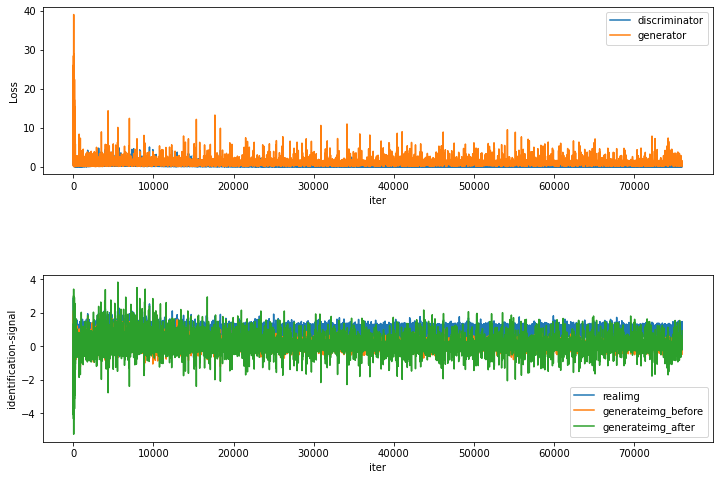

In [19]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [20]:
epochs = 500
outf = '../GAN/LSGAN/oxford_pet_cat_rot/nz500_e2000up'
dispinterval = 30
testgen_interval = 100


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dataloader, device, nz, disc, gene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval, 
                                                                     testgen_interval, fixed_noise, outf)

[1/500][1/38] Loss_D: 0.025 Loss_G: 0.914 D(x): 1.038 D(G(z)): 0.084/0.048
[1/500][31/38] Loss_D: 0.108 Loss_G: 0.774 D(x): 0.696 D(G(z)): 0.054/0.122
-----------エポック1--------------
epochtime:0.2247分
[2/500][1/38] Loss_D: 0.034 Loss_G: 0.910 D(x): 0.940 D(G(z)): -0.006/0.050
[2/500][31/38] Loss_D: 0.039 Loss_G: 0.952 D(x): 0.869 D(G(z)): -0.102/0.026
-----------エポック2--------------
epochtime:0.2221分
[3/500][1/38] Loss_D: 0.066 Loss_G: 0.941 D(x): 0.818 D(G(z)): -0.065/0.035
[3/500][31/38] Loss_D: 0.031 Loss_G: 1.141 D(x): 1.096 D(G(z)): 0.106/-0.066
-----------エポック3--------------
epochtime:0.2207分
[4/500][1/38] Loss_D: 0.332 Loss_G: 0.711 D(x): 1.164 D(G(z)): 0.536/0.162
[4/500][31/38] Loss_D: 0.021 Loss_G: 0.822 D(x): 0.978 D(G(z)): 0.067/0.096
-----------エポック4--------------
epochtime:0.2210分
[5/500][1/38] Loss_D: 0.163 Loss_G: 1.015 D(x): 1.200 D(G(z)): 0.304/-0.001
[5/500][31/38] Loss_D: 0.057 Loss_G: 0.937 D(x): 0.819 D(G(z)): -0.067/0.035
-----------エポック5--------------
epochtime:0.

[41/500][31/38] Loss_D: 0.064 Loss_G: 1.052 D(x): 0.933 D(G(z)): 0.208/-0.023
-----------エポック41--------------
epochtime:0.2213分
[42/500][1/38] Loss_D: 0.065 Loss_G: 0.908 D(x): 0.914 D(G(z)): 0.142/0.057
[42/500][31/38] Loss_D: 0.032 Loss_G: 1.008 D(x): 1.012 D(G(z)): 0.137/-0.001
-----------エポック42--------------
epochtime:0.2214分
[43/500][1/38] Loss_D: 0.576 Loss_G: 1.098 D(x): 1.500 D(G(z)): 0.544/-0.040
[43/500][31/38] Loss_D: 0.034 Loss_G: 0.740 D(x): 0.937 D(G(z)): 0.130/0.142
-----------エポック43--------------
epochtime:0.2210分
[44/500][1/38] Loss_D: 0.173 Loss_G: 0.877 D(x): 1.062 D(G(z)): 0.372/0.070
[44/500][31/38] Loss_D: 0.024 Loss_G: 0.970 D(x): 1.073 D(G(z)): 0.080/0.018
-----------エポック44--------------
epochtime:0.2213分
[45/500][1/38] Loss_D: 0.423 Loss_G: 1.251 D(x): 1.485 D(G(z)): 0.393/-0.112
[45/500][31/38] Loss_D: 0.033 Loss_G: 1.025 D(x): 0.899 D(G(z)): -0.079/-0.010
-----------エポック45--------------
epochtime:0.2209分
[46/500][1/38] Loss_D: 0.227 Loss_G: 1.073 D(x): 1.139 

-----------エポック81--------------
epochtime:0.2208分
[82/500][1/38] Loss_D: 0.356 Loss_G: 0.625 D(x): 0.641 D(G(z)): -0.452/0.216
[82/500][31/38] Loss_D: 0.022 Loss_G: 1.197 D(x): 1.031 D(G(z)): 0.078/-0.092
-----------エポック82--------------
epochtime:0.2208分
[83/500][1/38] Loss_D: 0.052 Loss_G: 0.771 D(x): 0.865 D(G(z)): -0.113/0.127
[83/500][31/38] Loss_D: 0.031 Loss_G: 0.980 D(x): 0.871 D(G(z)): 0.073/0.012
-----------エポック83--------------
epochtime:0.2212分
[84/500][1/38] Loss_D: 0.043 Loss_G: 1.060 D(x): 0.951 D(G(z)): -0.073/-0.021
[84/500][31/38] Loss_D: 0.015 Loss_G: 1.096 D(x): 1.043 D(G(z)): 0.037/-0.045
-----------エポック84--------------
epochtime:0.2196分
[85/500][1/38] Loss_D: 0.184 Loss_G: 0.664 D(x): 0.604 D(G(z)): -0.088/0.191
[85/500][31/38] Loss_D: 0.055 Loss_G: 1.288 D(x): 1.111 D(G(z)): 0.176/-0.132
-----------エポック85--------------
epochtime:0.2210分
[86/500][1/38] Loss_D: 0.149 Loss_G: 1.213 D(x): 1.302 D(G(z)): 0.173/-0.095
[86/500][31/38] Loss_D: 0.016 Loss_G: 1.369 D(x): 1.0

-----------エポック121--------------
epochtime:0.2212分
[122/500][1/38] Loss_D: 0.252 Loss_G: 1.105 D(x): 1.263 D(G(z)): 0.386/-0.045
[122/500][31/38] Loss_D: 0.057 Loss_G: 0.990 D(x): 0.888 D(G(z)): -0.176/0.008
-----------エポック122--------------
epochtime:0.2216分
[123/500][1/38] Loss_D: 0.242 Loss_G: 1.077 D(x): 1.299 D(G(z)): 0.365/-0.032
[123/500][31/38] Loss_D: 0.058 Loss_G: 0.902 D(x): 0.793 D(G(z)): -0.022/0.053
-----------エポック123--------------
epochtime:0.2203分
[124/500][1/38] Loss_D: 0.103 Loss_G: 0.999 D(x): 0.837 D(G(z)): -0.240/0.005
[124/500][31/38] Loss_D: 0.097 Loss_G: 0.883 D(x): 0.819 D(G(z)): -0.218/0.064
-----------エポック124--------------
epochtime:0.2213分
[125/500][1/38] Loss_D: 0.046 Loss_G: 1.306 D(x): 1.141 D(G(z)): 0.083/-0.140
[125/500][31/38] Loss_D: 0.060 Loss_G: 0.775 D(x): 0.798 D(G(z)): -0.080/0.122
-----------エポック125--------------
epochtime:0.2206分
[126/500][1/38] Loss_D: 0.444 Loss_G: 1.645 D(x): 1.401 D(G(z)): 0.512/-0.279
[126/500][31/38] Loss_D: 0.145 Loss_G: 

[161/500][31/38] Loss_D: 0.059 Loss_G: 0.939 D(x): 1.010 D(G(z)): 0.220/0.033
-----------エポック161--------------
epochtime:0.2210分
[162/500][1/38] Loss_D: 0.036 Loss_G: 0.995 D(x): 1.051 D(G(z)): -0.094/0.008
[162/500][31/38] Loss_D: 0.012 Loss_G: 1.048 D(x): 1.007 D(G(z)): 0.040/-0.022
-----------エポック162--------------
epochtime:0.2206分
[163/500][1/38] Loss_D: 0.016 Loss_G: 0.919 D(x): 0.985 D(G(z)): 0.021/0.045
[163/500][31/38] Loss_D: 0.066 Loss_G: 0.886 D(x): 0.786 D(G(z)): -0.097/0.060
-----------エポック163--------------
epochtime:0.2213分
[164/500][1/38] Loss_D: 0.421 Loss_G: 0.774 D(x): 0.551 D(G(z)): -0.433/0.126
[164/500][31/38] Loss_D: 0.028 Loss_G: 0.873 D(x): 1.059 D(G(z)): 0.094/0.070
-----------エポック164--------------
epochtime:0.2216分
[165/500][1/38] Loss_D: 0.108 Loss_G: 1.009 D(x): 0.876 D(G(z)): -0.278/-0.002
[165/500][31/38] Loss_D: 0.039 Loss_G: 1.206 D(x): 1.096 D(G(z)): 0.143/-0.096
-----------エポック165--------------
epochtime:0.2210分
[166/500][1/38] Loss_D: 0.274 Loss_G: 1.

[201/500][1/38] Loss_D: 0.046 Loss_G: 1.042 D(x): 1.038 D(G(z)): 0.160/-0.016
[201/500][31/38] Loss_D: 0.044 Loss_G: 0.765 D(x): 0.939 D(G(z)): 0.174/0.128
-----------エポック201--------------
epochtime:0.2216分
[202/500][1/38] Loss_D: 0.137 Loss_G: 1.096 D(x): 1.161 D(G(z)): 0.308/-0.044
[202/500][31/38] Loss_D: 0.046 Loss_G: 1.088 D(x): 1.036 D(G(z)): 0.189/-0.042
-----------エポック202--------------
epochtime:0.2200分
[203/500][1/38] Loss_D: 0.146 Loss_G: 1.057 D(x): 0.917 D(G(z)): 0.349/-0.025
[203/500][31/38] Loss_D: 0.021 Loss_G: 1.035 D(x): 1.098 D(G(z)): -0.015/-0.016
-----------エポック203--------------
epochtime:0.2203分
[204/500][1/38] Loss_D: 0.016 Loss_G: 1.130 D(x): 0.963 D(G(z)): 0.003/-0.060
[204/500][31/38] Loss_D: 0.064 Loss_G: 1.320 D(x): 1.089 D(G(z)): 0.212/-0.147
-----------エポック204--------------
epochtime:0.2213分
[205/500][1/38] Loss_D: 0.064 Loss_G: 0.803 D(x): 0.924 D(G(z)): 0.211/0.107
[205/500][31/38] Loss_D: 0.065 Loss_G: 1.209 D(x): 0.994 D(G(z)): -0.222/-0.097
-----------

-----------エポック240--------------
epochtime:0.2209分
[241/500][1/38] Loss_D: 0.081 Loss_G: 1.017 D(x): 0.873 D(G(z)): -0.217/-0.005
[241/500][31/38] Loss_D: 0.041 Loss_G: 1.154 D(x): 1.165 D(G(z)): 0.045/-0.072
-----------エポック241--------------
epochtime:0.2210分
[242/500][1/38] Loss_D: 0.290 Loss_G: 0.883 D(x): 1.243 D(G(z)): 0.463/0.066
[242/500][31/38] Loss_D: 0.077 Loss_G: 1.086 D(x): 1.154 D(G(z)): 0.196/-0.040
-----------エポック242--------------
epochtime:0.2210分
[243/500][1/38] Loss_D: 0.076 Loss_G: 0.853 D(x): 0.908 D(G(z)): -0.222/0.079
[243/500][31/38] Loss_D: 0.028 Loss_G: 1.200 D(x): 1.094 D(G(z)): 0.077/-0.093
-----------エポック243--------------
epochtime:0.2212分
[244/500][1/38] Loss_D: 0.109 Loss_G: 1.073 D(x): 1.192 D(G(z)): 0.226/-0.032
[244/500][31/38] Loss_D: 0.031 Loss_G: 1.075 D(x): 1.024 D(G(z)): 0.125/-0.034
-----------エポック244--------------
epochtime:0.2212分
[245/500][1/38] Loss_D: 0.114 Loss_G: 1.103 D(x): 0.854 D(G(z)): -0.183/-0.042
[245/500][31/38] Loss_D: 0.057 Loss_G:

[280/500][31/38] Loss_D: 0.069 Loss_G: 1.124 D(x): 1.101 D(G(z)): 0.220/-0.059
-----------エポック280--------------
epochtime:0.2214分
[281/500][1/38] Loss_D: 0.269 Loss_G: 0.864 D(x): 1.215 D(G(z)): 0.446/0.075
[281/500][31/38] Loss_D: 0.013 Loss_G: 0.999 D(x): 1.003 D(G(z)): -0.031/0.003
-----------エポック281--------------
epochtime:0.2210分
[282/500][1/38] Loss_D: 0.173 Loss_G: 0.775 D(x): 0.914 D(G(z)): -0.373/0.127
[282/500][31/38] Loss_D: 0.014 Loss_G: 1.319 D(x): 0.993 D(G(z)): -0.054/-0.147
-----------エポック282--------------
epochtime:0.2209分
[283/500][1/38] Loss_D: 0.038 Loss_G: 1.050 D(x): 0.958 D(G(z)): -0.111/-0.020
[283/500][31/38] Loss_D: 0.032 Loss_G: 1.067 D(x): 0.905 D(G(z)): 0.081/-0.031
-----------エポック283--------------
epochtime:0.2210分
[284/500][1/38] Loss_D: 0.032 Loss_G: 0.929 D(x): 0.996 D(G(z)): 0.130/0.039
[284/500][31/38] Loss_D: 0.035 Loss_G: 0.917 D(x): 0.886 D(G(z)): 0.104/0.044
-----------エポック284--------------
epochtime:0.2212分
[285/500][1/38] Loss_D: 0.049 Loss_G: 0

[320/500][1/38] Loss_D: 0.089 Loss_G: 0.702 D(x): 0.797 D(G(z)): 0.164/0.167
[320/500][31/38] Loss_D: 0.024 Loss_G: 1.291 D(x): 1.032 D(G(z)): -0.084/-0.134
-----------エポック320--------------
epochtime:0.2217分
[321/500][1/38] Loss_D: 0.126 Loss_G: 1.378 D(x): 1.222 D(G(z)): 0.244/-0.171
[321/500][31/38] Loss_D: 0.042 Loss_G: 1.249 D(x): 1.106 D(G(z)): -0.138/-0.115
-----------エポック321--------------
epochtime:0.2206分
[322/500][1/38] Loss_D: 0.014 Loss_G: 0.914 D(x): 1.004 D(G(z)): -0.000/0.047
[322/500][31/38] Loss_D: 0.017 Loss_G: 1.013 D(x): 1.053 D(G(z)): 0.059/-0.004
-----------エポック322--------------
epochtime:0.2210分
[323/500][1/38] Loss_D: 0.112 Loss_G: 1.061 D(x): 1.172 D(G(z)): 0.268/-0.027
[323/500][31/38] Loss_D: 0.071 Loss_G: 0.919 D(x): 1.180 D(G(z)): 0.170/0.043
-----------エポック323--------------
epochtime:0.2209分
[324/500][1/38] Loss_D: 0.441 Loss_G: 1.144 D(x): 1.416 D(G(z)): 0.482/-0.062
[324/500][31/38] Loss_D: 0.068 Loss_G: 0.825 D(x): 0.766 D(G(z)): 0.013/0.095
-----------エ

-----------エポック359--------------
epochtime:0.2211分
[360/500][1/38] Loss_D: 0.097 Loss_G: 0.941 D(x): 1.207 D(G(z)): 0.164/0.035
[360/500][31/38] Loss_D: 0.030 Loss_G: 1.319 D(x): 1.098 D(G(z)): 0.100/-0.147
-----------エポック360--------------
epochtime:0.2211分
[361/500][1/38] Loss_D: 0.079 Loss_G: 0.747 D(x): 0.752 D(G(z)): 0.057/0.139
[361/500][31/38] Loss_D: 0.051 Loss_G: 1.067 D(x): 1.100 D(G(z)): 0.173/-0.031
-----------エポック361--------------
epochtime:0.2205分
[362/500][1/38] Loss_D: 0.059 Loss_G: 1.018 D(x): 1.041 D(G(z)): 0.208/-0.006
[362/500][31/38] Loss_D: 0.073 Loss_G: 0.921 D(x): 0.749 D(G(z)): -0.036/0.042
-----------エポック362--------------
epochtime:0.2206分
[363/500][1/38] Loss_D: 0.067 Loss_G: 1.163 D(x): 1.175 D(G(z)): 0.056/-0.070
[363/500][31/38] Loss_D: 0.010 Loss_G: 0.940 D(x): 0.987 D(G(z)): -0.015/0.033
-----------エポック363--------------
epochtime:0.2212分
[364/500][1/38] Loss_D: 0.230 Loss_G: 0.796 D(x): 0.685 D(G(z)): -0.337/0.112
[364/500][31/38] Loss_D: 0.029 Loss_G: 1.

[399/500][31/38] Loss_D: 0.050 Loss_G: 0.958 D(x): 0.901 D(G(z)): 0.161/0.024
-----------エポック399--------------
epochtime:0.2206分
[400/500][1/38] Loss_D: 0.089 Loss_G: 0.897 D(x): 1.022 D(G(z)): 0.275/0.056
[400/500][31/38] Loss_D: 0.044 Loss_G: 0.870 D(x): 0.865 D(G(z)): 0.108/0.070
-----------エポック400--------------
epochtime:0.2247分
[401/500][1/38] Loss_D: 0.041 Loss_G: 1.002 D(x): 1.087 D(G(z)): -0.022/0.005
[401/500][31/38] Loss_D: 0.044 Loss_G: 1.030 D(x): 0.823 D(G(z)): -0.015/-0.013
-----------エポック401--------------
epochtime:0.2218分
[402/500][1/38] Loss_D: 0.214 Loss_G: 0.871 D(x): 0.725 D(G(z)): -0.350/0.070
[402/500][31/38] Loss_D: 0.102 Loss_G: 0.866 D(x): 0.701 D(G(z)): -0.016/0.072
-----------エポック402--------------
epochtime:0.2211分
[403/500][1/38] Loss_D: 0.073 Loss_G: 1.143 D(x): 1.199 D(G(z)): 0.091/-0.060
[403/500][31/38] Loss_D: 0.045 Loss_G: 0.837 D(x): 0.900 D(G(z)): -0.138/0.088
-----------エポック403--------------
epochtime:0.2206分
[404/500][1/38] Loss_D: 0.279 Loss_G: 0.

[439/500][1/38] Loss_D: 0.129 Loss_G: 0.942 D(x): 1.159 D(G(z)): 0.290/0.034
[439/500][31/38] Loss_D: 0.061 Loss_G: 0.906 D(x): 1.097 D(G(z)): 0.207/0.050
-----------エポック439--------------
epochtime:0.2207分
[440/500][1/38] Loss_D: 0.265 Loss_G: 0.747 D(x): 0.535 D(G(z)): -0.180/0.139
[440/500][31/38] Loss_D: 0.016 Loss_G: 0.931 D(x): 0.952 D(G(z)): -0.000/0.037
-----------エポック440--------------
epochtime:0.2222分
[441/500][1/38] Loss_D: 0.328 Loss_G: 0.697 D(x): 0.670 D(G(z)): -0.444/0.171
[441/500][31/38] Loss_D: 0.068 Loss_G: 0.876 D(x): 0.807 D(G(z)): -0.139/0.066
-----------エポック441--------------
epochtime:0.2229分
[442/500][1/38] Loss_D: 0.040 Loss_G: 0.957 D(x): 0.892 D(G(z)): 0.078/0.026
[442/500][31/38] Loss_D: 0.020 Loss_G: 0.945 D(x): 0.918 D(G(z)): 0.029/0.030
-----------エポック442--------------
epochtime:0.2211分
[443/500][1/38] Loss_D: 0.044 Loss_G: 1.193 D(x): 1.139 D(G(z)): 0.084/-0.088
[443/500][31/38] Loss_D: 0.023 Loss_G: 1.022 D(x): 0.909 D(G(z)): -0.073/-0.009
-----------エポッ

-----------エポック478--------------
epochtime:0.2214分
[479/500][1/38] Loss_D: 0.178 Loss_G: 0.708 D(x): 0.717 D(G(z)): -0.240/0.167
[479/500][31/38] Loss_D: 0.040 Loss_G: 0.978 D(x): 1.113 D(G(z)): 0.128/0.013
-----------エポック479--------------
epochtime:0.2211分
[480/500][1/38] Loss_D: 0.102 Loss_G: 0.977 D(x): 1.004 D(G(z)): 0.229/0.020
[480/500][31/38] Loss_D: 0.103 Loss_G: 0.685 D(x): 0.703 D(G(z)): -0.045/0.175
-----------エポック480--------------
epochtime:0.2214分
[481/500][1/38] Loss_D: 0.196 Loss_G: 0.513 D(x): 0.644 D(G(z)): -0.205/0.291
[481/500][31/38] Loss_D: 0.034 Loss_G: 1.051 D(x): 0.856 D(G(z)): -0.006/-0.023
-----------エポック481--------------
epochtime:0.2213分
[482/500][1/38] Loss_D: 0.041 Loss_G: 0.806 D(x): 0.872 D(G(z)): 0.007/0.108
[482/500][31/38] Loss_D: 0.037 Loss_G: 1.136 D(x): 1.143 D(G(z)): 0.055/-0.064
-----------エポック482--------------
epochtime:0.2204分
[483/500][1/38] Loss_D: 0.020 Loss_G: 0.796 D(x): 0.973 D(G(z)): -0.065/0.111
[483/500][31/38] Loss_D: 0.086 Loss_G: 0.

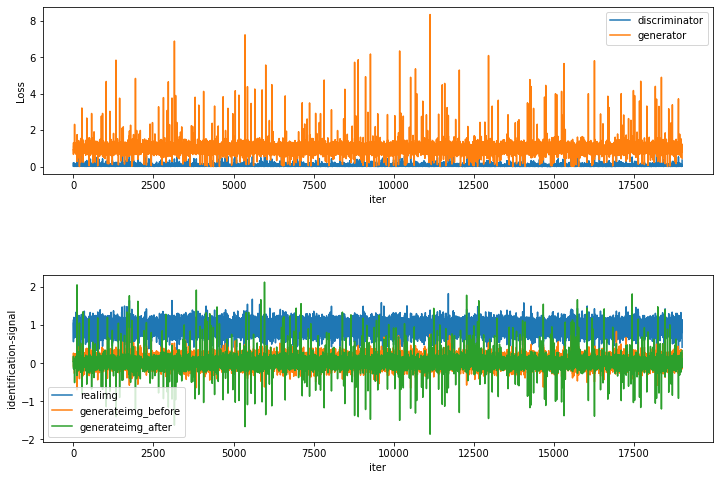

In [21]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [29]:

mddir = "../GAN/model/LSGAN/nz500e2500/"
os.makedirs(mddir, exist_ok = True)

genepath = "gene.pth"
genepath = osp.join(mddir, genepath)
torch.save(gene.state_dict(), genepath)

discpath = "disc.pth"
discpath = osp.join(mddir, discpath)
torch.save(disc.state_dict(), discpath)

In [4]:
#Imagenet
imgnet_root = '../imagenet/dog'

# ImageFolderの前処理, ImageFolderのtransoformに設定
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1辺が224ピクセルの正方形に変換
    transforms.ToTensor(),   # Tensor行列に変換
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ImageFolderのインスタンス生成
imgnetset = ImageFolder(root=imgnet_root, # 画像が保存されているフォルダのパス
                       transform=valid_transform) # Tensorへの変換



In [5]:
chlist = [6000, 2048, 1024, 512, 256, 128, 64, 32, 3]
klist = [3, 3, 3, 3, 3, 3, 2, 2]
strdlist = [1, 1, 2, 2, 2, 2, 2, 2]
padlist = [0, 0, 1, 1, 2, 2, 2, 2]
opadlist = [0, 0, 0, 0, 0, 0, 0, 0]

gene = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)
summary(model = gene, input_size = (1, 6000, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 2048, 3, 3]           --
│    │    └─Sequential: 3-1                   [1, 2048, 3, 3]           --
│    │    │    └─ConvTranspose2d: 4-1         [1, 2048, 3, 3]           110,594,048
│    │    │    └─BatchNorm2d: 4-2             [1, 2048, 3, 3]           4,096
│    │    │    └─ReLU: 4-3                    [1, 2048, 3, 3]           --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 1024, 5, 5]           --
│    │    └─Sequential: 3-2                   [1, 1024, 5, 5]           --
│    │    │    └─ConvTranspose2d: 4-4         [1, 1024, 5, 5]           18,875,392
│    │    │    └─BatchNorm2d: 4-5             [1, 1024, 5, 5]           2,048
│    │    │    └─ReLU: 4-6                    [1, 1024, 5, 5]           

In [6]:
chlist = [3, 32, 64, 128, 256, 512, 1]
klist = [4, 4, 4, 4, 4, 4]
strdlist = [2, 2, 2, 2, 2, 2]
padlist = [1, 1, 0, 0, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0.2, 0.2, 0]

disc = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)
summary(model = disc, input_size = (1, 3, 224, 224), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 32, 112, 112]         --
│    │    └─Sequential: 3-1              [1, 32, 112, 112]         --
│    │    │    └─Conv2d: 4-1             [1, 32, 112, 112]         1,568
│    │    │    └─LeakyReLU: 4-2          [1, 32, 112, 112]         --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 64, 56, 56]           --
│    │    └─Sequential: 3-2              [1, 64, 56, 56]           --
│    │    │    └─Conv2d: 4-3             [1, 64, 56, 56]           32,832
│    │    │    └─BatchNorm2d: 4-4        [1, 64, 56, 56]           128
│    │    │    └─LeakyReLU: 4-5          [1, 64, 56, 56]           --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 128, 27, 27]          --
│    │    └─Sequential: 3-3              [1, 128, 27, 27]          --
│    │ 

In [7]:
batch_size = 16
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(imgnetset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 6000
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


# オプティマイザ−のセットアップ
lrd = 0.00025
lrg = 0.002
beta1 = 0.5
optimizerD = optim.Adam(disc.parameters(), lr=lrd, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gene.parameters(), lr=lrg, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [8]:
epochs = 100
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/DCGAN/imagenet_dog'
dispinterval = 30
testgen_interval = 1


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dl, device, nz, disc, gene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval, 
                                                                     testgen_interval, fixed_noise, outf)

[1/100][1/188] Loss_D: 1.478 Loss_G: 5.657 D(x): 0.434 D(G(z)): 0.456/0.004
[1/100][31/188] Loss_D: 0.938 Loss_G: 2.901 D(x): 0.823 D(G(z)): 0.510/0.056
[1/100][61/188] Loss_D: 1.757 Loss_G: 4.132 D(x): 0.940 D(G(z)): 0.815/0.017
[1/100][91/188] Loss_D: 0.691 Loss_G: 2.044 D(x): 0.968 D(G(z)): 0.480/0.130
[1/100][121/188] Loss_D: 0.355 Loss_G: 2.786 D(x): 0.959 D(G(z)): 0.267/0.062
[1/100][151/188] Loss_D: 0.203 Loss_G: 2.108 D(x): 0.988 D(G(z)): 0.173/0.127
[1/100][181/188] Loss_D: 0.158 Loss_G: 3.227 D(x): 0.978 D(G(z)): 0.126/0.040
-----------エポック1--------------
epochtime:0.4393分
[2/100][1/188] Loss_D: 0.235 Loss_G: 2.649 D(x): 0.985 D(G(z)): 0.194/0.094
[2/100][31/188] Loss_D: 0.627 Loss_G: 7.124 D(x): 0.979 D(G(z)): 0.438/0.001
[2/100][61/188] Loss_D: 0.044 Loss_G: 3.912 D(x): 0.991 D(G(z)): 0.035/0.024
[2/100][91/188] Loss_D: 0.031 Loss_G: 5.191 D(x): 0.988 D(G(z)): 0.019/0.011
[2/100][121/188] Loss_D: 0.023 Loss_G: 5.098 D(x): 0.993 D(G(z)): 0.017/0.006
[2/100][151/188] Loss_D: 

-----------エポック14--------------
epochtime:0.4320分
[15/100][1/188] Loss_D: 1.405 Loss_G: 1.748 D(x): 0.550 D(G(z)): 0.497/0.208
[15/100][31/188] Loss_D: 2.291 Loss_G: 1.295 D(x): 0.613 D(G(z)): 0.783/0.300
[15/100][61/188] Loss_D: 1.350 Loss_G: 1.567 D(x): 0.520 D(G(z)): 0.447/0.225
[15/100][91/188] Loss_D: 1.489 Loss_G: 1.175 D(x): 0.504 D(G(z)): 0.456/0.347
[15/100][121/188] Loss_D: 1.290 Loss_G: 1.722 D(x): 0.687 D(G(z)): 0.552/0.214
[15/100][151/188] Loss_D: 1.247 Loss_G: 1.611 D(x): 0.631 D(G(z)): 0.477/0.230
[15/100][181/188] Loss_D: 1.355 Loss_G: 1.294 D(x): 0.527 D(G(z)): 0.441/0.309
-----------エポック15--------------
epochtime:0.4329分
[16/100][1/188] Loss_D: 1.409 Loss_G: 1.254 D(x): 0.491 D(G(z)): 0.472/0.307
[16/100][31/188] Loss_D: 1.381 Loss_G: 1.300 D(x): 0.400 D(G(z)): 0.282/0.287
[16/100][61/188] Loss_D: 1.231 Loss_G: 1.863 D(x): 0.729 D(G(z)): 0.538/0.205
[16/100][91/188] Loss_D: 1.145 Loss_G: 1.976 D(x): 0.615 D(G(z)): 0.437/0.159
[16/100][121/188] Loss_D: 1.311 Loss_G: 1

[28/100][151/188] Loss_D: 1.376 Loss_G: 1.749 D(x): 0.624 D(G(z)): 0.551/0.195
[28/100][181/188] Loss_D: 1.466 Loss_G: 1.267 D(x): 0.634 D(G(z)): 0.607/0.295
-----------エポック28--------------
epochtime:0.4316分
[29/100][1/188] Loss_D: 1.406 Loss_G: 1.226 D(x): 0.466 D(G(z)): 0.416/0.314
[29/100][31/188] Loss_D: 1.093 Loss_G: 1.338 D(x): 0.540 D(G(z)): 0.353/0.276
[29/100][61/188] Loss_D: 1.180 Loss_G: 2.179 D(x): 0.663 D(G(z)): 0.516/0.129
[29/100][91/188] Loss_D: 1.119 Loss_G: 1.813 D(x): 0.557 D(G(z)): 0.359/0.180
[29/100][121/188] Loss_D: 1.310 Loss_G: 1.342 D(x): 0.629 D(G(z)): 0.553/0.269
[29/100][151/188] Loss_D: 1.378 Loss_G: 1.453 D(x): 0.491 D(G(z)): 0.439/0.256
[29/100][181/188] Loss_D: 1.714 Loss_G: 1.466 D(x): 0.337 D(G(z)): 0.421/0.256
-----------エポック29--------------
epochtime:0.4308分
[30/100][1/188] Loss_D: 1.437 Loss_G: 1.153 D(x): 0.422 D(G(z)): 0.406/0.325
[30/100][31/188] Loss_D: 1.365 Loss_G: 1.322 D(x): 0.421 D(G(z)): 0.349/0.294
[30/100][61/188] Loss_D: 1.557 Loss_G: 

[42/100][91/188] Loss_D: 1.487 Loss_G: 1.348 D(x): 0.412 D(G(z)): 0.404/0.276
[42/100][121/188] Loss_D: 0.997 Loss_G: 1.741 D(x): 0.662 D(G(z)): 0.416/0.193
[42/100][151/188] Loss_D: 1.385 Loss_G: 1.403 D(x): 0.531 D(G(z)): 0.489/0.263
[42/100][181/188] Loss_D: 1.216 Loss_G: 1.414 D(x): 0.547 D(G(z)): 0.419/0.258
-----------エポック42--------------
epochtime:0.4308分
[43/100][1/188] Loss_D: 1.418 Loss_G: 1.586 D(x): 0.570 D(G(z)): 0.552/0.219
[43/100][31/188] Loss_D: 1.482 Loss_G: 1.506 D(x): 0.560 D(G(z)): 0.569/0.241
[43/100][61/188] Loss_D: 1.149 Loss_G: 1.239 D(x): 0.548 D(G(z)): 0.390/0.298
[43/100][91/188] Loss_D: 1.366 Loss_G: 1.273 D(x): 0.516 D(G(z)): 0.473/0.288
[43/100][121/188] Loss_D: 1.526 Loss_G: 1.279 D(x): 0.571 D(G(z)): 0.586/0.296
[43/100][151/188] Loss_D: 0.923 Loss_G: 1.892 D(x): 0.610 D(G(z)): 0.321/0.161
[43/100][181/188] Loss_D: 1.159 Loss_G: 1.716 D(x): 0.609 D(G(z)): 0.468/0.191
-----------エポック43--------------
epochtime:0.4312分
[44/100][1/188] Loss_D: 1.341 Loss_G:

[56/100][31/188] Loss_D: 1.075 Loss_G: 1.708 D(x): 0.612 D(G(z)): 0.420/0.196
[56/100][61/188] Loss_D: 1.211 Loss_G: 1.907 D(x): 0.542 D(G(z)): 0.408/0.156
[56/100][91/188] Loss_D: 1.242 Loss_G: 1.911 D(x): 0.535 D(G(z)): 0.426/0.159
[56/100][121/188] Loss_D: 1.490 Loss_G: 2.864 D(x): 0.713 D(G(z)): 0.662/0.063
[56/100][151/188] Loss_D: 1.565 Loss_G: 2.636 D(x): 0.508 D(G(z)): 0.536/0.084
[56/100][181/188] Loss_D: 1.071 Loss_G: 2.058 D(x): 0.645 D(G(z)): 0.440/0.139
-----------エポック56--------------
epochtime:0.4325分
[57/100][1/188] Loss_D: 1.369 Loss_G: 1.744 D(x): 0.526 D(G(z)): 0.479/0.184
[57/100][31/188] Loss_D: 1.583 Loss_G: 2.286 D(x): 0.329 D(G(z)): 0.273/0.123
[57/100][61/188] Loss_D: 1.420 Loss_G: 2.070 D(x): 0.564 D(G(z)): 0.534/0.136
[57/100][91/188] Loss_D: 1.181 Loss_G: 1.947 D(x): 0.651 D(G(z)): 0.450/0.189
[57/100][121/188] Loss_D: 1.127 Loss_G: 2.565 D(x): 0.694 D(G(z)): 0.507/0.091
[57/100][151/188] Loss_D: 1.154 Loss_G: 1.359 D(x): 0.543 D(G(z)): 0.377/0.270
[57/100][1

-----------エポック69--------------
epochtime:0.4376分
[70/100][1/188] Loss_D: 0.960 Loss_G: 2.203 D(x): 0.672 D(G(z)): 0.401/0.125
[70/100][31/188] Loss_D: 0.897 Loss_G: 2.483 D(x): 0.768 D(G(z)): 0.450/0.090
[70/100][61/188] Loss_D: 1.062 Loss_G: 2.550 D(x): 0.646 D(G(z)): 0.445/0.086
[70/100][91/188] Loss_D: 1.261 Loss_G: 2.654 D(x): 0.575 D(G(z)): 0.474/0.082
[70/100][121/188] Loss_D: 1.466 Loss_G: 2.348 D(x): 0.606 D(G(z)): 0.574/0.110
[70/100][151/188] Loss_D: 1.071 Loss_G: 1.920 D(x): 0.599 D(G(z)): 0.352/0.151
[70/100][181/188] Loss_D: 0.916 Loss_G: 2.691 D(x): 0.750 D(G(z)): 0.436/0.085
-----------エポック70--------------
epochtime:0.4409分
[71/100][1/188] Loss_D: 1.864 Loss_G: 3.335 D(x): 0.806 D(G(z)): 0.793/0.040
[71/100][31/188] Loss_D: 1.141 Loss_G: 2.117 D(x): 0.545 D(G(z)): 0.378/0.132
[71/100][61/188] Loss_D: 1.029 Loss_G: 1.910 D(x): 0.575 D(G(z)): 0.322/0.168
[71/100][91/188] Loss_D: 0.879 Loss_G: 2.410 D(x): 0.740 D(G(z)): 0.421/0.102
[71/100][121/188] Loss_D: 0.976 Loss_G: 2

[83/100][151/188] Loss_D: 1.117 Loss_G: 1.602 D(x): 0.589 D(G(z)): 0.419/0.217
[83/100][181/188] Loss_D: 1.247 Loss_G: 1.609 D(x): 0.614 D(G(z)): 0.500/0.211
-----------エポック83--------------
epochtime:0.4437分
[84/100][1/188] Loss_D: 1.306 Loss_G: 1.473 D(x): 0.466 D(G(z)): 0.395/0.234
[84/100][31/188] Loss_D: 1.219 Loss_G: 1.579 D(x): 0.652 D(G(z)): 0.514/0.213
[84/100][61/188] Loss_D: 1.706 Loss_G: 1.926 D(x): 0.533 D(G(z)): 0.635/0.159
[84/100][91/188] Loss_D: 1.253 Loss_G: 1.555 D(x): 0.555 D(G(z)): 0.464/0.220
[84/100][121/188] Loss_D: 1.640 Loss_G: 1.334 D(x): 0.399 D(G(z)): 0.487/0.268
[84/100][151/188] Loss_D: 0.879 Loss_G: 2.680 D(x): 0.763 D(G(z)): 0.445/0.074
[84/100][181/188] Loss_D: 1.397 Loss_G: 1.399 D(x): 0.435 D(G(z)): 0.393/0.270
-----------エポック84--------------
epochtime:0.4406分
[85/100][1/188] Loss_D: 1.233 Loss_G: 1.808 D(x): 0.653 D(G(z)): 0.530/0.190
[85/100][31/188] Loss_D: 1.298 Loss_G: 1.603 D(x): 0.532 D(G(z)): 0.442/0.209
[85/100][61/188] Loss_D: 1.316 Loss_G: 

[97/100][91/188] Loss_D: 0.037 Loss_G: 4.487 D(x): 0.994 D(G(z)): 0.030/0.013
[97/100][121/188] Loss_D: 0.038 Loss_G: 6.033 D(x): 0.966 D(G(z)): 0.003/0.004
[97/100][151/188] Loss_D: 0.111 Loss_G: 3.157 D(x): 0.991 D(G(z)): 0.097/0.045
[97/100][181/188] Loss_D: 0.081 Loss_G: 5.396 D(x): 0.981 D(G(z)): 0.059/0.005
-----------エポック97--------------
epochtime:0.4327分
[98/100][1/188] Loss_D: 0.007 Loss_G: 8.392 D(x): 0.993 D(G(z)): 0.000/0.000
[98/100][31/188] Loss_D: 0.714 Loss_G: 5.854 D(x): 0.524 D(G(z)): 0.001/0.004
[98/100][61/188] Loss_D: 0.108 Loss_G: 3.227 D(x): 0.986 D(G(z)): 0.089/0.041
[98/100][91/188] Loss_D: 1.165 Loss_G: 7.653 D(x): 0.983 D(G(z)): 0.673/0.001
[98/100][121/188] Loss_D: 0.334 Loss_G: 4.519 D(x): 0.964 D(G(z)): 0.255/0.011
[98/100][151/188] Loss_D: 0.436 Loss_G: 3.925 D(x): 0.957 D(G(z)): 0.308/0.024
[98/100][181/188] Loss_D: 0.064 Loss_G: 4.028 D(x): 0.978 D(G(z)): 0.041/0.019
-----------エポック98--------------
epochtime:0.4321分
[99/100][1/188] Loss_D: 0.499 Loss_G:

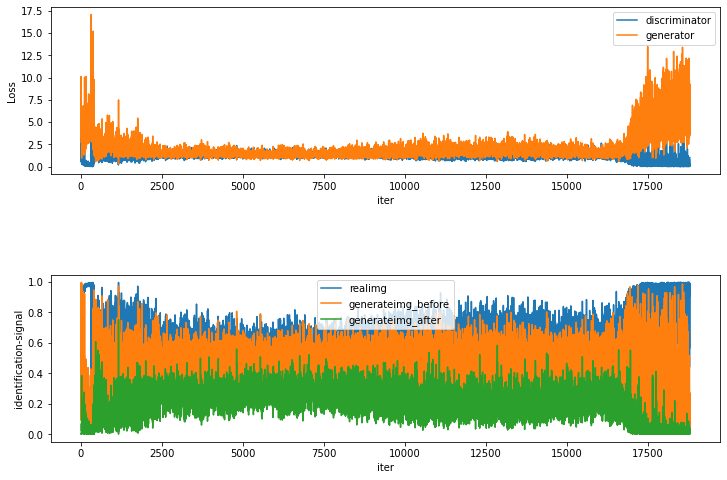

In [9]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [4]:
#Imagenet
imgnet_root = '../imagenet/ILSVRC2012_img_val_for_ImageFolder'

# ImageFolderの前処理, ImageFolderのtransoformに設定
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1辺が224ピクセルの正方形に変換
    transforms.ToTensor(),   # Tensor行列に変換
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# ImageFolderのインスタンス生成
imgnetset = ImageFolder(root=imgnet_root, # 画像が保存されているフォルダのパス
                       transform=valid_transform) # Tensorへの変換



In [5]:
len(imgnetset), imgnetset[0][0].shape

(50000, torch.Size([3, 224, 224]))

In [6]:
imgnetset[0][0]

tensor([[[-0.0353,  0.0745,  0.2941,  ...,  0.4275,  0.5608,  0.4902],
         [-0.2000,  0.4039,  0.5059,  ...,  0.3725,  0.5373,  0.5059],
         [ 0.4353,  0.0667,  0.3176,  ...,  0.2471,  0.2863,  0.2157],
         ...,
         [ 0.0510, -0.0588, -0.0510,  ...,  0.2706,  0.0902, -0.1216],
         [-0.1529, -0.1608, -0.0980,  ...,  0.1922, -0.0824, -0.1843],
         [-0.2627, -0.2627, -0.1373,  ..., -0.0353, -0.1843, -0.2314]],

        [[ 0.0431,  0.0510,  0.3098,  ...,  0.4745,  0.6314,  0.5765],
         [-0.1765,  0.4353,  0.6235,  ...,  0.4196,  0.6078,  0.5922],
         [ 0.4745,  0.2078,  0.5765,  ...,  0.3176,  0.3882,  0.3255],
         ...,
         [ 0.3961,  0.3020,  0.1922,  ...,  0.5137,  0.1686, -0.1137],
         [ 0.2235,  0.1451,  0.0902,  ...,  0.2863, -0.0588, -0.1529],
         [ 0.0353,  0.0353,  0.1686,  ..., -0.0039, -0.1529, -0.1843]],

        [[-0.4118, -0.3020,  0.2627,  ...,  0.4353,  0.5765,  0.4980],
         [-0.3412,  0.0353,  0.5451,  ...,  0

In [7]:
imgnetset[0][1]

0

In [8]:
##########----------------------------DCGAN------------------------------###############

In [9]:
#IMAGENET

In [10]:
chlist = [6000, 2048, 1024, 512, 256, 128, 64, 3]
klist = [3, 3, 4, 4, 4, 4, 4]
strdlist = [1, 2, 2, 2, 2, 2, 2]
padlist = [0, 0, 1, 1, 1, 1, 1]
opadlist = [0, 0, 0, 0, 0, 0, 0]

gene = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)
summary(model = gene, input_size = (1, 6000, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 3, 224, 224]          --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 2048, 3, 3]           --
│    │    └─Sequential: 3-1                   [1, 2048, 3, 3]           --
│    │    │    └─ConvTranspose2d: 4-1         [1, 2048, 3, 3]           110,594,048
│    │    │    └─BatchNorm2d: 4-2             [1, 2048, 3, 3]           4,096
│    │    │    └─ReLU: 4-3                    [1, 2048, 3, 3]           --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 1024, 7, 7]           --
│    │    └─Sequential: 3-2                   [1, 1024, 7, 7]           --
│    │    │    └─ConvTranspose2d: 4-4         [1, 1024, 7, 7]           18,875,392
│    │    │    └─BatchNorm2d: 4-5             [1, 1024, 7, 7]           2,048
│    │    │    └─ReLU: 4-6                    [1, 1024, 7, 7]           

In [11]:
chlist = [3, 16, 32, 64, 128, 256, 1]
klist = [4, 4, 4, 4, 4, 4]
strdlist = [2, 2, 2, 2, 2, 2]
padlist = [1, 1, 0, 0, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0.2, 0.2, 0]

disc = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)
summary(model = disc, input_size = (1, 3, 224, 224), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 16, 112, 112]         --
│    │    └─Sequential: 3-1              [1, 16, 112, 112]         --
│    │    │    └─Conv2d: 4-1             [1, 16, 112, 112]         784
│    │    │    └─LeakyReLU: 4-2          [1, 16, 112, 112]         --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 32, 56, 56]           --
│    │    └─Sequential: 3-2              [1, 32, 56, 56]           --
│    │    │    └─Conv2d: 4-3             [1, 32, 56, 56]           8,224
│    │    │    └─BatchNorm2d: 4-4        [1, 32, 56, 56]           64
│    │    │    └─LeakyReLU: 4-5          [1, 32, 56, 56]           --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 64, 27, 27]           --
│    │    └─Sequential: 3-3              [1, 64, 27, 27]           --
│    │    │

In [12]:
batch_size = 64
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(imgnetset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 6000
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


# オプティマイザ−のセットアップ
lrd = 0.0001
lrg = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(disc.parameters(), lr=lrd, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gene.parameters(), lr=lrg, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [13]:
epochs = 5
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/DCGAN/imagenet'
dispinterval = 128
testgen_interval = 1


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dl, device, nz, disc, gene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval, 
                                                                     testgen_interval, fixed_noise, outf)

[1/5][1/782] Loss_D: 1.403 Loss_G: 1.137 D(x): 0.490 D(G(z)): 0.484/0.329
[1/5][129/782] Loss_D: 4.287 Loss_G: 0.245 D(x): 0.258 D(G(z)): 0.945/0.782
[1/5][257/782] Loss_D: 2.880 Loss_G: 0.406 D(x): 0.291 D(G(z)): 0.803/0.666
[1/5][385/782] Loss_D: 2.092 Loss_G: 0.512 D(x): 0.375 D(G(z)): 0.663/0.600
[1/5][513/782] Loss_D: 1.543 Loss_G: 0.674 D(x): 0.466 D(G(z)): 0.541/0.510
[1/5][641/782] Loss_D: 1.507 Loss_G: 0.704 D(x): 0.474 D(G(z)): 0.532/0.495
[1/5][769/782] Loss_D: 1.462 Loss_G: 0.710 D(x): 0.489 D(G(z)): 0.526/0.492
[2/5][1/782] Loss_D: 1.456 Loss_G: 0.720 D(x): 0.490 D(G(z)): 0.524/0.487
[2/5][129/782] Loss_D: 1.457 Loss_G: 0.715 D(x): 0.496 D(G(z)): 0.530/0.489
[2/5][257/782] Loss_D: 1.361 Loss_G: 0.775 D(x): 0.535 D(G(z)): 0.520/0.461
[2/5][385/782] Loss_D: 1.268 Loss_G: 0.824 D(x): 0.567 D(G(z)): 0.503/0.439
[2/5][513/782] Loss_D: 0.847 Loss_G: 1.131 D(x): 0.770 D(G(z)): 0.443/0.323
[2/5][641/782] Loss_D: 1.463 Loss_G: 0.775 D(x): 0.473 D(G(z)): 0.506/0.462
[2/5][769/782] L

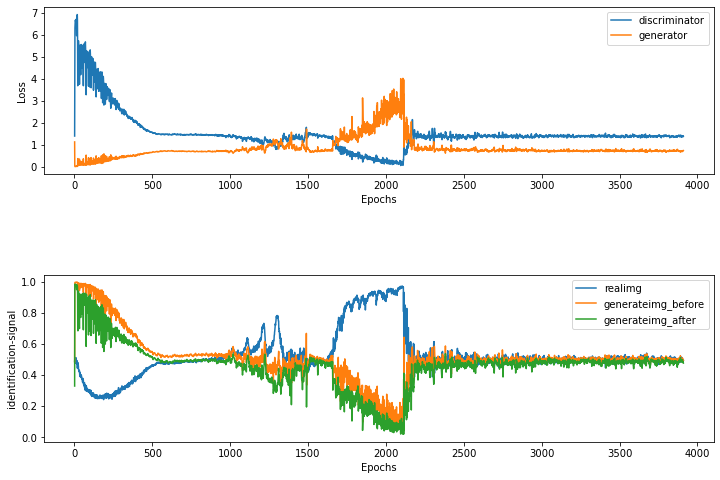

In [14]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [46]:
chlist = [100, 512, 256, 128, 1]
klist = [3, 3, 4, 4]
strdlist = [1, 2, 2, 2]
padlist = [0, 0, 1, 1]
opadlist = [0, 0, 0, 0]

gene = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)

In [47]:
gene

Generator(
  (Deconvs): Sequential(
    (0): Convtp_Bn_ReLu(
      (Deconv): Sequential(
        (0): ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (1): Convtp_Bn_ReLu(
      (Deconv): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (2): Convtp_Bn_ReLu(
      (Deconv): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (3): Convtp_Tanh(
      (Deconv): Sequential(
        (0): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): Tanh()
      )
    )
  )
)

In [48]:
summary(model = gene, input_size = (1, 100, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 1, 28, 28]            --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 512, 3, 3]            --
│    │    └─Sequential: 3-1                   [1, 512, 3, 3]            --
│    │    │    └─ConvTranspose2d: 4-1         [1, 512, 3, 3]            461,312
│    │    │    └─BatchNorm2d: 4-2             [1, 512, 3, 3]            1,024
│    │    │    └─ReLU: 4-3                    [1, 512, 3, 3]            --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 256, 7, 7]            --
│    │    └─Sequential: 3-2                   [1, 256, 7, 7]            --
│    │    │    └─ConvTranspose2d: 4-4         [1, 256, 7, 7]            1,179,904
│    │    │    └─BatchNorm2d: 4-5             [1, 256, 7, 7]            512
│    │    │    └─ReLU: 4-6                    [1, 256, 7, 7]            --
│   

In [49]:
chlist = [1, 128, 256, 512, 1]
klist = [4, 4, 3, 3]
strdlist = [2, 2, 2, 1]
padlist = [1, 1, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0]

disc = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)

In [50]:
disc

Discriminator(
  (Convs): Sequential(
    (0): Conv_LeakyReLU(
      (CNN): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
    (1): Conv_Bn_LeakyReLU(
      (CNN): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (2): Conv_Bn_LeakyReLU(
      (CNN): Sequential(
        (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2)
      )
    )
    (3): Conv_Sigmoid(
      (CNN): Sequential(
        (0): Conv2d(512, 1, kernel_size=(3, 3), stride=(1, 1))
        (1): Sigmoid()
      )
    )
  )
)

In [51]:
summary(model = disc, input_size = (1, 1, 28, 28), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 128, 14, 14]          --
│    │    └─Sequential: 3-1              [1, 128, 14, 14]          --
│    │    │    └─Conv2d: 4-1             [1, 128, 14, 14]          2,176
│    │    │    └─LeakyReLU: 4-2          [1, 128, 14, 14]          --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 256, 7, 7]            --
│    │    └─Sequential: 3-2              [1, 256, 7, 7]            --
│    │    │    └─Conv2d: 4-3             [1, 256, 7, 7]            524,544
│    │    │    └─BatchNorm2d: 4-4        [1, 256, 7, 7]            512
│    │    │    └─LeakyReLU: 4-5          [1, 256, 7, 7]            --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 512, 3, 3]            --
│    │    └─Sequential: 3-3              [1, 512, 3, 3]            --
│    │

In [4]:
dataset = dset.MNIST(root='../torch_dataset/mnist_root', download=True, train=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)) ])) 

In [11]:
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(dataset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gene.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [17]:
gene.children()

<generator object Module.children at 0x000002088B5BBF20>

In [18]:
children = gene.children()

In [20]:
print(children)

<generator object Module.children at 0x00000208934DD120>


In [23]:
gene.Deconvs[0].Deconv[0]

ConvTranspose2d(100, 512, kernel_size=(3, 3), stride=(1, 1))

In [15]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dl, device, nz, disc, gene, criterion, \
                                                     optimizerG, optimizerD, 
                                                     dispinterval,
                                                     testgen_interval, fixed_noise, outf)

[1/30][1/235] Loss_D: 1.355 Loss_G: 1.388 D(x): 0.532 D(G(z)): 0.500/0.260
[1/30][65/235] Loss_D: 0.004 Loss_G: 6.837 D(x): 0.998 D(G(z)): 0.002/0.001
[1/30][129/235] Loss_D: 0.003 Loss_G: 7.296 D(x): 0.999 D(G(z)): 0.002/0.001
[1/30][193/235] Loss_D: 0.763 Loss_G: 3.102 D(x): 0.534 D(G(z)): 0.044/0.052
[2/30][1/235] Loss_D: 0.490 Loss_G: 3.035 D(x): 0.751 D(G(z)): 0.129/0.071
[2/30][65/235] Loss_D: 0.733 Loss_G: 2.387 D(x): 0.573 D(G(z)): 0.078/0.118
[2/30][129/235] Loss_D: 1.642 Loss_G: 0.536 D(x): 0.252 D(G(z)): 0.042/0.615
[2/30][193/235] Loss_D: 0.846 Loss_G: 1.422 D(x): 0.685 D(G(z)): 0.345/0.264
[3/30][1/235] Loss_D: 0.820 Loss_G: 1.317 D(x): 0.654 D(G(z)): 0.296/0.296
[3/30][65/235] Loss_D: 0.837 Loss_G: 1.205 D(x): 0.595 D(G(z)): 0.241/0.325
[3/30][129/235] Loss_D: 1.263 Loss_G: 0.610 D(x): 0.354 D(G(z)): 0.127/0.565
[3/30][193/235] Loss_D: 0.776 Loss_G: 0.697 D(x): 0.579 D(G(z)): 0.166/0.519
[4/30][1/235] Loss_D: 0.983 Loss_G: 1.930 D(x): 0.834 D(G(z)): 0.523/0.164
[4/30][65/

[27/30][193/235] Loss_D: 0.504 Loss_G: 2.247 D(x): 0.772 D(G(z)): 0.176/0.145
[28/30][1/235] Loss_D: 0.448 Loss_G: 3.165 D(x): 0.859 D(G(z)): 0.222/0.064
[28/30][65/235] Loss_D: 0.706 Loss_G: 0.817 D(x): 0.571 D(G(z)): 0.062/0.503
[28/30][129/235] Loss_D: 1.099 Loss_G: 3.560 D(x): 0.898 D(G(z)): 0.551/0.047
[28/30][193/235] Loss_D: 0.517 Loss_G: 1.688 D(x): 0.749 D(G(z)): 0.159/0.263
[29/30][1/235] Loss_D: 0.494 Loss_G: 1.820 D(x): 0.720 D(G(z)): 0.106/0.217
[29/30][65/235] Loss_D: 0.876 Loss_G: 3.975 D(x): 0.967 D(G(z)): 0.504/0.037
[29/30][129/235] Loss_D: 0.475 Loss_G: 1.403 D(x): 0.719 D(G(z)): 0.095/0.307
[29/30][193/235] Loss_D: 0.780 Loss_G: 2.536 D(x): 0.779 D(G(z)): 0.352/0.117
[30/30][1/235] Loss_D: 0.402 Loss_G: 2.265 D(x): 0.816 D(G(z)): 0.144/0.147
[30/30][65/235] Loss_D: 0.533 Loss_G: 2.476 D(x): 0.904 D(G(z)): 0.308/0.124
[30/30][129/235] Loss_D: 0.607 Loss_G: 1.980 D(x): 0.677 D(G(z)): 0.140/0.197
[30/30][193/235] Loss_D: 0.625 Loss_G: 1.474 D(x): 0.604 D(G(z)): 0.051/0

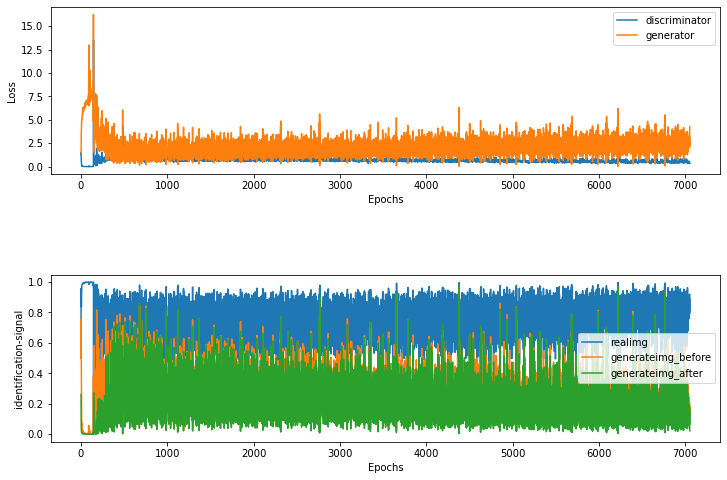

In [16]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [14]:
fmset = dset.FashionMNIST(root='../torch_dataset/fashionmnist_root', download=True, train=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)) ])) 

In [52]:
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(fmset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(disc.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gene.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [53]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/DCGAN/fashion'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dl, device, nz, disc, gene, criterion, \
                                                     optimizerG, optimizerD, 
                                                     dispinterval,
                                                     testgen_interval, fixed_noise, outf)

[1/30][1/235] Loss_D: 1.441 Loss_G: 1.756 D(x): 0.489 D(G(z)): 0.494/0.181
[1/30][65/235] Loss_D: 0.038 Loss_G: 5.983 D(x): 0.970 D(G(z)): 0.003/0.003
[1/30][129/235] Loss_D: 0.351 Loss_G: 2.773 D(x): 0.894 D(G(z)): 0.199/0.067
[1/30][193/235] Loss_D: 0.972 Loss_G: 1.741 D(x): 0.565 D(G(z)): 0.256/0.211
[2/30][1/235] Loss_D: 0.663 Loss_G: 2.026 D(x): 0.682 D(G(z)): 0.197/0.151
[2/30][65/235] Loss_D: 0.790 Loss_G: 3.093 D(x): 0.800 D(G(z)): 0.395/0.059
[2/30][129/235] Loss_D: 0.783 Loss_G: 1.124 D(x): 0.598 D(G(z)): 0.132/0.367
[2/30][193/235] Loss_D: 0.619 Loss_G: 1.776 D(x): 0.683 D(G(z)): 0.173/0.197
[3/30][1/235] Loss_D: 0.748 Loss_G: 2.581 D(x): 0.752 D(G(z)): 0.329/0.094
[3/30][65/235] Loss_D: 0.802 Loss_G: 1.821 D(x): 0.690 D(G(z)): 0.304/0.194
[3/30][129/235] Loss_D: 0.817 Loss_G: 1.496 D(x): 0.594 D(G(z)): 0.199/0.261
[3/30][193/235] Loss_D: 0.815 Loss_G: 2.318 D(x): 0.749 D(G(z)): 0.368/0.119
[4/30][1/235] Loss_D: 0.791 Loss_G: 1.536 D(x): 0.637 D(G(z)): 0.246/0.245
[4/30][65/

[27/30][193/235] Loss_D: 0.624 Loss_G: 1.779 D(x): 0.730 D(G(z)): 0.222/0.219
[28/30][1/235] Loss_D: 0.548 Loss_G: 2.837 D(x): 0.803 D(G(z)): 0.235/0.106
[28/30][65/235] Loss_D: 0.706 Loss_G: 2.433 D(x): 0.817 D(G(z)): 0.341/0.118
[28/30][129/235] Loss_D: 0.652 Loss_G: 2.633 D(x): 0.864 D(G(z)): 0.349/0.099
[28/30][193/235] Loss_D: 1.500 Loss_G: 1.154 D(x): 0.305 D(G(z)): 0.030/0.460
[29/30][1/235] Loss_D: 0.733 Loss_G: 2.082 D(x): 0.755 D(G(z)): 0.278/0.185
[29/30][65/235] Loss_D: 0.639 Loss_G: 2.760 D(x): 0.832 D(G(z)): 0.322/0.085
[29/30][129/235] Loss_D: 0.499 Loss_G: 1.910 D(x): 0.771 D(G(z)): 0.181/0.205
[29/30][193/235] Loss_D: 0.680 Loss_G: 1.658 D(x): 0.716 D(G(z)): 0.231/0.237
[30/30][1/235] Loss_D: 0.757 Loss_G: 1.828 D(x): 0.657 D(G(z)): 0.193/0.245
[30/30][65/235] Loss_D: 0.915 Loss_G: 1.292 D(x): 0.509 D(G(z)): 0.086/0.366
[30/30][129/235] Loss_D: 0.754 Loss_G: 2.675 D(x): 0.828 D(G(z)): 0.378/0.095
[30/30][193/235] Loss_D: 0.559 Loss_G: 2.524 D(x): 0.786 D(G(z)): 0.236/0

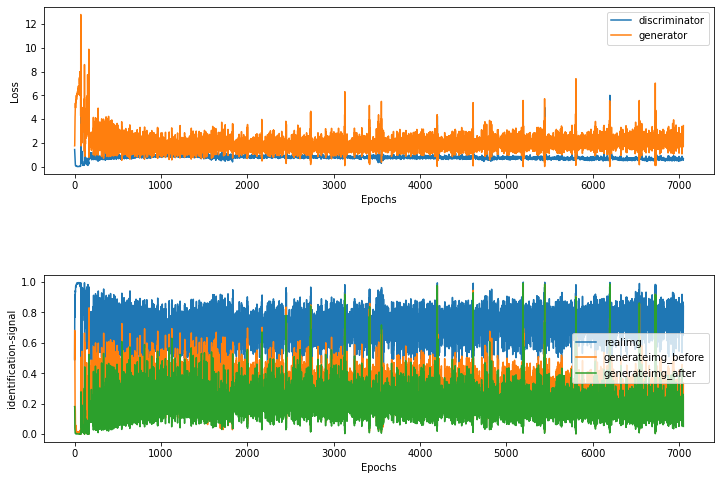

In [54]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [4]:
cifarset = dset.CIFAR10(root='../torch_dataset/cifar10_root', download=True, train=True,
                      transform=transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) ])) 

Files already downloaded and verified


In [19]:
len(cifarset)

50000

In [21]:
len(cifarset[0]), cifarset[0][0].shape

(2, torch.Size([3, 32, 32]))

In [41]:
chlist = [100, 512, 256, 128, 3]
klist = [3, 4, 4, 4]
strdlist = [1, 2, 2, 2]
padlist = [0, 0, 1, 1]
opadlist = [0, 0, 0, 0]

gencifar = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)

summary(model = gencifar, input_size = (1, 100, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 3, 32, 32]            --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 512, 3, 3]            --
│    │    └─Sequential: 3-1                   [1, 512, 3, 3]            --
│    │    │    └─ConvTranspose2d: 4-1         [1, 512, 3, 3]            461,312
│    │    │    └─BatchNorm2d: 4-2             [1, 512, 3, 3]            1,024
│    │    │    └─ReLU: 4-3                    [1, 512, 3, 3]            --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 256, 8, 8]            --
│    │    └─Sequential: 3-2                   [1, 256, 8, 8]            --
│    │    │    └─ConvTranspose2d: 4-4         [1, 256, 8, 8]            2,097,408
│    │    │    └─BatchNorm2d: 4-5             [1, 256, 8, 8]            512
│    │    │    └─ReLU: 4-6                    [1, 256, 8, 8]            --
│   

In [42]:
chlist = [3, 128, 256, 512, 1]
klist = [4, 4, 3, 3]
strdlist = [2, 2, 2, 1]
padlist = [1, 1, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0]

discifar = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)

summary(model = discifar, input_size = (1, 3, 32, 32), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 128, 16, 16]          --
│    │    └─Sequential: 3-1              [1, 128, 16, 16]          --
│    │    │    └─Conv2d: 4-1             [1, 128, 16, 16]          6,272
│    │    │    └─LeakyReLU: 4-2          [1, 128, 16, 16]          --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 256, 8, 8]            --
│    │    └─Sequential: 3-2              [1, 256, 8, 8]            --
│    │    │    └─Conv2d: 4-3             [1, 256, 8, 8]            524,544
│    │    │    └─BatchNorm2d: 4-4        [1, 256, 8, 8]            512
│    │    │    └─LeakyReLU: 4-5          [1, 256, 8, 8]            --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 512, 3, 3]            --
│    │    └─Sequential: 3-3              [1, 512, 3, 3]            --
│    │

In [43]:
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(cifarset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)


# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(discifar.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gencifar.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [44]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/DCGAN/cifar'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_gan(epochs, dl, device, nz, discifar, gencifar, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval,
                                                                     testgen_interval, fixed_noise, outf)

[1/30][1/196] Loss_D: 1.432 Loss_G: 2.132 D(x): 0.521 D(G(z)): 0.525/0.125
[1/30][65/196] Loss_D: 0.054 Loss_G: 6.585 D(x): 0.963 D(G(z)): 0.015/0.001
[1/30][129/196] Loss_D: 0.117 Loss_G: 4.024 D(x): 0.941 D(G(z)): 0.048/0.020
[1/30][193/196] Loss_D: 0.572 Loss_G: 1.758 D(x): 0.673 D(G(z)): 0.009/0.253
[2/30][1/196] Loss_D: 0.203 Loss_G: 3.503 D(x): 0.920 D(G(z)): 0.093/0.041
[2/30][65/196] Loss_D: 0.380 Loss_G: 4.821 D(x): 0.924 D(G(z)): 0.225/0.012
[2/30][129/196] Loss_D: 0.569 Loss_G: 3.580 D(x): 0.790 D(G(z)): 0.215/0.044
[2/30][193/196] Loss_D: 0.555 Loss_G: 2.711 D(x): 0.837 D(G(z)): 0.281/0.083
[3/30][1/196] Loss_D: 0.660 Loss_G: 3.377 D(x): 0.839 D(G(z)): 0.344/0.044
[3/30][65/196] Loss_D: 1.651 Loss_G: 3.573 D(x): 0.299 D(G(z)): 0.011/0.045
[3/30][129/196] Loss_D: 0.607 Loss_G: 4.178 D(x): 0.814 D(G(z)): 0.277/0.023
[3/30][193/196] Loss_D: 0.453 Loss_G: 3.367 D(x): 0.788 D(G(z)): 0.138/0.053
[4/30][1/196] Loss_D: 0.515 Loss_G: 3.935 D(x): 0.781 D(G(z)): 0.181/0.033
[4/30][65/

[27/30][193/196] Loss_D: 0.121 Loss_G: 4.614 D(x): 0.933 D(G(z)): 0.042/0.024
[28/30][1/196] Loss_D: 0.185 Loss_G: 4.430 D(x): 0.911 D(G(z)): 0.067/0.026
[28/30][65/196] Loss_D: 0.029 Loss_G: 5.179 D(x): 0.983 D(G(z)): 0.012/0.013
[28/30][129/196] Loss_D: 0.123 Loss_G: 5.206 D(x): 0.979 D(G(z)): 0.090/0.012
[28/30][193/196] Loss_D: 0.221 Loss_G: 5.459 D(x): 0.945 D(G(z)): 0.125/0.011
[29/30][1/196] Loss_D: 0.188 Loss_G: 4.060 D(x): 0.887 D(G(z)): 0.045/0.034
[29/30][65/196] Loss_D: 0.045 Loss_G: 6.141 D(x): 0.964 D(G(z)): 0.004/0.005
[29/30][129/196] Loss_D: 0.074 Loss_G: 4.248 D(x): 0.948 D(G(z)): 0.015/0.032
[29/30][193/196] Loss_D: 0.055 Loss_G: 5.612 D(x): 0.959 D(G(z)): 0.009/0.011
[30/30][1/196] Loss_D: 2.958 Loss_G: 16.350 D(x): 0.982 D(G(z)): 0.697/0.000
[30/30][65/196] Loss_D: 0.158 Loss_G: 4.949 D(x): 0.893 D(G(z)): 0.024/0.016
[30/30][129/196] Loss_D: 0.078 Loss_G: 4.965 D(x): 0.979 D(G(z)): 0.051/0.015
[30/30][193/196] Loss_D: 0.236 Loss_G: 4.400 D(x): 0.964 D(G(z)): 0.161/

In [15]:
################-------------------------CGAN----------------------------#############################
classes = 10
nz = 100

chlist = [nz + classes, 512, 256, 128, 1]
klist = [3, 3, 4, 4]
strdlist = [1, 2, 2, 2]
padlist = [0, 0, 1, 1]
opadlist = [0, 0, 0, 0]

cgene = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)

summary(model = cgene, input_size = (1, nz + classes, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 1, 28, 28]            --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 512, 3, 3]            --
│    │    └─Sequential: 3-1                   [1, 512, 3, 3]            --
│    │    │    └─ConvTranspose2d: 4-1         [1, 512, 3, 3]            507,392
│    │    │    └─BatchNorm2d: 4-2             [1, 512, 3, 3]            1,024
│    │    │    └─ReLU: 4-3                    [1, 512, 3, 3]            --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 256, 7, 7]            --
│    │    └─Sequential: 3-2                   [1, 256, 7, 7]            --
│    │    │    └─ConvTranspose2d: 4-4         [1, 256, 7, 7]            1,179,904
│    │    │    └─BatchNorm2d: 4-5             [1, 256, 7, 7]            512
│    │    │    └─ReLU: 4-6                    [1, 256, 7, 7]            --
│   

In [16]:

chlist = [classes + 1, 128, 256, 512, 1]
klist = [4, 4, 3, 3]
strdlist = [2, 2, 2, 1]
padlist = [1, 1, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0]

cdisc = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)

summary(model = cdisc, input_size = (1, classes + 1, 28, 28), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 128, 14, 14]          --
│    │    └─Sequential: 3-1              [1, 128, 14, 14]          --
│    │    │    └─Conv2d: 4-1             [1, 128, 14, 14]          22,656
│    │    │    └─LeakyReLU: 4-2          [1, 128, 14, 14]          --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 256, 7, 7]            --
│    │    └─Sequential: 3-2              [1, 256, 7, 7]            --
│    │    │    └─Conv2d: 4-3             [1, 256, 7, 7]            524,544
│    │    │    └─BatchNorm2d: 4-4        [1, 256, 7, 7]            512
│    │    │    └─LeakyReLU: 4-5          [1, 256, 7, 7]            --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 512, 3, 3]            --
│    │    └─Sequential: 3-3              [1, 512, 3, 3]            --
│    

In [17]:
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(dataset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


#固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
# 確認用のラベル。0〜9のラベルの繰り返し
fixed_label = [i for i in range(10)] * (batch_size // 10)
for i in range(batch_size % 10):
    fixed_label.append(i)
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)
# 確認用のノイズとラベルを連結
fixed_noise_label = ganf.concat_noise_label(fixed_noise, fixed_label, device, classes)




# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(cdisc.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(cgene.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [12]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/CGAN/mnist'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_cgan(epochs, dl, classes, device, nz, cdisc, cgene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval,
                                                                     testgen_interval, fixed_noise_label, outf)

[1/30][1/235] Loss_D: 1.429 Loss_G: 1.247 D(x): 0.482 D(G(z)): 0.477/0.308
[1/30][65/235] Loss_D: 0.005 Loss_G: 7.084 D(x): 0.998 D(G(z)): 0.002/0.001
[1/30][129/235] Loss_D: 0.243 Loss_G: 4.961 D(x): 0.862 D(G(z)): 0.048/0.013
[1/30][193/235] Loss_D: 1.175 Loss_G: 4.013 D(x): 0.826 D(G(z)): 0.523/0.032
[2/30][1/235] Loss_D: 0.706 Loss_G: 4.392 D(x): 0.884 D(G(z)): 0.360/0.028
[2/30][65/235] Loss_D: 0.962 Loss_G: 3.189 D(x): 0.874 D(G(z)): 0.509/0.053
[2/30][129/235] Loss_D: 0.895 Loss_G: 1.339 D(x): 0.585 D(G(z)): 0.241/0.299
[2/30][193/235] Loss_D: 0.628 Loss_G: 2.212 D(x): 0.755 D(G(z)): 0.253/0.139
[3/30][1/235] Loss_D: 0.757 Loss_G: 1.836 D(x): 0.754 D(G(z)): 0.326/0.199
[3/30][65/235] Loss_D: 0.865 Loss_G: 1.240 D(x): 0.533 D(G(z)): 0.135/0.335
[3/30][129/235] Loss_D: 0.786 Loss_G: 1.983 D(x): 0.829 D(G(z)): 0.414/0.169
[3/30][193/235] Loss_D: 0.712 Loss_G: 1.049 D(x): 0.711 D(G(z)): 0.281/0.377
[4/30][1/235] Loss_D: 1.096 Loss_G: 1.100 D(x): 0.496 D(G(z)): 0.250/0.370
[4/30][65/

[27/30][193/235] Loss_D: 0.408 Loss_G: 2.105 D(x): 0.767 D(G(z)): 0.129/0.125
[28/30][1/235] Loss_D: 1.119 Loss_G: 0.817 D(x): 0.633 D(G(z)): 0.474/0.447
[28/30][65/235] Loss_D: 0.788 Loss_G: 1.729 D(x): 0.538 D(G(z)): 0.149/0.182
[28/30][129/235] Loss_D: 1.179 Loss_G: 0.684 D(x): 0.716 D(G(z)): 0.563/0.510
[28/30][193/235] Loss_D: 2.114 Loss_G: 0.472 D(x): 0.510 D(G(z)): 0.756/0.626
[29/30][1/235] Loss_D: 2.421 Loss_G: 0.535 D(x): 0.191 D(G(z)): 0.515/0.589
[29/30][65/235] Loss_D: 1.118 Loss_G: 0.779 D(x): 0.872 D(G(z)): 0.621/0.464
[29/30][129/235] Loss_D: 1.670 Loss_G: 0.823 D(x): 0.310 D(G(z)): 0.379/0.443
[29/30][193/235] Loss_D: 0.547 Loss_G: 1.514 D(x): 0.732 D(G(z)): 0.207/0.224
[30/30][1/235] Loss_D: 0.511 Loss_G: 1.570 D(x): 0.770 D(G(z)): 0.218/0.214
[30/30][65/235] Loss_D: 0.428 Loss_G: 1.712 D(x): 0.788 D(G(z)): 0.170/0.185
[30/30][129/235] Loss_D: 1.045 Loss_G: 0.768 D(x): 0.846 D(G(z)): 0.581/0.468
[30/30][193/235] Loss_D: 1.365 Loss_G: 0.766 D(x): 0.619 D(G(z)): 0.581/0

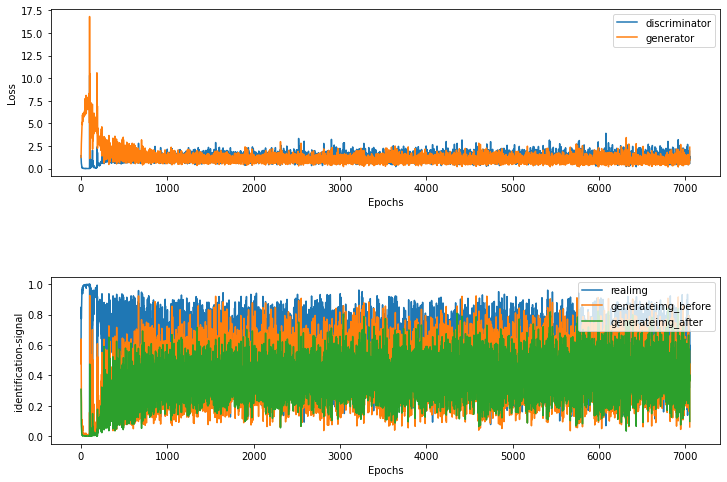

In [13]:
ganf.display_GAN_curv(12, 8, 10, 10, D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out)

In [18]:
#fashion-mnist
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(fmset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


#固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
# 確認用のラベル。0〜9のラベルの繰り返し
fixed_label = [i for i in range(10)] * (batch_size // 10)
for i in range(batch_size % 10):
    fixed_label.append(i)
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)
# 確認用のノイズとラベルを連結
fixed_noise_label = ganf.concat_noise_label(fixed_noise, fixed_label, device, classes)




# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(cdisc.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(cgene.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [19]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/CGAN/fm'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_cgan(epochs, dl, classes, device, nz, cdisc, cgene, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval,
                                                                     testgen_interval, fixed_noise_label, outf)

[1/30][1/235] Loss_D: 1.415 Loss_G: 1.384 D(x): 0.568 D(G(z)): 0.560/0.263
[1/30][65/235] Loss_D: 0.074 Loss_G: 10.605 D(x): 0.991 D(G(z)): 0.060/0.000
[1/30][129/235] Loss_D: 0.075 Loss_G: 5.062 D(x): 0.963 D(G(z)): 0.030/0.010
[1/30][193/235] Loss_D: 0.424 Loss_G: 4.466 D(x): 0.788 D(G(z)): 0.061/0.020
[2/30][1/235] Loss_D: 0.224 Loss_G: 3.945 D(x): 0.958 D(G(z)): 0.153/0.027
[2/30][65/235] Loss_D: 0.888 Loss_G: 2.068 D(x): 0.663 D(G(z)): 0.267/0.167
[2/30][129/235] Loss_D: 1.074 Loss_G: 1.973 D(x): 0.754 D(G(z)): 0.514/0.164
[2/30][193/235] Loss_D: 0.629 Loss_G: 2.964 D(x): 0.812 D(G(z)): 0.312/0.068
[3/30][1/235] Loss_D: 0.740 Loss_G: 1.710 D(x): 0.630 D(G(z)): 0.186/0.219
[3/30][65/235] Loss_D: 0.936 Loss_G: 1.552 D(x): 0.469 D(G(z)): 0.060/0.254
[3/30][129/235] Loss_D: 1.277 Loss_G: 3.322 D(x): 0.923 D(G(z)): 0.649/0.051
[3/30][193/235] Loss_D: 1.158 Loss_G: 0.639 D(x): 0.420 D(G(z)): 0.142/0.558
[4/30][1/235] Loss_D: 0.994 Loss_G: 2.378 D(x): 0.723 D(G(z)): 0.433/0.125
[4/30][65

[27/30][193/235] Loss_D: 0.688 Loss_G: 2.137 D(x): 0.743 D(G(z)): 0.278/0.151
[28/30][1/235] Loss_D: 0.655 Loss_G: 2.339 D(x): 0.823 D(G(z)): 0.325/0.129
[28/30][65/235] Loss_D: 0.639 Loss_G: 2.126 D(x): 0.732 D(G(z)): 0.240/0.157
[28/30][129/235] Loss_D: 0.606 Loss_G: 2.783 D(x): 0.863 D(G(z)): 0.335/0.081
[28/30][193/235] Loss_D: 0.843 Loss_G: 2.671 D(x): 0.789 D(G(z)): 0.399/0.090
[29/30][1/235] Loss_D: 0.750 Loss_G: 3.273 D(x): 0.876 D(G(z)): 0.391/0.051
[29/30][65/235] Loss_D: 0.706 Loss_G: 1.505 D(x): 0.631 D(G(z)): 0.154/0.278
[29/30][129/235] Loss_D: 0.675 Loss_G: 2.082 D(x): 0.756 D(G(z)): 0.281/0.157
[29/30][193/235] Loss_D: 1.102 Loss_G: 0.867 D(x): 0.426 D(G(z)): 0.080/0.485
[30/30][1/235] Loss_D: 0.965 Loss_G: 0.806 D(x): 0.506 D(G(z)): 0.107/0.522
[30/30][65/235] Loss_D: 0.618 Loss_G: 2.477 D(x): 0.816 D(G(z)): 0.304/0.113
[30/30][129/235] Loss_D: 0.731 Loss_G: 2.168 D(x): 0.728 D(G(z)): 0.282/0.146
[30/30][193/235] Loss_D: 0.878 Loss_G: 2.928 D(x): 0.828 D(G(z)): 0.438/0

In [5]:
#cifar10
classes = 10
nz = 100

chlist = [nz + classes, 512, 256, 128, 3]
klist = [3, 4, 4, 4]
strdlist = [1, 2, 2, 2]
padlist = [0, 0, 1, 1]
opadlist = [0, 0, 0, 0]

gencifar = ganmd.Generator(chlist, klist, strdlist, padlist, opadlist)

summary(model = gencifar, input_size = (1, 110, 1, 1), depth = 4)

Layer (type:depth-idx)                        Output Shape              Param #
Generator                                     --                        --
├─Sequential: 1-1                             [1, 3, 32, 32]            --
│    └─Convtp_Bn_ReLu: 2-1                    [1, 512, 3, 3]            --
│    │    └─Sequential: 3-1                   [1, 512, 3, 3]            --
│    │    │    └─ConvTranspose2d: 4-1         [1, 512, 3, 3]            507,392
│    │    │    └─BatchNorm2d: 4-2             [1, 512, 3, 3]            1,024
│    │    │    └─ReLU: 4-3                    [1, 512, 3, 3]            --
│    └─Convtp_Bn_ReLu: 2-2                    [1, 256, 8, 8]            --
│    │    └─Sequential: 3-2                   [1, 256, 8, 8]            --
│    │    │    └─ConvTranspose2d: 4-4         [1, 256, 8, 8]            2,097,408
│    │    │    └─BatchNorm2d: 4-5             [1, 256, 8, 8]            512
│    │    │    └─ReLU: 4-6                    [1, 256, 8, 8]            --
│   

In [6]:
chlist = [classes + 3, 128, 256, 512, 1]
klist = [4, 4, 3, 3]
strdlist = [2, 2, 2, 1]
padlist = [1, 1, 0, 0]
ngsllist = [0.2, 0.2, 0.2, 0]

discifar = ganmd.Discriminator(chlist, klist, strdlist, padlist, ngsllist)

summary(model = discifar, input_size = (1, classes + 3, 32, 32), depth = 4)

Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            --                        --
├─Sequential: 1-1                        [1, 1, 1, 1]              --
│    └─Conv_LeakyReLU: 2-1               [1, 128, 16, 16]          --
│    │    └─Sequential: 3-1              [1, 128, 16, 16]          --
│    │    │    └─Conv2d: 4-1             [1, 128, 16, 16]          26,752
│    │    │    └─LeakyReLU: 4-2          [1, 128, 16, 16]          --
│    └─Conv_Bn_LeakyReLU: 2-2            [1, 256, 8, 8]            --
│    │    └─Sequential: 3-2              [1, 256, 8, 8]            --
│    │    │    └─Conv2d: 4-3             [1, 256, 8, 8]            524,544
│    │    │    └─BatchNorm2d: 4-4        [1, 256, 8, 8]            512
│    │    │    └─LeakyReLU: 4-5          [1, 256, 8, 8]            --
│    └─Conv_Bn_LeakyReLU: 2-3            [1, 512, 3, 3]            --
│    │    └─Sequential: 3-3              [1, 512, 3, 3]            --
│    

In [9]:
#cifar
batch_size = 256
workers = 2

#num_workersは、ミニバッチを返す時の並列実行数、高速化のため
#最大でCPUの論理コア数
dl = DataLoader(cifarset, batch_size = batch_size, shuffle=True, num_workers=int(workers))


criterion = nn.BCELoss()
nz = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


#固定ノイズ
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
# 確認用のラベル。0〜9のラベルの繰り返し
fixed_label = [i for i in range(10)] * (batch_size // 10)
for i in range(batch_size % 10):
    fixed_label.append(i)
fixed_label = torch.tensor(fixed_label, dtype=torch.long, device=device)
# 確認用のノイズとラベルを連結
fixed_noise_label = ganf.concat_noise_label(fixed_noise, fixed_label, device, classes)




# オプティマイザ−のセットアップ
lr = 0.0002
beta1 = 0.5
optimizerD = optim.Adam(discifar.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 識別器D用
optimizerG = optim.Adam(gencifar.parameters(), lr=lr, betas=(beta1, 0.999), weight_decay=1e-5)  # 生成器G用

In [10]:
epochs = 30
criterion = nn.BCELoss()    # バイナリークロスエントロピー（Sigmoid関数無し）
outf = '../GAN/CGAN/cifar'
dispinterval = 64
testgen_interval = 5


D_losses, G_losses, D_x_out, D_G_z1_out, D_G_z2_out = ganf.train_cgan(epochs, dl, classes, device, nz, discifar, gencifar, 
                                                                     criterion, optimizerG, optimizerD, 
                                                                     dispinterval,
                                                                     testgen_interval, fixed_noise_label, outf)

[1/30][1/196] Loss_D: 1.399 Loss_G: 1.812 D(x): 0.527 D(G(z)): 0.521/0.169
[1/30][65/196] Loss_D: 0.020 Loss_G: 11.978 D(x): 0.981 D(G(z)): 0.000/0.000
[1/30][129/196] Loss_D: 0.059 Loss_G: 6.576 D(x): 0.956 D(G(z)): 0.011/0.002
[1/30][193/196] Loss_D: 0.353 Loss_G: 3.734 D(x): 0.766 D(G(z)): 0.049/0.029
[2/30][1/196] Loss_D: 0.763 Loss_G: 5.592 D(x): 0.911 D(G(z)): 0.460/0.004
[2/30][65/196] Loss_D: 1.064 Loss_G: 2.968 D(x): 0.419 D(G(z)): 0.015/0.067
[2/30][129/196] Loss_D: 0.737 Loss_G: 1.918 D(x): 0.691 D(G(z)): 0.223/0.183
[2/30][193/196] Loss_D: 0.867 Loss_G: 1.641 D(x): 0.638 D(G(z)): 0.284/0.227
[3/30][1/196] Loss_D: 0.843 Loss_G: 3.010 D(x): 0.798 D(G(z)): 0.423/0.061
[3/30][65/196] Loss_D: 0.692 Loss_G: 2.268 D(x): 0.628 D(G(z)): 0.139/0.126
[3/30][129/196] Loss_D: 0.716 Loss_G: 1.657 D(x): 0.687 D(G(z)): 0.219/0.216
[3/30][193/196] Loss_D: 0.585 Loss_G: 3.650 D(x): 0.825 D(G(z)): 0.285/0.037
[4/30][1/196] Loss_D: 0.835 Loss_G: 2.659 D(x): 0.755 D(G(z)): 0.364/0.096
[4/30][65

[27/30][193/196] Loss_D: 0.460 Loss_G: 1.475 D(x): 0.711 D(G(z)): 0.042/0.334
[28/30][1/196] Loss_D: 0.463 Loss_G: 2.689 D(x): 0.708 D(G(z)): 0.021/0.176
[28/30][65/196] Loss_D: 0.076 Loss_G: 4.490 D(x): 0.945 D(G(z)): 0.016/0.021
[28/30][129/196] Loss_D: 0.126 Loss_G: 4.901 D(x): 0.985 D(G(z)): 0.101/0.012
[28/30][193/196] Loss_D: 0.755 Loss_G: 2.409 D(x): 0.543 D(G(z)): 0.014/0.144
[29/30][1/196] Loss_D: 0.197 Loss_G: 3.902 D(x): 0.961 D(G(z)): 0.132/0.032
[29/30][65/196] Loss_D: 0.147 Loss_G: 3.938 D(x): 0.990 D(G(z)): 0.121/0.030
[29/30][129/196] Loss_D: 0.166 Loss_G: 4.654 D(x): 0.965 D(G(z)): 0.116/0.015
[29/30][193/196] Loss_D: 0.024 Loss_G: 5.129 D(x): 0.981 D(G(z)): 0.005/0.011
[30/30][1/196] Loss_D: 0.212 Loss_G: 6.362 D(x): 0.993 D(G(z)): 0.156/0.003
[30/30][65/196] Loss_D: 0.039 Loss_G: 6.548 D(x): 0.965 D(G(z)): 0.003/0.003
[30/30][129/196] Loss_D: 0.494 Loss_G: 4.265 D(x): 0.854 D(G(z)): 0.235/0.027
[30/30][193/196] Loss_D: 0.110 Loss_G: 4.013 D(x): 0.956 D(G(z)): 0.058/0

In [ ]:
#########----------------------------LSGAN------------------------------###########


In [30]:
currentdir = os.getcwd()
currentdir

'C:\\Users\\mkopm\\ipynbs'

In [32]:
os.pardir

'..'

In [33]:
sys.path

['C:\\Users\\mkopm\\ipynbs',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\python38.zip',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\DLLs',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch',
 '',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\huggingface_hub-0.0.17-py3.8.egg',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\win32',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\sacremoses-0.0.43-py3.8.egg',
 'C:\\Users\\mkopm\\anaconda3\\envs\\mytorch\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\mkopm\\.ipython',
 '..']

In [47]:
trf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [48]:
data = trf(myset.data)

TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [49]:
data.shape

torch.Size([70000, 28, 28])

In [41]:
data[0]

tensor([[ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,

In [42]:
torch.mean(data), torch.std(data)

(tensor(65.7719), tensor(157.3087))